In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
Images_Tumor_path = '/content/drive/My Drive/CSAW_Images/Tumor'
Images_Tumor_Folder = os.listdir(Images_Tumor_path)

Masks_Tumor_path = '/content/drive/My Drive/CSAW_Images/Tumor/Annotations'
Masks_Tumor_Folder = os.listdir(Masks_Tumor_path)

Images_Healthy_path = '/content/drive/My Drive/CSAW_Images/Healthy'
Images_Healthy_Folder = os.listdir(Images_Healthy_path)

Masks_Healthy_path = '/content/drive/My Drive/CSAW_Images/Healthy/Annotations'
Masks_Healthy_Folder = os.listdir(Masks_Healthy_path)

Mounted at /content/drive


# **Imports**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
import cv2
import tensorflow as tf

In [ ]:
# Sort the file lists to ensure the correct order
sorted_tumor_images = sorted(Images_Tumor_Folder)
sorted_tumor_masks = sorted(Masks_Tumor_Folder)
sorted_healthy_images = sorted(Images_Healthy_Folder)
sorted_healthy_masks = sorted(Masks_Healthy_Folder)

In [ ]:
print(sorted_healthy_images)
print(sorted_healthy_masks)
print(sorted_tumor_images)
print(sorted_tumor_masks)

['00005_20990909_L_MLO_1.dcm', '00005_20990909_L_MLO_2.dcm', '00005_20990909_L_MLO_3.dcm', '00005_20990909_R_CC_1.dcm', '00005_20990909_R_CC_2.dcm', '00005_20990909_R_CC_3.dcm', '00005_20990909_R_CC_4.dcm', '00005_20990909_R_MLO_1.dcm', '00005_20990909_R_MLO_2.dcm', '00005_20990909_R_MLO_3.dcm', '00005_20990909_R_MLO_4.dcm', '00006_20990909_L_CC_1.dcm', '00006_20990909_L_CC_2.dcm', '00006_20990909_L_CC_3.dcm', '00006_20990909_L_CC_4.dcm', '00006_20990909_L_MLO_1.dcm', '00006_20990909_L_MLO_2.dcm', '00006_20990909_L_MLO_3.dcm', '00006_20990909_L_MLO_4.dcm', '00006_20990909_R_CC_1.dcm', '00006_20990909_R_CC_2.dcm', '00006_20990909_R_CC_3.dcm', '00006_20990909_R_CC_4.dcm', '00006_20990909_R_MLO_1.dcm', '00006_20990909_R_MLO_2.dcm', '00006_20990909_R_MLO_3.dcm', '00006_20990909_R_MLO_4.dcm', '00007_20990909_L_CC_1.dcm', '00007_20990909_L_CC_2.dcm', '00007_20990909_L_CC_3.dcm', '00007_20990909_L_CC_4.dcm', '00007_20990909_L_MLO_1.dcm', '00007_20990909_L_MLO_2.dcm', '00007_20990909_L_MLO_3.d

In [ ]:
sorted_tumor_images_path = [os.path.join(Images_Tumor_path, img) for img in sorted_tumor_images]
sorted_tumor_masks_path = [os.path.join(Masks_Tumor_path, mask) for mask in sorted_tumor_masks]
sorted_healthy_images_path = [os.path.join(Images_Healthy_path, img) for img in sorted_healthy_images]
sorted_healthy_masks_path = [os.path.join(Masks_Healthy_path, mask) for mask in sorted_healthy_masks]


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.6 MB/s eta 0:00:00


Visualize images and masks

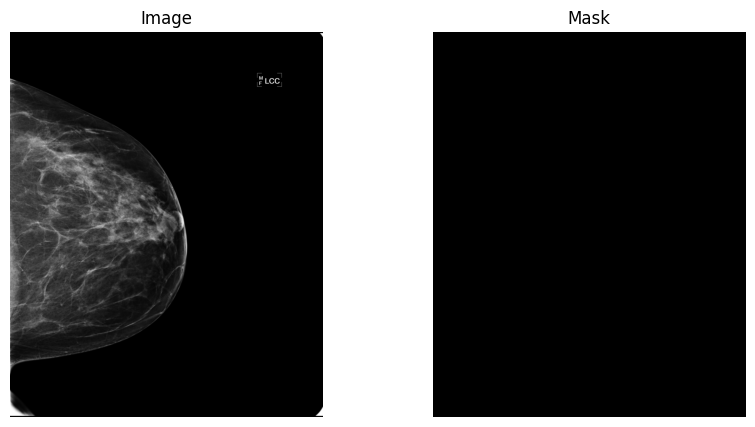

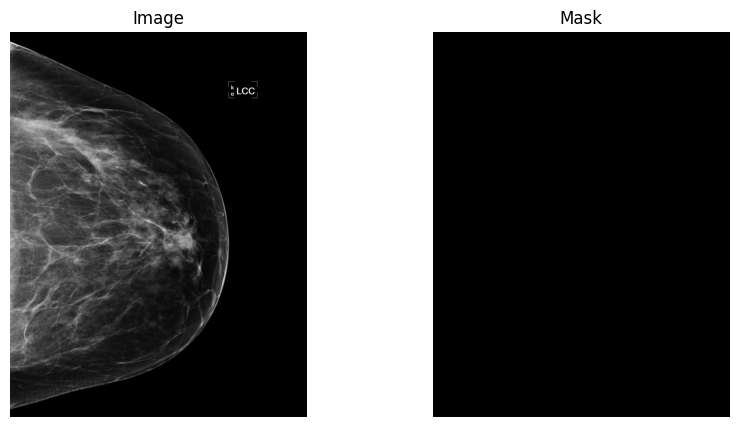

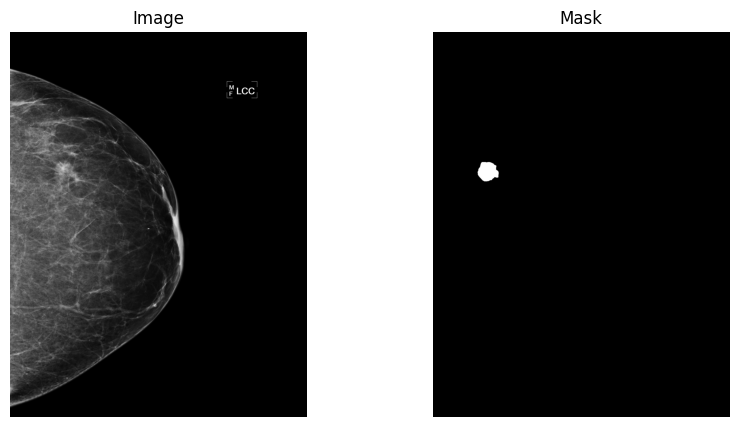

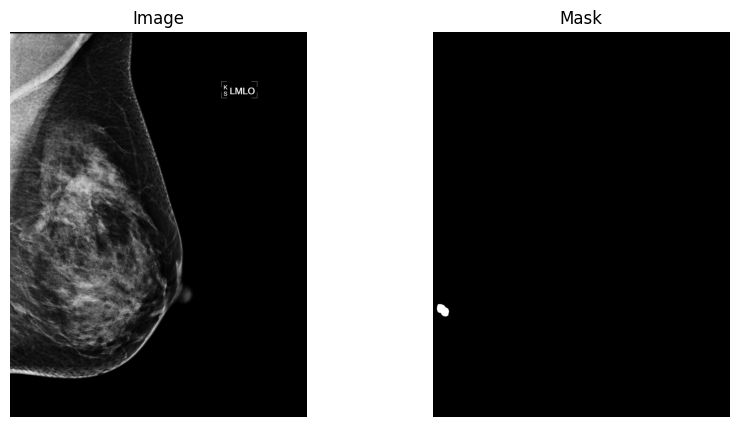

In [ ]:
def display_image_mask(image_path, mask_path):
    # Read image
    ds_image = pydicom.dcmread(image_path)
    image = ds_image.pixel_array

    # Read mask
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale
    mask = np.array(mask)

    # Display image and mask side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap=plt.cm.gray)
    axes[0].set_title("Image")
    axes[0].axis('off')
    axes[1].imshow(mask, cmap=plt.cm.gray)
    axes[1].set_title("Mask")
    axes[1].axis('off')
    plt.show()


# Display 2 healthy images with masks
for i in range(2):
    image_path = os.path.join(Images_Healthy_pfad, sorted_healthy_images[i])
    mask_path = os.path.join(Masks_Healthy_pfad, sorted_healthy_masks[i])
    display_image_mask(image_path, mask_path)

# Display 2 tumor images with masks
for i in range(2):
    image_path = os.path.join(Images_Tumor_pfad, sorted_tumor_images[i])
    mask_path = os.path.join(Masks_Tumor_pfad, sorted_tumor_masks[i])
    display_image_mask(image_path, mask_path)


Functions for cropping, resizing and loading images

In [ ]:
# Function to crop the image and mask based on the bounding box of the image
def crop_image_based_on_image(image, mask):

    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image

    # Normalize image and threshold it to find the contour area
    gray_image = ((gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image)) * 255).astype(np.uint8)
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY)

    # Ensure binary image is of type uint8
    thresh = thresh.astype(np.uint8)

    # Find contours in the image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter small contours by area
    min_contour_area = 1000
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    # Check if any contours remain after filtering
    if len(filtered_contours) > 0:
        # Find the largest contour by area
        largest_contour = max(filtered_contours, key=cv2.contourArea)

        # Create bounding box around the largest contour
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the image and mask using the bounding box
        cropped_image = image[y:y+h, x:x+w]
        cropped_mask = mask[y:y+h, x:x+w]

        return cropped_image, cropped_mask
    else:
        return None, None

# Function to resize and pad the image while maintaining aspect ratio
def resize_and_pad(image, target_size=(224, 224)):
    if image.dtype != np.uint8:
      image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

    # Get current size (height, width)
    old_size = image.shape[:2]

    # Get the aspect ratio
    ratio = min(target_size[1] / old_size[1], target_size[0] / old_size[0])
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    resized = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = int(target_size[1] - new_size[1])
    delta_h = int(target_size[0] - new_size[0])
    top, bottom = int(delta_h // 2), int(delta_h - (delta_h // 2))
    left, right = int(delta_w // 2), int(delta_w - (delta_w // 2))

    # Pad the image
    if len(image.shape) == 2:
        resized_padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    else:
        resized_padded_image = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return resized_padded_image

# Function to load and preprocess the DICOM image and PNG mask
def load_data(img_paths, mask_paths, target_size=(224, 224)):
    original_images = []
    original_masks = []
    processed_images = []
    processed_masks = []

    for img_path, mask_path in zip(img_paths, mask_paths):
        # Load and preprocess DICOM image
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array

        # Load and preprocess the PNG mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Store the original image and mask
        original_images.append(img)
        original_masks.append(mask)

        # Crop the image and mask based on the image bounding box
        img, mask = crop_image_based_on_image(img, mask)
        if img is None or mask is None:
            continue

        # Resize and pad the cropped image and mask
        img = resize_and_pad(img, target_size)
        mask = resize_and_pad(mask, target_size)

        # Convert image to 3 channels (RGB)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Convert mask to a single channel image
        mask = np.expand_dims(mask, axis=-1)

        # Store the processed image and mask
        processed_images.append(img)
        processed_masks.append(mask)

    return original_images, original_masks, processed_images, processed_masks

Testing Preprocessing

(224, 224, 3)
248


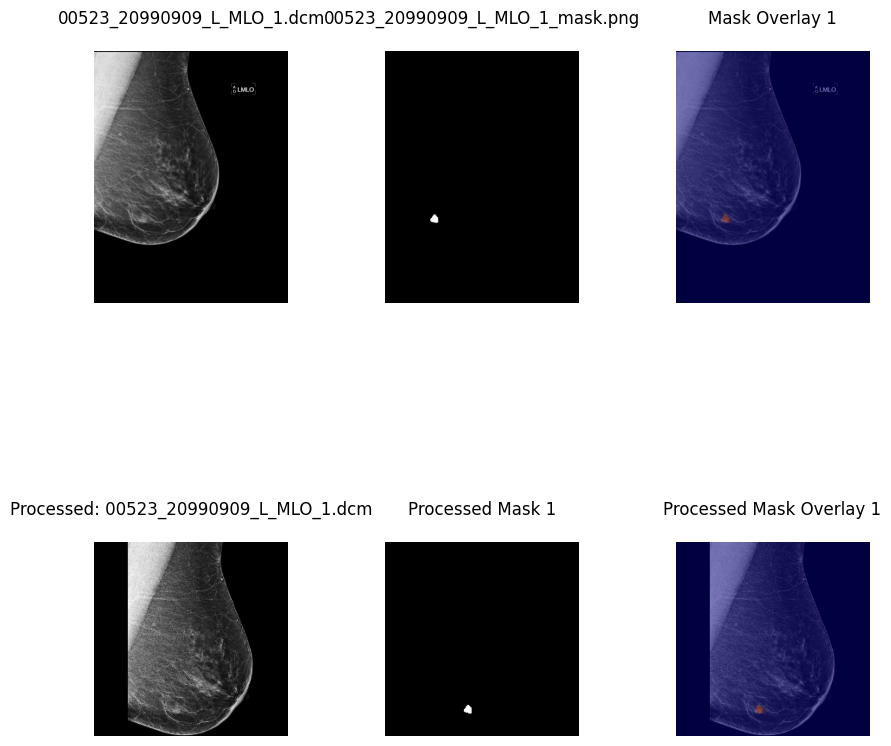

(224, 224, 3)
247


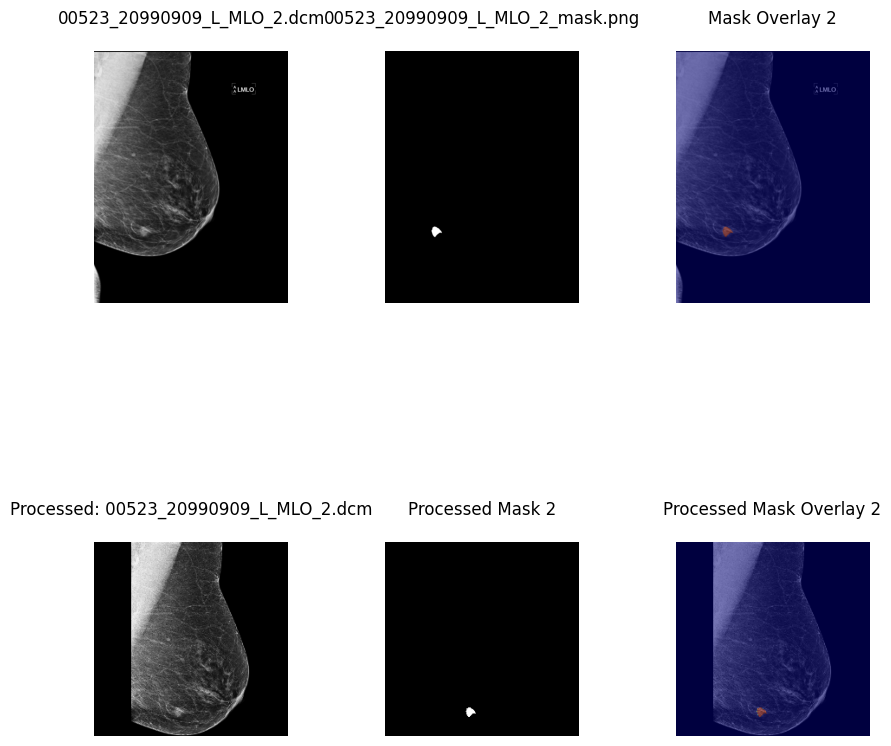

(224, 224, 3)
254


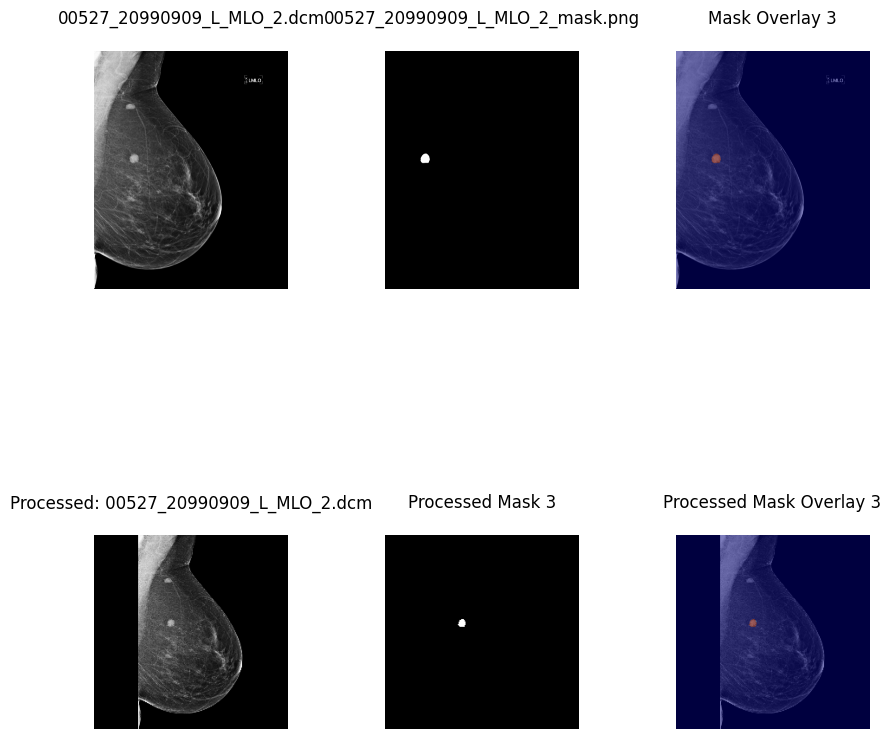

(224, 224, 3)
252


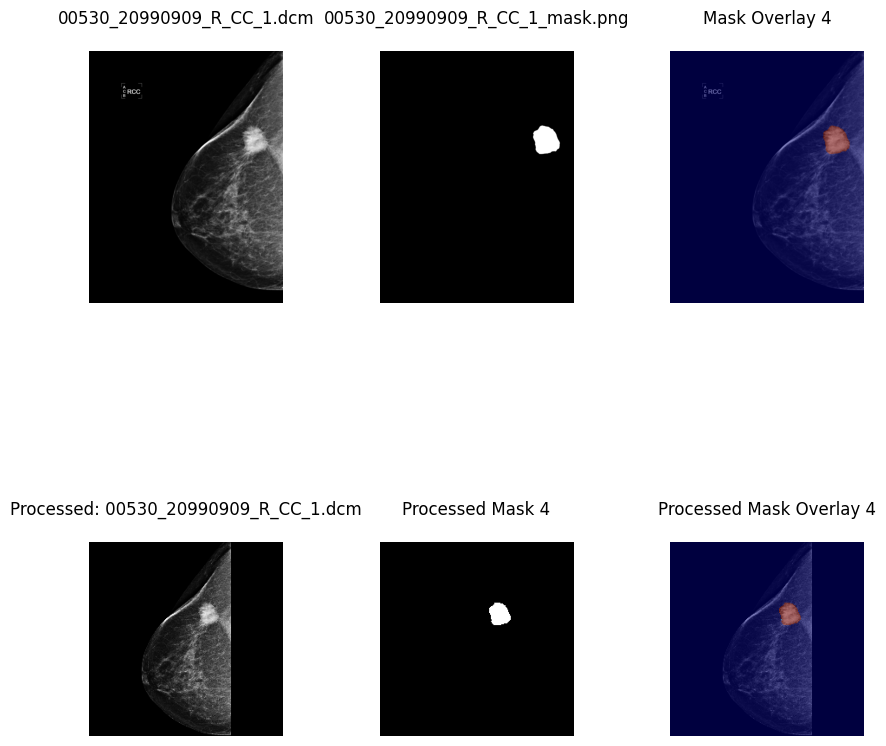

In [ ]:
# Select the 5 pairs of images and masks for testing
img_paths = sorted_tumor_images_path[34:38]
mask_paths = sorted_tumor_masks_path[34:38]

# Load and preprocess the images and masks
original_images, original_masks, processed_images, processed_masks = load_data(img_paths, mask_paths, target_size=(224, 224))

# Display images and masks
for i in range(min(5, len(processed_images))):
    plt.figure(figsize=(10, 10))

    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(f'{os.path.basename(img_paths[i])}', pad=20)
    plt.axis('off')

    # Display the original mask
    plt.subplot(2, 3, 2)
    plt.imshow(original_masks[i], cmap='gray')
    plt.title(f'{os.path.basename(mask_paths[i])}', pad=20)
    plt.axis('off')

    # Display the mask overlay
    plt.subplot(2, 3, 3)
    plt.imshow(original_images[i], cmap='gray')
    plt.imshow(original_masks[i], cmap='jet', alpha=0.5)
    plt.title(f'Mask Overlay {i+1}', pad=20)
    plt.axis('off')

    # Display the processed image
    plt.subplot(2, 3, 4)
    plt.imshow(processed_images[i])
    plt.title(f'Processed: {os.path.basename(img_paths[i])}', pad=20)
    plt.axis('off')
    print(processed_images[i].shape)
    print(processed_images[i].max())

    # Display the processed mask
    plt.subplot(2, 3, 5)
    plt.imshow(processed_masks[i].squeeze(), cmap='gray')
    plt.title(f'Processed Mask {i+1}', pad=20)
    plt.axis('off')

    # Display the mask overlay for processed image
    plt.subplot(2, 3, 6)
    plt.imshow(processed_images[i])
    plt.imshow(processed_masks[i].squeeze(), cmap='jet', alpha=0.5)
    plt.title(f'Processed Mask Overlay {i+1}', pad=20)
    plt.axis('off')

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    plt.show()

In [ ]:
pip install tqdm

In [ ]:
from tqdm import tqdm

Preprocess and save the images and masks

In [ ]:
def load_and_save_data(img_paths, mask_paths, image_save_dir, mask_save_dir, target_size=(224, 224)):
    # Erstelle die Zielordner, falls sie nicht existieren
    os.makedirs(image_save_dir, exist_ok=True)
    os.makedirs(mask_save_dir, exist_ok=True)

    print(f"Image Save Directory: {image_save_dir}")
    print(f"Mask Save Directory: {mask_save_dir}")

    # Iteriere über alle Bild- und Maskenpfade
    for i, (img_path, mask_path) in tqdm(enumerate(zip(img_paths, mask_paths)), total=len(img_paths), desc="Preprocessing images"):
        # Lade und verarbeite das DICOM-Bild
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array

        # Lade und verarbeite die PNG-Maske
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Beschneide das Bild und die Maske basierend auf dem Bounding Box
        img, mask = crop_image_based_on_image(img, mask)
        if img is None or mask is None:
            continue

        # Reskaliere und fülle das Bild und die Maske auf
        img = resize_and_pad(img, target_size)
        mask = resize_and_pad(mask, target_size)

        # Konvertiere das Bild in 3 Kanäle (RGB)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Konvertiere die Maske zu einem Bild mit einem Kanal
        mask = np.expand_dims(mask, axis=-1)

        # Speichern des Bildes und der Maske direkt im angegebenen Ordner
        base_filename = os.path.basename(img_path).replace('.dcm', '')  # Entferne die .dcm-Erweiterung
        image_save_path = os.path.join(image_save_dir, f"{base_filename}_processed.png")
        mask_save_path = os.path.join(mask_save_dir, f"{base_filename}_mask_processed.png")

        print(f"Saving image: {image_save_path}")
        print(f"Saving mask: {mask_save_path}")

        # Speichern des Bildes und der Maske als PNG
        cv2.imwrite(image_save_path, (img).astype(np.uint8))  # Speichern des Bildes
        cv2.imwrite(mask_save_path, mask.squeeze())  # Speichern der Maske

        # Zeige den Fortschritt alle 10 Bilder an
        if (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{len(img_paths)} images.")

    print(f"Preprocessing complete. Images and masks saved to {image_save_dir} and {mask_save_dir}.")

In [ ]:
image_save_dir = "/content/drive/MyDrive/CSAW_Images_processed/Tumor"
mask_save_dir = "/content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations"

load_and_save_data(sorted_tumor_images_path, sorted_tumor_masks_path, image_save_dir=image_save_dir, mask_save_dir=mask_save_dir)


Image Save Directory: /content/drive/MyDrive/CSAW_Images_processed/Tumor
Mask Save Directory: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations


Preprocessing images:   0%|          | 1/992 [00:00<07:56,  2.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00012_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00012_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   0%|          | 2/992 [00:00<05:24,  3.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00045_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00045_20990909_L_CC_1_mask_processed.png


Preprocessing images:   0%|          | 3/992 [00:00<04:31,  3.65it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00075_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00075_20990909_L_CC_1_mask_processed.png


Preprocessing images:   0%|          | 4/992 [00:01<04:10,  3.94it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00075_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00075_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   1%|          | 5/992 [00:01<03:56,  4.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00075_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00075_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   1%|          | 6/992 [00:01<04:42,  3.49it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00142_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00142_20990909_R_CC_1_mask_processed.png


Preprocessing images:   1%|          | 7/992 [00:02<05:04,  3.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00142_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00142_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   1%|          | 9/992 [00:02<04:17,  3.82it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00142_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00142_20990909_R_MLO_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00155_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00155_20990909_L_CC_1_mask_processed.png


Preprocessing images:   1%|          | 10/992 [00:03<05:37,  2.91it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00157_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00157_20990909_R_CC_2_mask_processed.png
Processed 10/992 images.


Preprocessing images:   1%|          | 11/992 [00:04<09:02,  1.81it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00157_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00157_20990909_R_CC_3_mask_processed.png


Preprocessing images:   1%|          | 12/992 [00:05<11:49,  1.38it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00157_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00157_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   1%|▏         | 13/992 [00:06<14:07,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00157_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00157_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   1%|▏         | 14/992 [00:07<13:50,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00181_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00181_20990909_L_CC_2_mask_processed.png


Preprocessing images:   2%|▏         | 15/992 [00:08<13:50,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00181_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00181_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   2%|▏         | 16/992 [00:09<14:34,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00181_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00181_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   2%|▏         | 17/992 [00:10<15:26,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00189_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00189_20990909_L_CC_1_mask_processed.png


Preprocessing images:   2%|▏         | 18/992 [00:11<15:09,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00189_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00189_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   2%|▏         | 19/992 [00:12<17:59,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00254_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00254_20990909_R_CC_1_mask_processed.png


Preprocessing images:   2%|▏         | 20/992 [00:13<18:04,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00254_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00254_20990909_R_CC_3_mask_processed.png
Processed 20/992 images.


Preprocessing images:   2%|▏         | 21/992 [00:14<18:38,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00254_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00254_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   2%|▏         | 22/992 [00:16<18:52,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00342_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00342_20990909_L_CC_1_mask_processed.png


Preprocessing images:   2%|▏         | 23/992 [00:17<18:22,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00342_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00342_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   2%|▏         | 24/992 [00:18<17:12,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00345_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00345_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   3%|▎         | 25/992 [00:19<16:25,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00360_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00360_20990909_L_CC_1_mask_processed.png


Preprocessing images:   3%|▎         | 26/992 [00:19<15:50,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00360_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00360_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   3%|▎         | 27/992 [00:20<14:05,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00360_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00360_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   3%|▎         | 28/992 [00:21<16:36,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00369_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00369_20990909_R_CC_1_mask_processed.png


Preprocessing images:   3%|▎         | 29/992 [00:22<16:02,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00369_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00369_20990909_R_CC_2_mask_processed.png


Preprocessing images:   3%|▎         | 30/992 [00:23<14:59,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00369_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00369_20990909_R_MLO_1_mask_processed.png
Processed 30/992 images.


Preprocessing images:   3%|▎         | 31/992 [00:23<12:08,  1.32it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00369_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00369_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   3%|▎         | 32/992 [00:25<13:25,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00465_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00465_20990909_L_CC_1_mask_processed.png


Preprocessing images:   3%|▎         | 33/992 [00:26<14:16,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00465_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00465_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   3%|▎         | 34/992 [00:26<14:26,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00523_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00523_20990909_L_CC_2_mask_processed.png


Preprocessing images:   4%|▎         | 35/992 [00:27<14:01,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00523_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00523_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   4%|▎         | 36/992 [00:28<13:05,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00523_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00523_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   4%|▎         | 37/992 [00:29<14:36,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00527_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00527_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   4%|▍         | 38/992 [00:30<12:59,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00530_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00530_20990909_R_CC_1_mask_processed.png


Preprocessing images:   4%|▍         | 39/992 [00:31<15:38,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00670_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00670_20990909_R_CC_1_mask_processed.png


Preprocessing images:   4%|▍         | 40/992 [00:32<14:06,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00670_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00670_20990909_R_CC_2_mask_processed.png
Processed 40/992 images.


Preprocessing images:   4%|▍         | 41/992 [00:33<16:27,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00670_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00670_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   4%|▍         | 42/992 [00:35<18:11,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00670_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00670_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   4%|▍         | 43/992 [00:36<17:44,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00725_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00725_20990909_R_CC_2_mask_processed.png


Preprocessing images:   4%|▍         | 44/992 [00:36<15:55,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00725_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00725_20990909_R_CC_3_mask_processed.png


Preprocessing images:   5%|▍         | 45/992 [00:37<15:18,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00725_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00725_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   5%|▍         | 46/992 [00:38<14:52,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00725_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00725_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   5%|▍         | 47/992 [00:39<14:18,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00820_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00820_20990909_L_MLO_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00881_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00881_20990909_L_CC_3_mask_processed.png


Preprocessing images:   5%|▍         | 49/992 [00:41<15:48,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00881_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00881_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   5%|▌         | 50/992 [00:42<13:30,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00881_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00881_20990909_L_MLO_4_mask_processed.png
Processed 50/992 images.


Preprocessing images:   5%|▌         | 51/992 [00:42<12:35,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00885_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00885_20990909_L_CC_1_mask_processed.png


Preprocessing images:   5%|▌         | 52/992 [00:43<13:39,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00885_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00885_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   5%|▌         | 53/992 [00:44<13:23,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00885_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00885_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   5%|▌         | 54/992 [00:46<15:40,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00970_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00970_20990909_L_CC_1_mask_processed.png


Preprocessing images:   6%|▌         | 55/992 [00:47<17:53,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00970_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00970_20990909_L_CC_3_mask_processed.png


Preprocessing images:   6%|▌         | 56/992 [00:48<15:13,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00970_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00970_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   6%|▌         | 57/992 [00:50<19:44,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/00970_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/00970_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   6%|▌         | 58/992 [00:50<18:08,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01017_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01017_20990909_R_CC_1_mask_processed.png


Preprocessing images:   6%|▌         | 59/992 [00:52<18:11,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01017_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01017_20990909_R_CC_3_mask_processed.png


Preprocessing images:   6%|▌         | 60/992 [00:53<17:04,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01017_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01017_20990909_R_MLO_1_mask_processed.png
Processed 60/992 images.


Preprocessing images:   6%|▌         | 61/992 [00:54<17:46,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01017_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01017_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   6%|▋         | 62/992 [00:55<18:37,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01244_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01244_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   6%|▋         | 63/992 [00:56<16:30,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01310_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01310_20990909_L_CC_1_mask_processed.png


Preprocessing images:   6%|▋         | 64/992 [00:57<15:27,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01310_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01310_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   7%|▋         | 65/992 [00:58<16:02,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01317_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01317_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   7%|▋         | 66/992 [00:58<13:54,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01317_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01317_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   7%|▋         | 67/992 [00:59<13:31,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01361_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01361_20990909_R_CC_2_mask_processed.png


Preprocessing images:   7%|▋         | 68/992 [01:00<13:10,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01361_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01361_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   7%|▋         | 69/992 [01:01<13:20,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01368_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01368_20990909_L_CC_2_mask_processed.png


Preprocessing images:   7%|▋         | 70/992 [01:02<12:48,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01368_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01368_20990909_L_MLO_1_mask_processed.png
Processed 70/992 images.


Preprocessing images:   7%|▋         | 71/992 [01:03<13:00,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01383_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01383_20990909_L_CC_1_mask_processed.png


Preprocessing images:   7%|▋         | 72/992 [01:04<14:15,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01383_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01383_20990909_L_CC_2_mask_processed.png


Preprocessing images:   7%|▋         | 73/992 [01:05<15:23,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01383_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01383_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   7%|▋         | 74/992 [01:07<18:23,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01383_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01383_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   8%|▊         | 75/992 [01:08<18:31,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01414_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01414_20990909_R_CC_2_mask_processed.png


Preprocessing images:   8%|▊         | 76/992 [01:09<16:58,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01414_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01414_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   8%|▊         | 77/992 [01:10<17:00,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01414_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01414_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   8%|▊         | 78/992 [01:11<16:20,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01433_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01433_20990909_R_CC_1_mask_processed.png


Preprocessing images:   8%|▊         | 79/992 [01:12<15:15,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01433_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01433_20990909_R_CC_2_mask_processed.png


Preprocessing images:   8%|▊         | 80/992 [01:13<16:14,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01433_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01433_20990909_R_MLO_1_mask_processed.png
Processed 80/992 images.


Preprocessing images:   8%|▊         | 81/992 [01:14<15:22,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01433_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01433_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   8%|▊         | 82/992 [01:15<15:11,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01471_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01471_20990909_L_CC_4_mask_processed.png


Preprocessing images:   8%|▊         | 83/992 [01:16<15:06,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01471_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01471_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   8%|▊         | 84/992 [01:17<16:25,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01471_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01471_20990909_L_MLO_4_mask_processed.png


Preprocessing images:   9%|▊         | 85/992 [01:18<14:54,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01479_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01479_20990909_R_CC_3_mask_processed.png


Preprocessing images:   9%|▊         | 86/992 [01:19<15:44,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01479_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01479_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   9%|▉         | 87/992 [01:20<15:00,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01532_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01532_20990909_R_CC_2_mask_processed.png


Preprocessing images:   9%|▉         | 88/992 [01:21<14:07,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01532_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01532_20990909_R_CC_3_mask_processed.png


Preprocessing images:   9%|▉         | 89/992 [01:22<14:27,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01532_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01532_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   9%|▉         | 90/992 [01:22<12:21,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01567_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01567_20990909_L_CC_1_mask_processed.png
Processed 90/992 images.


Preprocessing images:   9%|▉         | 91/992 [01:23<13:36,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01567_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01567_20990909_L_CC_2_mask_processed.png


Preprocessing images:   9%|▉         | 92/992 [01:24<13:36,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01567_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01567_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   9%|▉         | 93/992 [01:25<14:00,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01567_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01567_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   9%|▉         | 94/992 [01:26<12:46,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01698_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01698_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  10%|▉         | 95/992 [01:27<12:27,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01709_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01709_20990909_L_CC_1_mask_processed.png


Preprocessing images:  10%|▉         | 96/992 [01:28<14:16,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01709_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01709_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  10%|▉         | 97/992 [01:29<14:30,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01775_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01775_20990909_L_CC_2_mask_processed.png


Preprocessing images:  10%|▉         | 98/992 [01:30<14:18,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01775_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01775_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  10%|▉         | 99/992 [01:31<16:22,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01845_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01845_20990909_L_CC_2_mask_processed.png


Preprocessing images:  10%|█         | 100/992 [01:32<16:36,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01875_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01875_20990909_R_CC_1_mask_processed.png
Processed 100/992 images.


Preprocessing images:  10%|█         | 101/992 [01:34<16:57,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01875_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01875_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  10%|█         | 102/992 [01:34<15:15,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01879_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01879_20990909_L_CC_1_mask_processed.png


Preprocessing images:  10%|█         | 103/992 [01:35<12:54,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01879_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01879_20990909_L_CC_2_mask_processed.png


Preprocessing images:  10%|█         | 104/992 [01:36<13:21,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01879_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01879_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  11%|█         | 105/992 [01:37<13:51,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01879_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01879_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  11%|█         | 106/992 [01:38<13:19,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01910_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01910_20990909_R_CC_1_mask_processed.png


Preprocessing images:  11%|█         | 107/992 [01:39<14:20,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01910_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01910_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  11%|█         | 108/992 [01:40<14:24,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01937_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01937_20990909_L_CC_1_mask_processed.png


Preprocessing images:  11%|█         | 109/992 [01:41<15:14,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01937_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01937_20990909_L_CC_3_mask_processed.png


Preprocessing images:  11%|█         | 110/992 [01:42<16:23,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01937_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01937_20990909_L_MLO_3_mask_processed.png
Processed 110/992 images.


Preprocessing images:  11%|█         | 111/992 [01:43<13:55,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01990_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01990_20990909_R_CC_1_mask_processed.png


Preprocessing images:  11%|█▏        | 112/992 [01:45<18:57,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01990_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01990_20990909_R_CC_4_mask_processed.png


Preprocessing images:  11%|█▏        | 113/992 [01:47<24:28,  1.67s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01990_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01990_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  11%|█▏        | 114/992 [01:49<21:50,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/01990_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/01990_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  12%|█▏        | 115/992 [01:50<20:30,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02006_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02006_20990909_L_CC_1_mask_processed.png


Preprocessing images:  12%|█▏        | 116/992 [01:51<20:45,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02006_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02006_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  12%|█▏        | 117/992 [01:52<17:41,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02006_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02006_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  12%|█▏        | 118/992 [01:53<16:01,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02019_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02019_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  12%|█▏        | 119/992 [01:54<15:47,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02040_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02040_20990909_L_CC_2_mask_processed.png


Preprocessing images:  12%|█▏        | 120/992 [01:55<16:16,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02040_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02040_20990909_L_CC_3_mask_processed.png
Processed 120/992 images.


Preprocessing images:  12%|█▏        | 121/992 [01:56<16:17,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02040_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02040_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  12%|█▏        | 122/992 [01:57<16:33,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02040_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02040_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  12%|█▏        | 123/992 [01:58<13:45,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02075_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02075_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  12%|█▎        | 124/992 [01:59<14:55,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02085_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02085_20990909_L_CC_1_mask_processed.png


Preprocessing images:  13%|█▎        | 125/992 [02:00<14:52,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02085_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02085_20990909_L_CC_2_mask_processed.png


Preprocessing images:  13%|█▎        | 126/992 [02:01<15:03,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02085_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02085_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  13%|█▎        | 127/992 [02:02<12:16,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02190_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02190_20990909_R_CC_1_mask_processed.png


Preprocessing images:  13%|█▎        | 128/992 [02:02<12:23,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02190_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02190_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  13%|█▎        | 129/992 [02:03<12:48,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02268_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02268_20990909_L_CC_1_mask_processed.png


Preprocessing images:  13%|█▎        | 130/992 [02:04<13:38,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02309_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02309_20990909_L_CC_1_mask_processed.png
Processed 130/992 images.


Preprocessing images:  13%|█▎        | 131/992 [02:06<15:49,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02309_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02309_20990909_L_CC_2_mask_processed.png


Preprocessing images:  13%|█▎        | 132/992 [02:07<15:21,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02309_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02309_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  13%|█▎        | 133/992 [02:08<15:29,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02309_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02309_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  14%|█▎        | 134/992 [02:10<17:31,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02388_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02388_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02388_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02388_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  14%|█▎        | 136/992 [02:12<17:21,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02427_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02427_20990909_L_CC_1_mask_processed.png


Preprocessing images:  14%|█▍        | 137/992 [02:13<16:29,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02427_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02427_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  14%|█▍        | 138/992 [02:14<13:21,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02427_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02427_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  14%|█▍        | 139/992 [02:15<13:34,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02428_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02428_20990909_R_CC_1_mask_processed.png


Preprocessing images:  14%|█▍        | 140/992 [02:16<13:59,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02428_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02428_20990909_R_CC_2_mask_processed.png
Processed 140/992 images.


Preprocessing images:  14%|█▍        | 141/992 [02:17<15:39,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02428_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02428_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  14%|█▍        | 142/992 [02:18<15:20,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02428_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02428_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  14%|█▍        | 143/992 [02:19<14:51,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02459_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02459_20990909_R_CC_2_mask_processed.png


Preprocessing images:  15%|█▍        | 144/992 [02:20<13:47,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02459_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02459_20990909_R_CC_4_mask_processed.png


Preprocessing images:  15%|█▍        | 145/992 [02:21<14:07,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02459_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02459_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  15%|█▍        | 146/992 [02:22<14:04,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02459_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02459_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  15%|█▍        | 147/992 [02:23<13:56,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02536_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02536_20990909_R_CC_1_mask_processed.png


Preprocessing images:  15%|█▍        | 148/992 [02:24<15:17,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02536_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02536_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  15%|█▌        | 149/992 [02:25<13:18,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02537_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02537_20990909_R_CC_2_mask_processed.png


Preprocessing images:  15%|█▌        | 150/992 [02:26<13:10,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02555_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02555_20990909_L_CC_1_mask_processed.png
Processed 150/992 images.


Preprocessing images:  15%|█▌        | 151/992 [02:27<12:32,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02555_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02555_20990909_L_CC_2_mask_processed.png


Preprocessing images:  15%|█▌        | 152/992 [02:28<13:11,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02555_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02555_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  15%|█▌        | 153/992 [02:29<13:37,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02555_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02555_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  16%|█▌        | 154/992 [02:30<14:28,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02561_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02561_20990909_L_CC_1_mask_processed.png


Preprocessing images:  16%|█▌        | 155/992 [02:31<14:10,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02561_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02561_20990909_L_CC_3_mask_processed.png


Preprocessing images:  16%|█▌        | 156/992 [02:32<14:51,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02561_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02561_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  16%|█▌        | 157/992 [02:33<15:11,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02561_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02561_20990909_L_MLO_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02622_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02622_20990909_R_CC_3_mask_processed.png


Preprocessing images:  16%|█▌        | 159/992 [02:35<15:32,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02622_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02622_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  16%|█▌        | 160/992 [02:36<14:42,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02622_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02622_20990909_R_MLO_3_mask_processed.png
Processed 160/992 images.


Preprocessing images:  16%|█▌        | 161/992 [02:37<12:56,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02640_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02640_20990909_L_CC_1_mask_processed.png


Preprocessing images:  16%|█▋        | 162/992 [02:38<12:42,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02651_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02651_20990909_R_CC_1_mask_processed.png


Preprocessing images:  16%|█▋        | 163/992 [02:39<12:19,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02703_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02703_20990909_L_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02703_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02703_20990909_L_CC_2_mask_processed.png


Preprocessing images:  17%|█▋        | 165/992 [02:41<12:25,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02703_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02703_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  17%|█▋        | 166/992 [02:41<12:06,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02703_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02703_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  17%|█▋        | 167/992 [02:43<13:13,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02751_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02751_20990909_L_CC_2_mask_processed.png


Preprocessing images:  17%|█▋        | 168/992 [02:44<14:34,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02751_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02751_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  17%|█▋        | 169/992 [02:45<14:07,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02761_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02761_20990909_R_CC_1_mask_processed.png


Preprocessing images:  17%|█▋        | 170/992 [02:46<13:37,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02761_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02761_20990909_R_MLO_1_mask_processed.png
Processed 170/992 images.


Preprocessing images:  17%|█▋        | 171/992 [02:47<12:59,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02767_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02767_20990909_R_CC_1_mask_processed.png


Preprocessing images:  17%|█▋        | 172/992 [02:48<13:06,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02767_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02767_20990909_R_CC_2_mask_processed.png


Preprocessing images:  17%|█▋        | 173/992 [02:49<13:00,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02767_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02767_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  18%|█▊        | 174/992 [02:49<13:03,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02776_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02776_20990909_L_CC_1_mask_processed.png


Preprocessing images:  18%|█▊        | 175/992 [02:50<13:01,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02776_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02776_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  18%|█▊        | 176/992 [02:52<13:34,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02819_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02819_20990909_L_CC_1_mask_processed.png


Preprocessing images:  18%|█▊        | 177/992 [02:53<15:18,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02819_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02819_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  18%|█▊        | 178/992 [02:54<14:15,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02820_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02820_20990909_R_CC_1_mask_processed.png


Preprocessing images:  18%|█▊        | 179/992 [02:55<13:53,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02820_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02820_20990909_R_CC_2_mask_processed.png


Preprocessing images:  18%|█▊        | 180/992 [02:56<14:13,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02820_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02820_20990909_R_MLO_1_mask_processed.png
Processed 180/992 images.


Preprocessing images:  18%|█▊        | 181/992 [02:57<14:50,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02875_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02875_20990909_L_CC_1_mask_processed.png


Preprocessing images:  18%|█▊        | 182/992 [02:58<12:26,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02875_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02875_20990909_L_CC_3_mask_processed.png


Preprocessing images:  18%|█▊        | 183/992 [02:59<13:08,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02875_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02875_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  19%|█▊        | 184/992 [03:00<12:51,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02875_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02875_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  19%|█▊        | 185/992 [03:01<12:59,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02902_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02902_20990909_R_CC_1_mask_processed.png


Preprocessing images:  19%|█▉        | 186/992 [03:01<11:45,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02902_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02902_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  19%|█▉        | 187/992 [03:02<11:33,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02903_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02903_20990909_L_CC_1_mask_processed.png


Preprocessing images:  19%|█▉        | 188/992 [03:03<11:23,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02903_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02903_20990909_L_CC_2_mask_processed.png


Preprocessing images:  19%|█▉        | 189/992 [03:03<10:08,  1.32it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02903_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02903_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  19%|█▉        | 190/992 [03:04<09:47,  1.37it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02903_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02903_20990909_L_MLO_2_mask_processed.png
Processed 190/992 images.


Preprocessing images:  19%|█▉        | 191/992 [03:05<09:18,  1.43it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02911_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02911_20990909_L_CC_1_mask_processed.png


Preprocessing images:  19%|█▉        | 192/992 [03:05<09:25,  1.41it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02911_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02911_20990909_L_CC_4_mask_processed.png


Preprocessing images:  19%|█▉        | 193/992 [03:06<10:14,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02911_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02911_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  20%|█▉        | 194/992 [03:08<11:48,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02911_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02911_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  20%|█▉        | 195/992 [03:09<12:42,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02947_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02947_20990909_R_CC_1_mask_processed.png


Preprocessing images:  20%|█▉        | 196/992 [03:10<12:34,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02947_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02947_20990909_R_CC_2_mask_processed.png


Preprocessing images:  20%|█▉        | 197/992 [03:11<14:13,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02947_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02947_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  20%|█▉        | 198/992 [03:12<14:19,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/02947_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/02947_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  20%|██        | 199/992 [03:13<14:31,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03018_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03018_20990909_L_CC_1_mask_processed.png


Preprocessing images:  20%|██        | 200/992 [03:14<14:06,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03018_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03018_20990909_L_CC_2_mask_processed.png
Processed 200/992 images.


Preprocessing images:  20%|██        | 201/992 [03:15<14:42,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03018_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03018_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  20%|██        | 202/992 [03:16<12:42,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03018_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03018_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  20%|██        | 203/992 [03:17<13:03,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03025_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03025_20990909_L_CC_1_mask_processed.png


Preprocessing images:  21%|██        | 204/992 [03:18<13:30,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03025_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03025_20990909_L_CC_2_mask_processed.png


Preprocessing images:  21%|██        | 205/992 [03:19<11:56,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03025_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03025_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  21%|██        | 206/992 [03:20<13:46,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03025_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03025_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  21%|██        | 207/992 [03:21<12:39,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03052_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03052_20990909_L_CC_1_mask_processed.png


Preprocessing images:  21%|██        | 208/992 [03:22<13:05,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03102_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03102_20990909_R_CC_1_mask_processed.png


Preprocessing images:  21%|██        | 209/992 [03:23<13:46,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03102_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03102_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  21%|██        | 210/992 [03:24<13:36,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03102_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03102_20990909_R_MLO_3_mask_processed.png
Processed 210/992 images.


Preprocessing images:  21%|██▏       | 211/992 [03:25<13:07,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03185_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03185_20990909_R_CC_2_mask_processed.png


Preprocessing images:  21%|██▏       | 212/992 [03:26<13:18,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03185_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03185_20990909_R_CC_3_mask_processed.png


Preprocessing images:  21%|██▏       | 213/992 [03:27<13:07,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03185_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03185_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  22%|██▏       | 214/992 [03:28<11:39,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03185_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03185_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  22%|██▏       | 215/992 [03:29<11:43,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03241_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03241_20990909_L_CC_1_mask_processed.png


Preprocessing images:  22%|██▏       | 216/992 [03:30<12:57,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03241_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03241_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  22%|██▏       | 217/992 [03:31<12:46,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03241_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03241_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  22%|██▏       | 218/992 [03:32<11:54,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03327_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03327_20990909_L_CC_1_mask_processed.png


Preprocessing images:  22%|██▏       | 219/992 [03:33<11:15,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03327_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03327_20990909_L_CC_2_mask_processed.png


Preprocessing images:  22%|██▏       | 220/992 [03:33<11:09,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03327_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03327_20990909_L_MLO_1_mask_processed.png
Processed 220/992 images.


Preprocessing images:  22%|██▏       | 221/992 [03:34<10:42,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03327_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03327_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  22%|██▏       | 222/992 [03:35<11:09,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03345_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03345_20990909_R_CC_1_mask_processed.png


Preprocessing images:  22%|██▏       | 223/992 [03:36<09:46,  1.31it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03345_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03345_20990909_R_CC_3_mask_processed.png


Preprocessing images:  23%|██▎       | 224/992 [03:37<12:07,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03345_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03345_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  23%|██▎       | 225/992 [03:38<13:28,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03370_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03370_20990909_L_CC_1_mask_processed.png


Preprocessing images:  23%|██▎       | 226/992 [03:40<14:31,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03370_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03370_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  23%|██▎       | 227/992 [03:41<14:17,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03373_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03373_20990909_L_CC_2_mask_processed.png


Preprocessing images:  23%|██▎       | 228/992 [03:42<14:57,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03373_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03373_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  23%|██▎       | 229/992 [03:43<14:55,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03373_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03373_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  23%|██▎       | 230/992 [03:44<14:22,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03523_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03523_20990909_L_CC_1_mask_processed.png
Processed 230/992 images.


Preprocessing images:  23%|██▎       | 231/992 [03:45<14:00,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03523_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03523_20990909_L_CC_2_mask_processed.png


Preprocessing images:  23%|██▎       | 232/992 [03:46<12:35,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03523_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03523_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  23%|██▎       | 233/992 [03:46<10:41,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03523_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03523_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  24%|██▎       | 234/992 [03:47<10:56,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03542_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03542_20990909_L_CC_1_mask_processed.png


Preprocessing images:  24%|██▎       | 235/992 [03:48<10:40,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03542_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03542_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  24%|██▍       | 236/992 [03:49<10:22,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03545_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03545_20990909_L_CC_2_mask_processed.png


Preprocessing images:  24%|██▍       | 237/992 [03:50<11:36,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03545_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03545_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  24%|██▍       | 238/992 [03:51<11:31,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03545_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03545_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  24%|██▍       | 239/992 [03:52<12:21,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03580_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03580_20990909_L_CC_2_mask_processed.png


Preprocessing images:  24%|██▍       | 240/992 [03:54<14:01,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03580_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03580_20990909_L_MLO_2_mask_processed.png
Processed 240/992 images.


Preprocessing images:  24%|██▍       | 241/992 [03:55<14:17,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03636_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03636_20990909_R_CC_1_mask_processed.png


Preprocessing images:  24%|██▍       | 242/992 [03:56<13:58,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03636_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03636_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  24%|██▍       | 243/992 [03:57<15:29,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03636_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03636_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  25%|██▍       | 244/992 [03:58<12:20,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03697_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03697_20990909_R_CC_1_mask_processed.png


Preprocessing images:  25%|██▍       | 245/992 [03:58<11:04,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03697_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03697_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  25%|██▍       | 246/992 [03:59<10:52,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03704_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03704_20990909_L_CC_1_mask_processed.png


Preprocessing images:  25%|██▍       | 247/992 [04:00<11:05,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03704_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03704_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  25%|██▌       | 248/992 [04:01<10:59,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03733_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03733_20990909_L_CC_2_mask_processed.png


Preprocessing images:  25%|██▌       | 249/992 [04:02<12:07,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03751_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03751_20990909_R_CC_1_mask_processed.png


Preprocessing images:  25%|██▌       | 250/992 [04:03<10:19,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03751_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03751_20990909_R_MLO_1_mask_processed.png
Processed 250/992 images.


Preprocessing images:  25%|██▌       | 251/992 [04:04<10:10,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03785_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03785_20990909_R_CC_1_mask_processed.png


Preprocessing images:  25%|██▌       | 252/992 [04:04<08:40,  1.42it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03785_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03785_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  26%|██▌       | 253/992 [04:05<08:52,  1.39it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03809_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03809_20990909_R_CC_1_mask_processed.png


Preprocessing images:  26%|██▌       | 254/992 [04:06<09:06,  1.35it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03809_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03809_20990909_R_CC_2_mask_processed.png


Preprocessing images:  26%|██▌       | 255/992 [04:06<08:01,  1.53it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03809_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03809_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  26%|██▌       | 256/992 [04:07<08:38,  1.42it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03809_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03809_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  26%|██▌       | 257/992 [04:08<08:43,  1.40it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03815_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03815_20990909_R_CC_1_mask_processed.png


Preprocessing images:  26%|██▌       | 258/992 [04:08<09:01,  1.35it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03815_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03815_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  26%|██▌       | 259/992 [04:10<10:32,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03817_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03817_20990909_L_CC_1_mask_processed.png


Preprocessing images:  26%|██▌       | 260/992 [04:11<11:28,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03861_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03861_20990909_R_MLO_3_mask_processed.png
Processed 260/992 images.


Preprocessing images:  26%|██▋       | 261/992 [04:12<11:30,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03964_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03964_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  26%|██▋       | 262/992 [04:12<09:35,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03964_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03964_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  27%|██▋       | 263/992 [04:13<09:16,  1.31it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03968_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03968_20990909_L_CC_2_mask_processed.png


Preprocessing images:  27%|██▋       | 264/992 [04:14<09:31,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03968_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03968_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  27%|██▋       | 265/992 [04:15<10:12,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/03993_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/03993_20990909_R_CC_1_mask_processed.png


Preprocessing images:  27%|██▋       | 266/992 [04:15<09:26,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04077_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04077_20990909_L_CC_1_mask_processed.png


Preprocessing images:  27%|██▋       | 267/992 [04:16<09:41,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04077_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04077_20990909_L_CC_3_mask_processed.png


Preprocessing images:  27%|██▋       | 268/992 [04:17<09:22,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04077_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04077_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  27%|██▋       | 269/992 [04:17<08:04,  1.49it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04077_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04077_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  27%|██▋       | 270/992 [04:18<09:52,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04103_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04103_20990909_L_CC_1_mask_processed.png
Processed 270/992 images.


Preprocessing images:  27%|██▋       | 271/992 [04:20<11:22,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04103_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04103_20990909_L_CC_2_mask_processed.png


Preprocessing images:  27%|██▋       | 272/992 [04:21<12:27,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04103_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04103_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  28%|██▊       | 273/992 [04:22<13:42,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04103_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04103_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  28%|██▊       | 274/992 [04:23<12:25,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04121_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04121_20990909_R_CC_1_mask_processed.png


Preprocessing images:  28%|██▊       | 275/992 [04:24<11:11,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04121_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04121_20990909_R_CC_3_mask_processed.png


Preprocessing images:  28%|██▊       | 276/992 [04:24<09:17,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04121_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04121_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  28%|██▊       | 277/992 [04:25<09:24,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04121_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04121_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  28%|██▊       | 278/992 [04:26<08:42,  1.37it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04181_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04181_20990909_L_CC_1_mask_processed.png


Preprocessing images:  28%|██▊       | 279/992 [04:26<09:19,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04181_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04181_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  28%|██▊       | 280/992 [04:27<10:09,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04220_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04220_20990909_R_CC_1_mask_processed.png
Processed 280/992 images.


Preprocessing images:  28%|██▊       | 281/992 [04:28<10:44,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04220_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04220_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  28%|██▊       | 282/992 [04:30<11:20,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04301_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04301_20990909_R_CC_2_mask_processed.png


Preprocessing images:  29%|██▊       | 283/992 [04:30<09:19,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04301_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04301_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  29%|██▊       | 284/992 [04:31<08:41,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04325_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04325_20990909_R_CC_1_mask_processed.png


Preprocessing images:  29%|██▊       | 285/992 [04:31<07:17,  1.62it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04325_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04325_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  29%|██▉       | 286/992 [04:32<07:53,  1.49it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04325_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04325_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  29%|██▉       | 287/992 [04:32<08:17,  1.42it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04379_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04379_20990909_L_CC_1_mask_processed.png


Preprocessing images:  29%|██▉       | 288/992 [04:33<09:00,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04379_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04379_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  29%|██▉       | 289/992 [04:34<09:54,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04416_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04416_20990909_L_CC_1_mask_processed.png


Preprocessing images:  29%|██▉       | 290/992 [04:35<10:08,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04416_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04416_20990909_L_CC_3_mask_processed.png
Processed 290/992 images.


Preprocessing images:  29%|██▉       | 291/992 [04:36<09:53,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04424_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04424_20990909_L_CC_1_mask_processed.png


Preprocessing images:  29%|██▉       | 292/992 [04:37<10:05,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04424_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04424_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  30%|██▉       | 293/992 [04:38<10:06,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04439_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04439_20990909_R_CC_1_mask_processed.png


Preprocessing images:  30%|██▉       | 294/992 [04:39<10:06,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04439_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04439_20990909_R_CC_2_mask_processed.png


Preprocessing images:  30%|██▉       | 295/992 [04:40<09:40,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04439_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04439_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  30%|██▉       | 296/992 [04:41<10:14,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04462_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04462_20990909_R_CC_1_mask_processed.png


Preprocessing images:  30%|██▉       | 297/992 [04:41<10:15,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04462_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04462_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  30%|███       | 298/992 [04:42<10:19,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04465_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04465_20990909_R_CC_1_mask_processed.png


Preprocessing images:  30%|███       | 299/992 [04:43<08:51,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04465_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04465_20990909_R_CC_2_mask_processed.png


Preprocessing images:  30%|███       | 300/992 [04:44<09:50,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04465_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04465_20990909_R_MLO_1_mask_processed.png
Processed 300/992 images.


Preprocessing images:  30%|███       | 301/992 [04:45<11:00,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04465_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04465_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  30%|███       | 302/992 [04:46<10:32,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04477_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04477_20990909_R_CC_1_mask_processed.png


Preprocessing images:  31%|███       | 303/992 [04:47<10:24,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04477_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04477_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  31%|███       | 304/992 [04:48<10:42,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04532_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04532_20990909_R_CC_1_mask_processed.png


Preprocessing images:  31%|███       | 305/992 [04:48<08:55,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04532_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04532_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  31%|███       | 306/992 [04:49<08:26,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04540_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04540_20990909_R_CC_1_mask_processed.png


Preprocessing images:  31%|███       | 307/992 [04:50<08:21,  1.37it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04540_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04540_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  31%|███       | 308/992 [04:51<09:03,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04559_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04559_20990909_R_CC_1_mask_processed.png


Preprocessing images:  31%|███       | 309/992 [04:52<10:13,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04559_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04559_20990909_R_CC_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04559_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04559_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  31%|███▏      | 310/992 [04:53<11:22,  1.00s/it]

Processed 310/992 images.


Preprocessing images:  31%|███▏      | 311/992 [04:54<10:12,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04569_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04569_20990909_L_CC_1_mask_processed.png


Preprocessing images:  31%|███▏      | 312/992 [04:55<11:03,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04569_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04569_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  32%|███▏      | 313/992 [04:56<11:06,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04627_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04627_20990909_R_CC_3_mask_processed.png


Preprocessing images:  32%|███▏      | 314/992 [04:56<09:26,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04627_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04627_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  32%|███▏      | 315/992 [04:57<09:39,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04640_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04640_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04640_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04640_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  32%|███▏      | 317/992 [04:59<11:02,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04665_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04665_20990909_R_CC_1_mask_processed.png


Preprocessing images:  32%|███▏      | 318/992 [05:00<10:07,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04665_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04665_20990909_R_CC_2_mask_processed.png


Preprocessing images:  32%|███▏      | 319/992 [05:01<09:52,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04665_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04665_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  32%|███▏      | 320/992 [05:01<08:16,  1.35it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04665_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04665_20990909_R_MLO_2_mask_processed.png
Processed 320/992 images.


Preprocessing images:  32%|███▏      | 321/992 [05:02<09:06,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04684_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04684_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  32%|███▏      | 322/992 [05:03<10:08,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04684_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04684_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  33%|███▎      | 323/992 [05:04<09:42,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04728_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04728_20990909_L_CC_1_mask_processed.png


Preprocessing images:  33%|███▎      | 324/992 [05:05<08:30,  1.31it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04728_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04728_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  33%|███▎      | 325/992 [05:06<09:03,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04736_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04736_20990909_L_CC_1_mask_processed.png


Preprocessing images:  33%|███▎      | 326/992 [05:07<09:15,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04736_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04736_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  33%|███▎      | 327/992 [05:07<09:21,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04770_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04770_20990909_R_CC_1_mask_processed.png


Preprocessing images:  33%|███▎      | 328/992 [05:08<09:02,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04770_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04770_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  33%|███▎      | 329/992 [05:09<09:41,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04808_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04808_20990909_L_CC_2_mask_processed.png


Preprocessing images:  33%|███▎      | 330/992 [05:10<08:40,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04808_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04808_20990909_L_MLO_1_mask_processed.png
Processed 330/992 images.


Preprocessing images:  33%|███▎      | 331/992 [05:11<10:50,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04808_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04808_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  33%|███▎      | 332/992 [05:12<10:13,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04829_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04829_20990909_L_CC_1_mask_processed.png


Preprocessing images:  34%|███▎      | 333/992 [05:13<10:13,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04829_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04829_20990909_L_CC_2_mask_processed.png


Preprocessing images:  34%|███▎      | 334/992 [05:13<08:41,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/04829_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/04829_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  34%|███▍      | 335/992 [05:14<08:29,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05021_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05021_20990909_R_CC_1_mask_processed.png


Preprocessing images:  34%|███▍      | 336/992 [05:15<08:29,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05021_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05021_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  34%|███▍      | 337/992 [05:16<08:46,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05029_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05029_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  34%|███▍      | 338/992 [05:16<08:27,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05045_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05045_20990909_R_CC_1_mask_processed.png


Preprocessing images:  34%|███▍      | 339/992 [05:17<08:56,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05045_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05045_20990909_R_CC_3_mask_processed.png


Preprocessing images:  34%|███▍      | 340/992 [05:18<08:45,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05045_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05045_20990909_R_MLO_1_mask_processed.png
Processed 340/992 images.


Preprocessing images:  34%|███▍      | 341/992 [05:19<09:07,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05045_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05045_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  34%|███▍      | 342/992 [05:20<09:53,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05109_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05109_20990909_R_CC_1_mask_processed.png


Preprocessing images:  35%|███▍      | 343/992 [05:21<10:05,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05109_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05109_20990909_R_CC_3_mask_processed.png


Preprocessing images:  35%|███▍      | 344/992 [05:22<08:38,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05109_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05109_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  35%|███▍      | 345/992 [05:22<07:34,  1.42it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05109_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05109_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  35%|███▍      | 346/992 [05:23<08:04,  1.33it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05240_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05240_20990909_L_CC_2_mask_processed.png


Preprocessing images:  35%|███▍      | 347/992 [05:23<06:59,  1.54it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05240_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05240_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  35%|███▌      | 348/992 [05:24<07:52,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05264_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05264_20990909_L_CC_1_mask_processed.png


Preprocessing images:  35%|███▌      | 349/992 [05:25<08:49,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05264_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05264_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  35%|███▌      | 350/992 [05:26<07:40,  1.39it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05275_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05275_20990909_R_CC_1_mask_processed.png
Processed 350/992 images.


Preprocessing images:  35%|███▌      | 351/992 [05:27<08:17,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05275_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05275_20990909_R_CC_2_mask_processed.png


Preprocessing images:  35%|███▌      | 352/992 [05:28<09:17,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05275_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05275_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  36%|███▌      | 353/992 [05:29<09:40,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05275_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05275_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  36%|███▌      | 354/992 [05:30<09:17,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05288_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05288_20990909_L_CC_1_mask_processed.png


Preprocessing images:  36%|███▌      | 355/992 [05:30<08:53,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05288_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05288_20990909_L_CC_3_mask_processed.png


Preprocessing images:  36%|███▌      | 356/992 [05:31<07:53,  1.34it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05288_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05288_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  36%|███▌      | 357/992 [05:32<07:45,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05288_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05288_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  36%|███▌      | 358/992 [05:33<08:25,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05296_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05296_20990909_L_CC_1_mask_processed.png


Preprocessing images:  36%|███▌      | 359/992 [05:33<08:37,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05296_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05296_20990909_L_CC_2_mask_processed.png


Preprocessing images:  36%|███▋      | 360/992 [05:34<08:28,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05296_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05296_20990909_L_MLO_1_mask_processed.png
Processed 360/992 images.


Preprocessing images:  36%|███▋      | 361/992 [05:35<08:57,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05296_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05296_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  36%|███▋      | 362/992 [05:36<09:34,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05305_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05305_20990909_R_CC_1_mask_processed.png


Preprocessing images:  37%|███▋      | 363/992 [05:37<08:46,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05327_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05327_20990909_R_CC_1_mask_processed.png


Preprocessing images:  37%|███▋      | 364/992 [05:38<09:18,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05327_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05327_20990909_R_CC_2_mask_processed.png


Preprocessing images:  37%|███▋      | 365/992 [05:39<09:35,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05327_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05327_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  37%|███▋      | 366/992 [05:40<09:43,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05344_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05344_20990909_R_CC_1_mask_processed.png


Preprocessing images:  37%|███▋      | 367/992 [05:41<11:08,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05344_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05344_20990909_R_CC_3_mask_processed.png


Preprocessing images:  37%|███▋      | 368/992 [05:42<10:20,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05344_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05344_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  37%|███▋      | 369/992 [05:44<12:02,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05344_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05344_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  37%|███▋      | 370/992 [05:45<11:13,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05363_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05363_20990909_R_CC_1_mask_processed.png
Processed 370/992 images.


Preprocessing images:  37%|███▋      | 371/992 [05:45<09:21,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05363_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05363_20990909_R_CC_3_mask_processed.png


Preprocessing images:  38%|███▊      | 372/992 [05:46<09:19,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05363_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05363_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  38%|███▊      | 373/992 [05:46<08:04,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05363_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05363_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  38%|███▊      | 374/992 [05:47<08:09,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05399_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05399_20990909_L_CC_1_mask_processed.png


Preprocessing images:  38%|███▊      | 375/992 [05:48<08:37,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05399_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05399_20990909_L_CC_2_mask_processed.png


Preprocessing images:  38%|███▊      | 376/992 [05:49<08:29,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05399_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05399_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  38%|███▊      | 377/992 [05:50<09:26,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05399_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05399_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  38%|███▊      | 378/992 [05:51<09:35,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05558_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05558_20990909_R_CC_1_mask_processed.png


Preprocessing images:  38%|███▊      | 379/992 [05:52<09:57,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05558_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05558_20990909_R_CC_2_mask_processed.png


Preprocessing images:  38%|███▊      | 380/992 [05:53<09:43,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05558_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05558_20990909_R_MLO_1_mask_processed.png
Processed 380/992 images.


Preprocessing images:  38%|███▊      | 381/992 [05:54<10:14,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05558_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05558_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  39%|███▊      | 382/992 [05:55<09:19,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05574_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05574_20990909_R_CC_1_mask_processed.png


Preprocessing images:  39%|███▊      | 383/992 [05:56<09:30,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05574_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05574_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  39%|███▊      | 384/992 [05:57<09:45,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05591_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05591_20990909_L_CC_2_mask_processed.png


Preprocessing images:  39%|███▉      | 385/992 [05:58<09:39,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05591_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05591_20990909_L_CC_3_mask_processed.png


Preprocessing images:  39%|███▉      | 386/992 [05:59<09:48,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05591_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05591_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  39%|███▉      | 387/992 [06:00<10:02,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05591_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05591_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  39%|███▉      | 388/992 [06:00<08:25,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05632_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05632_20990909_L_CC_1_mask_processed.png


Preprocessing images:  39%|███▉      | 389/992 [06:01<08:21,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05632_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05632_20990909_L_CC_2_mask_processed.png


Preprocessing images:  39%|███▉      | 390/992 [06:02<08:41,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05632_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05632_20990909_L_MLO_1_mask_processed.png
Processed 390/992 images.


Preprocessing images:  39%|███▉      | 391/992 [06:03<09:34,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05632_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05632_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  40%|███▉      | 392/992 [06:04<09:31,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05655_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05655_20990909_R_CC_1_mask_processed.png


Preprocessing images:  40%|███▉      | 393/992 [06:05<07:58,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05655_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05655_20990909_R_CC_2_mask_processed.png


Preprocessing images:  40%|███▉      | 394/992 [06:06<08:47,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05655_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05655_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  40%|███▉      | 395/992 [06:07<08:50,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05655_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05655_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  40%|███▉      | 396/992 [06:08<09:17,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05762_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05762_20990909_R_CC_1_mask_processed.png


Preprocessing images:  40%|████      | 397/992 [06:09<10:22,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05762_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05762_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  40%|████      | 398/992 [06:10<09:10,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05816_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05816_20990909_L_CC_1_mask_processed.png


Preprocessing images:  40%|████      | 399/992 [06:10<08:17,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05816_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05816_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  40%|████      | 400/992 [06:11<08:42,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05832_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05832_20990909_R_CC_1_mask_processed.png
Processed 400/992 images.


Preprocessing images:  40%|████      | 401/992 [06:12<08:44,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05832_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05832_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  41%|████      | 402/992 [06:13<07:20,  1.34it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05833_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05833_20990909_L_CC_1_mask_processed.png


Preprocessing images:  41%|████      | 403/992 [06:13<07:07,  1.38it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05837_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05837_20990909_L_CC_1_mask_processed.png


Preprocessing images:  41%|████      | 404/992 [06:14<06:16,  1.56it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05837_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05837_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  41%|████      | 405/992 [06:15<07:26,  1.31it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05846_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05846_20990909_L_CC_1_mask_processed.png


Preprocessing images:  41%|████      | 406/992 [06:15<07:19,  1.33it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05846_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05846_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  41%|████      | 407/992 [06:17<08:10,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05861_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05861_20990909_L_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05861_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05861_20990909_L_CC_2_mask_processed.png


Preprocessing images:  41%|████      | 409/992 [06:18<07:57,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05861_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05861_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  41%|████▏     | 410/992 [06:19<08:38,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05897_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05897_20990909_R_CC_1_mask_processed.png
Processed 410/992 images.


Preprocessing images:  41%|████▏     | 411/992 [06:20<08:26,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05897_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05897_20990909_R_CC_2_mask_processed.png


Preprocessing images:  42%|████▏     | 412/992 [06:21<08:40,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05897_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05897_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  42%|████▏     | 413/992 [06:22<08:46,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05897_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05897_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  42%|████▏     | 414/992 [06:23<08:49,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05917_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05917_20990909_L_CC_1_mask_processed.png


Preprocessing images:  42%|████▏     | 415/992 [06:24<07:59,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05917_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05917_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  42%|████▏     | 416/992 [06:25<08:46,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05975_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05975_20990909_L_CC_1_mask_processed.png


Preprocessing images:  42%|████▏     | 417/992 [06:25<08:05,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05975_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05975_20990909_L_CC_2_mask_processed.png


Preprocessing images:  42%|████▏     | 418/992 [06:26<07:25,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05975_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05975_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  42%|████▏     | 419/992 [06:27<08:11,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/05975_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/05975_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  42%|████▏     | 420/992 [06:28<09:12,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06013_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06013_20990909_R_CC_1_mask_processed.png
Processed 420/992 images.


Preprocessing images:  42%|████▏     | 421/992 [06:30<10:39,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06013_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06013_20990909_R_CC_3_mask_processed.png


Preprocessing images:  43%|████▎     | 422/992 [06:31<10:17,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06013_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06013_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  43%|████▎     | 423/992 [06:31<08:22,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06013_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06013_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  43%|████▎     | 424/992 [06:32<08:38,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06131_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06131_20990909_R_CC_1_mask_processed.png


Preprocessing images:  43%|████▎     | 425/992 [06:33<07:27,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06131_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06131_20990909_R_CC_3_mask_processed.png


Preprocessing images:  43%|████▎     | 426/992 [06:34<08:31,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06131_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06131_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  43%|████▎     | 427/992 [06:35<09:09,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06131_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06131_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  43%|████▎     | 428/992 [06:36<08:33,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06167_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06167_20990909_R_CC_1_mask_processed.png


Preprocessing images:  43%|████▎     | 429/992 [06:36<08:10,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06167_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06167_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  43%|████▎     | 430/992 [06:37<08:27,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06168_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06168_20990909_L_CC_1_mask_processed.png
Processed 430/992 images.


Preprocessing images:  43%|████▎     | 431/992 [06:39<09:52,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06168_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06168_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  44%|████▎     | 432/992 [06:40<10:41,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06180_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06180_20990909_R_CC_1_mask_processed.png


Preprocessing images:  44%|████▎     | 433/992 [06:41<10:13,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06180_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06180_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  44%|████▍     | 434/992 [06:42<10:19,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06247_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06247_20990909_L_CC_1_mask_processed.png


Preprocessing images:  44%|████▍     | 435/992 [06:43<10:19,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06247_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06247_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  44%|████▍     | 436/992 [06:45<10:21,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06271_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06271_20990909_L_CC_1_mask_processed.png


Preprocessing images:  44%|████▍     | 437/992 [06:45<09:03,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06271_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06271_20990909_L_CC_2_mask_processed.png


Preprocessing images:  44%|████▍     | 438/992 [06:46<07:33,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06271_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06271_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  44%|████▍     | 439/992 [06:47<07:53,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06271_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06271_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  44%|████▍     | 440/992 [06:48<08:06,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06275_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06275_20990909_R_CC_1_mask_processed.png
Processed 440/992 images.


Preprocessing images:  44%|████▍     | 441/992 [06:48<06:53,  1.33it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06275_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06275_20990909_R_CC_3_mask_processed.png


Preprocessing images:  45%|████▍     | 442/992 [06:49<08:11,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06275_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06275_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  45%|████▍     | 443/992 [06:50<08:28,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06275_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06275_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  45%|████▍     | 444/992 [06:51<07:28,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06276_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06276_20990909_L_CC_2_mask_processed.png


Preprocessing images:  45%|████▍     | 445/992 [06:52<08:17,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06276_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06276_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  45%|████▍     | 446/992 [06:53<08:57,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06326_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06326_20990909_L_CC_1_mask_processed.png


Preprocessing images:  45%|████▌     | 447/992 [06:54<09:08,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06326_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06326_20990909_L_CC_2_mask_processed.png


Preprocessing images:  45%|████▌     | 448/992 [06:55<09:56,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06326_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06326_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  45%|████▌     | 449/992 [06:57<09:50,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06326_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06326_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  45%|████▌     | 450/992 [06:57<09:07,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06328_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06328_20990909_L_CC_1_mask_processed.png
Processed 450/992 images.


Preprocessing images:  45%|████▌     | 451/992 [06:58<08:44,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06328_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06328_20990909_L_CC_3_mask_processed.png


Preprocessing images:  46%|████▌     | 452/992 [06:59<08:47,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06328_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06328_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  46%|████▌     | 453/992 [07:00<07:17,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06328_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06328_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  46%|████▌     | 454/992 [07:01<07:30,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06374_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06374_20990909_L_CC_1_mask_processed.png


Preprocessing images:  46%|████▌     | 455/992 [07:02<07:58,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06374_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06374_20990909_L_CC_2_mask_processed.png


Preprocessing images:  46%|████▌     | 456/992 [07:03<08:04,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06374_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06374_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  46%|████▌     | 457/992 [07:04<08:56,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06374_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06374_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  46%|████▌     | 458/992 [07:04<08:06,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06383_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06383_20990909_R_CC_1_mask_processed.png


Preprocessing images:  46%|████▋     | 459/992 [07:06<08:40,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06383_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06383_20990909_R_CC_2_mask_processed.png


Preprocessing images:  46%|████▋     | 460/992 [07:07<09:25,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06383_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06383_20990909_R_MLO_1_mask_processed.png
Processed 460/992 images.


Preprocessing images:  46%|████▋     | 461/992 [07:08<09:10,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06383_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06383_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  47%|████▋     | 462/992 [07:09<08:15,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06439_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06439_20990909_L_CC_1_mask_processed.png


Preprocessing images:  47%|████▋     | 463/992 [07:10<09:39,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06439_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06439_20990909_L_CC_3_mask_processed.png


Preprocessing images:  47%|████▋     | 464/992 [07:11<08:41,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06439_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06439_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  47%|████▋     | 465/992 [07:11<07:26,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06439_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06439_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  47%|████▋     | 466/992 [07:12<07:58,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06451_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06451_20990909_L_CC_2_mask_processed.png


Preprocessing images:  47%|████▋     | 467/992 [07:13<08:17,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06451_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06451_20990909_L_CC_3_mask_processed.png


Preprocessing images:  47%|████▋     | 468/992 [07:14<07:16,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06451_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06451_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  47%|████▋     | 469/992 [07:15<07:54,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06451_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06451_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  47%|████▋     | 470/992 [07:16<07:35,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06486_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06486_20990909_R_CC_1_mask_processed.png
Processed 470/992 images.


Preprocessing images:  47%|████▋     | 471/992 [07:16<06:59,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06486_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06486_20990909_R_CC_2_mask_processed.png


Preprocessing images:  48%|████▊     | 472/992 [07:17<07:06,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06486_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06486_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  48%|████▊     | 473/992 [07:18<07:46,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06486_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06486_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  48%|████▊     | 474/992 [07:19<07:42,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06491_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06491_20990909_L_CC_1_mask_processed.png


Preprocessing images:  48%|████▊     | 475/992 [07:20<07:47,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06491_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06491_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  48%|████▊     | 476/992 [07:21<07:05,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06497_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06497_20990909_L_CC_1_mask_processed.png


Preprocessing images:  48%|████▊     | 477/992 [07:22<07:19,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06497_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06497_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  48%|████▊     | 478/992 [07:23<07:16,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06508_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06508_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  48%|████▊     | 479/992 [07:24<08:03,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06545_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06545_20990909_R_CC_1_mask_processed.png


Preprocessing images:  48%|████▊     | 480/992 [07:25<07:42,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06545_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06545_20990909_R_MLO_1_mask_processed.png
Processed 480/992 images.


Preprocessing images:  48%|████▊     | 481/992 [07:25<07:34,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06573_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06573_20990909_L_CC_1_mask_processed.png


Preprocessing images:  49%|████▊     | 482/992 [07:26<07:40,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06573_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06573_20990909_L_CC_3_mask_processed.png


Preprocessing images:  49%|████▊     | 483/992 [07:27<06:28,  1.31it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06573_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06573_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  49%|████▉     | 484/992 [07:28<07:16,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06573_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06573_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  49%|████▉     | 485/992 [07:29<07:38,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06587_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06587_20990909_R_CC_1_mask_processed.png


Preprocessing images:  49%|████▉     | 486/992 [07:30<08:56,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06587_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06587_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  49%|████▉     | 487/992 [07:31<07:42,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06638_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06638_20990909_R_CC_1_mask_processed.png


Preprocessing images:  49%|████▉     | 488/992 [07:31<06:35,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06638_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06638_20990909_R_CC_2_mask_processed.png


Preprocessing images:  49%|████▉     | 489/992 [07:32<07:03,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06638_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06638_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  49%|████▉     | 490/992 [07:33<06:57,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06638_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06638_20990909_R_MLO_2_mask_processed.png
Processed 490/992 images.


Preprocessing images:  49%|████▉     | 491/992 [07:34<06:59,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06704_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06704_20990909_R_CC_1_mask_processed.png


Preprocessing images:  50%|████▉     | 492/992 [07:35<07:05,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06704_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06704_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  50%|████▉     | 493/992 [07:36<07:26,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06730_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06730_20990909_L_CC_1_mask_processed.png


Preprocessing images:  50%|████▉     | 494/992 [07:37<07:55,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06730_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06730_20990909_L_CC_3_mask_processed.png


Preprocessing images:  50%|████▉     | 495/992 [07:38<08:14,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06730_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06730_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  50%|█████     | 496/992 [07:40<10:01,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06730_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06730_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  50%|█████     | 497/992 [07:40<08:22,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06740_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06740_20990909_L_CC_2_mask_processed.png


Preprocessing images:  50%|█████     | 498/992 [07:41<07:55,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06740_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06740_20990909_L_CC_3_mask_processed.png


Preprocessing images:  50%|█████     | 499/992 [07:42<07:46,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06740_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06740_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  50%|█████     | 500/992 [07:43<07:22,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06740_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06740_20990909_L_MLO_3_mask_processed.png
Processed 500/992 images.


Preprocessing images:  51%|█████     | 501/992 [07:44<07:09,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06777_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06777_20990909_R_CC_1_mask_processed.png


Preprocessing images:  51%|█████     | 502/992 [07:45<07:09,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06777_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06777_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  51%|█████     | 503/992 [07:45<06:11,  1.32it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06790_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06790_20990909_L_CC_1_mask_processed.png


Preprocessing images:  51%|█████     | 504/992 [07:46<06:31,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06790_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06790_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  51%|█████     | 505/992 [07:47<06:29,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06798_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06798_20990909_L_CC_2_mask_processed.png


Preprocessing images:  51%|█████     | 506/992 [07:48<06:37,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06798_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06798_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  51%|█████     | 507/992 [07:49<06:53,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06895_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06895_20990909_R_CC_2_mask_processed.png


Preprocessing images:  51%|█████     | 508/992 [07:50<07:16,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06895_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06895_20990909_R_CC_3_mask_processed.png


Preprocessing images:  51%|█████▏    | 509/992 [07:50<06:24,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06895_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06895_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  51%|█████▏    | 510/992 [07:51<05:46,  1.39it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06895_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06895_20990909_R_MLO_3_mask_processed.png
Processed 510/992 images.


Preprocessing images:  52%|█████▏    | 511/992 [07:51<05:25,  1.48it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06974_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06974_20990909_R_CC_2_mask_processed.png


Preprocessing images:  52%|█████▏    | 512/992 [07:53<07:03,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06974_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06974_20990909_R_CC_3_mask_processed.png


Preprocessing images:  52%|█████▏    | 513/992 [07:53<07:01,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06974_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06974_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  52%|█████▏    | 514/992 [07:54<06:28,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06976_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06976_20990909_L_CC_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 515/992 [07:55<07:21,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06976_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06976_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 516/992 [07:56<06:21,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06980_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06980_20990909_L_CC_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 517/992 [07:57<07:27,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/06980_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/06980_20990909_L_CC_3_mask_processed.png


Preprocessing images:  52%|█████▏    | 518/992 [07:58<07:11,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07009_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07009_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 519/992 [07:59<07:43,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07057_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07057_20990909_L_CC_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 520/992 [08:00<08:35,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07057_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07057_20990909_L_MLO_1_mask_processed.png
Processed 520/992 images.


Preprocessing images:  53%|█████▎    | 521/992 [08:01<08:06,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07117_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07117_20990909_R_CC_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 522/992 [08:02<07:02,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07117_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07117_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 523/992 [08:03<06:48,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07156_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07156_20990909_R_CC_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 524/992 [08:04<07:00,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07156_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07156_20990909_R_CC_2_mask_processed.png


Preprocessing images:  53%|█████▎    | 525/992 [08:05<07:11,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07156_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07156_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 526/992 [08:05<06:50,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07156_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07156_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  53%|█████▎    | 527/992 [08:06<06:47,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07165_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07165_20990909_L_CC_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 528/992 [08:07<06:17,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07165_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07165_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 529/992 [08:08<06:09,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07182_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07182_20990909_L_CC_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 530/992 [08:09<06:26,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07182_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07182_20990909_L_MLO_1_mask_processed.png
Processed 530/992 images.


Preprocessing images:  54%|█████▎    | 531/992 [08:09<05:25,  1.41it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07213_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07213_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  54%|█████▎    | 532/992 [08:10<06:33,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07216_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07216_20990909_L_CC_1_mask_processed.png


Preprocessing images:  54%|█████▎    | 533/992 [08:11<05:38,  1.35it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07217_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07217_20990909_R_CC_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 534/992 [08:12<06:44,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07217_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07217_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 535/992 [08:13<06:06,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07222_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07222_20990909_R_CC_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 536/992 [08:13<06:06,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07222_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07222_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 537/992 [08:14<06:05,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07224_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07224_20990909_L_CC_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 538/992 [08:15<05:28,  1.38it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07224_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07224_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 539/992 [08:16<06:06,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07284_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07284_20990909_R_CC_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 540/992 [08:17<06:25,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07284_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07284_20990909_R_MLO_1_mask_processed.png
Processed 540/992 images.


Preprocessing images:  55%|█████▍    | 541/992 [08:18<06:37,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07311_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07311_20990909_L_CC_1_mask_processed.png


Preprocessing images:  55%|█████▍    | 542/992 [08:18<06:31,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07311_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07311_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  55%|█████▍    | 543/992 [08:19<06:24,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07331_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07331_20990909_R_CC_1_mask_processed.png


Preprocessing images:  55%|█████▍    | 544/992 [08:20<07:05,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07331_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07331_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  55%|█████▍    | 545/992 [08:21<07:08,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07475_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07475_20990909_L_CC_1_mask_processed.png


Preprocessing images:  55%|█████▌    | 546/992 [08:22<06:28,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07475_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07475_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  55%|█████▌    | 547/992 [08:23<06:38,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07476_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07476_20990909_L_CC_1_mask_processed.png


Preprocessing images:  55%|█████▌    | 548/992 [08:24<06:53,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07476_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07476_20990909_L_CC_2_mask_processed.png


Preprocessing images:  55%|█████▌    | 549/992 [08:25<06:09,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07476_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07476_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  55%|█████▌    | 550/992 [08:26<06:58,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07476_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07476_20990909_L_MLO_2_mask_processed.png
Processed 550/992 images.


Preprocessing images:  56%|█████▌    | 551/992 [08:27<06:26,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07488_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07488_20990909_L_CC_1_mask_processed.png


Preprocessing images:  56%|█████▌    | 552/992 [08:27<06:24,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07488_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07488_20990909_L_CC_2_mask_processed.png


Preprocessing images:  56%|█████▌    | 553/992 [08:28<06:32,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07488_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07488_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  56%|█████▌    | 554/992 [08:29<06:42,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07488_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07488_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  56%|█████▌    | 555/992 [08:30<06:49,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07546_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07546_20990909_L_CC_2_mask_processed.png


Preprocessing images:  56%|█████▌    | 556/992 [08:31<06:52,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07546_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07546_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  56%|█████▌    | 557/992 [08:32<06:26,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07602_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07602_20990909_R_CC_1_mask_processed.png


Preprocessing images:  56%|█████▋    | 558/992 [08:33<06:11,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07602_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07602_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  56%|█████▋    | 559/992 [08:34<05:48,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07653_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07653_20990909_L_CC_1_mask_processed.png


Preprocessing images:  56%|█████▋    | 560/992 [08:34<05:58,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07653_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07653_20990909_L_MLO_1_mask_processed.png
Processed 560/992 images.


Preprocessing images:  57%|█████▋    | 561/992 [08:35<06:25,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07699_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07699_20990909_L_CC_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 562/992 [08:36<06:30,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07699_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07699_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 563/992 [08:37<05:43,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07721_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07721_20990909_R_CC_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 564/992 [08:38<07:04,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07721_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07721_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 565/992 [08:39<06:28,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07739_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07739_20990909_R_CC_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 566/992 [08:40<06:02,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07739_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07739_20990909_R_CC_2_mask_processed.png


Preprocessing images:  57%|█████▋    | 567/992 [08:41<06:06,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07739_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07739_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 568/992 [08:41<05:07,  1.38it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07739_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07739_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  57%|█████▋    | 569/992 [08:42<05:29,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07744_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07744_20990909_R_CC_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 570/992 [08:43<05:37,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07744_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07744_20990909_R_MLO_1_mask_processed.png
Processed 570/992 images.


Preprocessing images:  58%|█████▊    | 571/992 [08:44<06:07,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07775_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07775_20990909_R_CC_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 572/992 [08:45<06:24,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07775_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07775_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 573/992 [08:46<05:49,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07778_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07778_20990909_L_CC_3_mask_processed.png


Preprocessing images:  58%|█████▊    | 574/992 [08:46<05:54,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07778_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07778_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  58%|█████▊    | 575/992 [08:48<07:00,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07794_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07794_20990909_R_CC_3_mask_processed.png


Preprocessing images:  58%|█████▊    | 576/992 [08:49<06:50,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07794_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07794_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 577/992 [08:50<06:50,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07794_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07794_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  58%|█████▊    | 578/992 [08:51<06:21,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07855_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07855_20990909_L_CC_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 579/992 [08:52<06:35,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07855_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07855_20990909_L_CC_2_mask_processed.png


Preprocessing images:  58%|█████▊    | 580/992 [08:52<05:48,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07855_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07855_20990909_L_MLO_1_mask_processed.png
Processed 580/992 images.


Preprocessing images:  59%|█████▊    | 581/992 [08:53<06:42,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07855_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07855_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  59%|█████▊    | 582/992 [08:54<06:38,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07857_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07857_20990909_R_CC_1_mask_processed.png


Preprocessing images:  59%|█████▉    | 583/992 [08:56<07:06,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07857_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07857_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  59%|█████▉    | 584/992 [08:57<07:08,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07870_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07870_20990909_R_CC_1_mask_processed.png


Preprocessing images:  59%|█████▉    | 585/992 [08:58<07:00,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07870_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07870_20990909_R_CC_2_mask_processed.png


Preprocessing images:  59%|█████▉    | 586/992 [08:59<06:56,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07870_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07870_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  59%|█████▉    | 587/992 [09:00<07:15,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07870_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07870_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  59%|█████▉    | 588/992 [09:01<06:44,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07877_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07877_20990909_L_CC_1_mask_processed.png


Preprocessing images:  59%|█████▉    | 589/992 [09:02<06:42,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07877_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07877_20990909_L_CC_2_mask_processed.png


Preprocessing images:  59%|█████▉    | 590/992 [09:03<06:43,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07877_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07877_20990909_L_MLO_1_mask_processed.png
Processed 590/992 images.


Preprocessing images:  60%|█████▉    | 591/992 [09:03<05:49,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07877_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07877_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  60%|█████▉    | 592/992 [09:04<05:51,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07885_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07885_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  60%|█████▉    | 593/992 [09:05<05:19,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07906_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07906_20990909_L_CC_1_mask_processed.png


Preprocessing images:  60%|█████▉    | 594/992 [09:06<05:27,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07906_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07906_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  60%|█████▉    | 595/992 [09:06<05:27,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07911_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07911_20990909_R_CC_1_mask_processed.png


Preprocessing images:  60%|██████    | 596/992 [09:07<05:42,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07911_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07911_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  60%|██████    | 597/992 [09:08<05:42,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07941_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07941_20990909_L_CC_1_mask_processed.png


Preprocessing images:  60%|██████    | 598/992 [09:09<04:50,  1.35it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07941_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07941_20990909_L_CC_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07941_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07941_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  60%|██████    | 600/992 [09:10<04:34,  1.43it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07941_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07941_20990909_L_MLO_3_mask_processed.png
Processed 600/992 images.


Preprocessing images:  61%|██████    | 601/992 [09:11<05:20,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07964_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07964_20990909_L_CC_1_mask_processed.png


Preprocessing images:  61%|██████    | 602/992 [09:13<06:44,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07964_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07964_20990909_L_CC_2_mask_processed.png


Preprocessing images:  61%|██████    | 603/992 [09:14<07:20,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07964_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07964_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  61%|██████    | 604/992 [09:15<07:33,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/07964_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/07964_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  61%|██████    | 605/992 [09:17<07:29,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08001_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08001_20990909_R_CC_1_mask_processed.png


Preprocessing images:  61%|██████    | 606/992 [09:18<07:28,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08001_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08001_20990909_R_CC_2_mask_processed.png


Preprocessing images:  61%|██████    | 607/992 [09:19<06:39,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08001_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08001_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  61%|██████▏   | 608/992 [09:19<05:59,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08001_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08001_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  61%|██████▏   | 609/992 [09:20<05:55,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08051_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08051_20990909_L_CC_1_mask_processed.png


Preprocessing images:  61%|██████▏   | 610/992 [09:21<05:44,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08051_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08051_20990909_L_CC_2_mask_processed.png
Processed 610/992 images.


Preprocessing images:  62%|██████▏   | 611/992 [09:22<05:32,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08051_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08051_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  62%|██████▏   | 612/992 [09:23<05:29,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08051_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08051_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  62%|██████▏   | 613/992 [09:24<05:45,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08061_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08061_20990909_R_CC_1_mask_processed.png


Preprocessing images:  62%|██████▏   | 614/992 [09:25<06:19,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08061_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08061_20990909_R_CC_3_mask_processed.png


Preprocessing images:  62%|██████▏   | 615/992 [09:26<06:39,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08061_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08061_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  62%|██████▏   | 616/992 [09:27<05:48,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08061_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08061_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  62%|██████▏   | 617/992 [09:28<05:49,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08072_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08072_20990909_R_CC_1_mask_processed.png


Preprocessing images:  62%|██████▏   | 618/992 [09:28<05:35,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08072_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08072_20990909_R_CC_3_mask_processed.png


Preprocessing images:  62%|██████▏   | 619/992 [09:29<04:49,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08072_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08072_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  62%|██████▎   | 620/992 [09:30<05:08,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08072_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08072_20990909_R_MLO_3_mask_processed.png
Processed 620/992 images.


Preprocessing images:  63%|██████▎   | 621/992 [09:30<04:33,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08081_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08081_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08081_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08081_20990909_R_CC_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 623/992 [09:33<06:14,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08081_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08081_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  63%|██████▎   | 624/992 [09:34<05:59,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08081_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08081_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 625/992 [09:35<06:05,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08086_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08086_20990909_R_CC_1_mask_processed.png


Preprocessing images:  63%|██████▎   | 626/992 [09:36<06:14,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08086_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08086_20990909_R_CC_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 627/992 [09:37<07:04,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08086_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08086_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  63%|██████▎   | 628/992 [09:39<07:11,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08086_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08086_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 629/992 [09:39<06:19,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08124_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08124_20990909_R_CC_1_mask_processed.png


Preprocessing images:  64%|██████▎   | 630/992 [09:40<05:49,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08124_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08124_20990909_R_CC_2_mask_processed.png
Processed 630/992 images.


Preprocessing images:  64%|██████▎   | 631/992 [09:41<06:04,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08124_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08124_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  64%|██████▎   | 632/992 [09:43<06:39,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08124_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08124_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  64%|██████▍   | 633/992 [09:44<06:44,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08129_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08129_20990909_R_CC_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 634/992 [09:45<06:31,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08129_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08129_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 635/992 [09:46<06:10,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08133_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08133_20990909_R_CC_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 636/992 [09:47<05:51,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08133_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08133_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 637/992 [09:48<05:50,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08167_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08167_20990909_L_CC_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 638/992 [09:48<05:10,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08167_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08167_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 639/992 [09:49<04:57,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08212_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08212_20990909_L_CC_1_mask_processed.png


Preprocessing images:  65%|██████▍   | 640/992 [09:49<04:10,  1.40it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08212_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08212_20990909_L_MLO_1_mask_processed.png
Processed 640/992 images.


Preprocessing images:  65%|██████▍   | 641/992 [09:50<04:18,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08254_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08254_20990909_L_CC_1_mask_processed.png


Preprocessing images:  65%|██████▍   | 642/992 [09:51<04:30,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08254_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08254_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  65%|██████▍   | 643/992 [09:52<04:22,  1.33it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08311_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08311_20990909_R_CC_2_mask_processed.png


Preprocessing images:  65%|██████▍   | 644/992 [09:53<04:36,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08311_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08311_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  65%|██████▌   | 645/992 [09:54<05:10,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08402_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08402_20990909_L_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08402_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08402_20990909_L_CC_2_mask_processed.png


Preprocessing images:  65%|██████▌   | 647/992 [09:56<06:07,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08402_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08402_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  65%|██████▌   | 648/992 [09:57<05:46,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08436_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08436_20990909_L_CC_1_mask_processed.png


Preprocessing images:  65%|██████▌   | 649/992 [09:58<05:58,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08436_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08436_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  66%|██████▌   | 650/992 [09:59<06:25,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08465_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08465_20990909_R_CC_1_mask_processed.png
Processed 650/992 images.


Preprocessing images:  66%|██████▌   | 651/992 [10:00<06:12,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08465_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08465_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  66%|██████▌   | 652/992 [10:01<05:38,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08469_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08469_20990909_L_CC_1_mask_processed.png


Preprocessing images:  66%|██████▌   | 653/992 [10:02<05:27,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08469_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08469_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  66%|██████▌   | 654/992 [10:03<05:54,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08506_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08506_20990909_L_CC_2_mask_processed.png


Preprocessing images:  66%|██████▌   | 655/992 [10:04<05:51,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08506_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08506_20990909_L_CC_4_mask_processed.png


Preprocessing images:  66%|██████▌   | 656/992 [10:05<05:26,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08506_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08506_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  66%|██████▌   | 657/992 [10:06<05:11,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08529_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08529_20990909_R_CC_1_mask_processed.png


Preprocessing images:  66%|██████▋   | 658/992 [10:07<04:44,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08529_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08529_20990909_R_CC_2_mask_processed.png


Preprocessing images:  66%|██████▋   | 659/992 [10:08<05:00,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08529_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08529_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 660/992 [10:09<04:45,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08529_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08529_20990909_R_MLO_2_mask_processed.png
Processed 660/992 images.


Preprocessing images:  67%|██████▋   | 661/992 [10:09<04:47,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08537_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08537_20990909_L_CC_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 662/992 [10:11<05:18,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08537_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08537_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 663/992 [10:12<05:16,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08564_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08564_20990909_R_CC_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 664/992 [10:12<05:03,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08564_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08564_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 665/992 [10:14<05:39,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08571_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08571_20990909_R_CC_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 666/992 [10:15<05:28,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08571_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08571_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 667/992 [10:16<05:23,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08645_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08645_20990909_L_CC_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 668/992 [10:16<05:05,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08645_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08645_20990909_L_CC_2_mask_processed.png


Preprocessing images:  67%|██████▋   | 669/992 [10:17<04:25,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08645_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08645_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 670/992 [10:18<04:39,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08645_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08645_20990909_L_MLO_2_mask_processed.png
Processed 670/992 images.


Preprocessing images:  68%|██████▊   | 671/992 [10:19<05:08,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08659_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08659_20990909_L_CC_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 672/992 [10:20<04:32,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08659_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08659_20990909_L_CC_2_mask_processed.png


Preprocessing images:  68%|██████▊   | 673/992 [10:21<04:40,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08659_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08659_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 674/992 [10:22<05:10,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08674_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08674_20990909_R_CC_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 675/992 [10:23<05:30,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08674_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08674_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 676/992 [10:24<05:35,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08674_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08674_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  68%|██████▊   | 677/992 [10:25<05:18,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08760_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08760_20990909_L_CC_2_mask_processed.png


Preprocessing images:  68%|██████▊   | 678/992 [10:26<05:11,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08760_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08760_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  68%|██████▊   | 679/992 [10:27<05:16,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08791_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08791_20990909_R_CC_1_mask_processed.png


Preprocessing images:  69%|██████▊   | 680/992 [10:27<04:16,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08791_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08791_20990909_R_CC_2_mask_processed.png
Processed 680/992 images.


Preprocessing images:  69%|██████▊   | 681/992 [10:28<04:03,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08791_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08791_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 682/992 [10:29<04:23,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08791_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08791_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  69%|██████▉   | 683/992 [10:30<04:27,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08793_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08793_20990909_R_CC_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 684/992 [10:31<04:36,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08793_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08793_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 685/992 [10:32<04:48,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08809_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08809_20990909_R_CC_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 686/992 [10:33<04:07,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08809_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08809_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 687/992 [10:33<03:55,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08866_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08866_20990909_L_CC_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 688/992 [10:34<04:02,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08866_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08866_20990909_L_CC_2_mask_processed.png


Preprocessing images:  69%|██████▉   | 689/992 [10:35<04:00,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08866_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08866_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  70%|██████▉   | 690/992 [10:36<04:02,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08866_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08866_20990909_L_MLO_2_mask_processed.png
Processed 690/992 images.


Preprocessing images:  70%|██████▉   | 691/992 [10:36<03:59,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08882_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08882_20990909_L_CC_1_mask_processed.png


Preprocessing images:  70%|██████▉   | 692/992 [10:37<04:10,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08882_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08882_20990909_L_CC_2_mask_processed.png


Preprocessing images:  70%|██████▉   | 693/992 [10:38<04:17,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08882_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08882_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  70%|██████▉   | 694/992 [10:39<04:27,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08882_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08882_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  70%|███████   | 695/992 [10:40<04:27,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08936_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08936_20990909_R_CC_1_mask_processed.png


Preprocessing images:  70%|███████   | 696/992 [10:41<03:59,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08945_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08945_20990909_L_CC_1_mask_processed.png


Preprocessing images:  70%|███████   | 697/992 [10:42<03:59,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08945_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08945_20990909_L_CC_2_mask_processed.png


Preprocessing images:  70%|███████   | 698/992 [10:42<03:49,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08945_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08945_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  70%|███████   | 699/992 [10:43<04:13,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08945_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08945_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  71%|███████   | 700/992 [10:45<05:12,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08988_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08988_20990909_L_CC_1_mask_processed.png
Processed 700/992 images.


Preprocessing images:  71%|███████   | 701/992 [10:46<05:47,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/08988_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/08988_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  71%|███████   | 702/992 [10:47<05:05,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09037_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09037_20990909_R_CC_1_mask_processed.png


Preprocessing images:  71%|███████   | 703/992 [10:48<04:37,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09037_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09037_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  71%|███████   | 704/992 [10:49<04:28,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09072_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09072_20990909_R_CC_1_mask_processed.png


Preprocessing images:  71%|███████   | 705/992 [10:49<03:55,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09072_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09072_20990909_R_CC_2_mask_processed.png


Preprocessing images:  71%|███████   | 706/992 [10:51<04:39,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09072_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09072_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  71%|███████▏  | 707/992 [10:52<05:16,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09072_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09072_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  71%|███████▏  | 708/992 [10:53<05:28,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09073_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09073_20990909_R_CC_2_mask_processed.png


Preprocessing images:  71%|███████▏  | 709/992 [10:54<05:25,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09073_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09073_20990909_R_CC_4_mask_processed.png


Preprocessing images:  72%|███████▏  | 710/992 [10:56<05:18,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09073_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09073_20990909_R_MLO_2_mask_processed.png
Processed 710/992 images.


Preprocessing images:  72%|███████▏  | 711/992 [10:56<04:52,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09073_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09073_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  72%|███████▏  | 712/992 [10:57<04:45,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09074_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09074_20990909_L_CC_1_mask_processed.png


Preprocessing images:  72%|███████▏  | 713/992 [10:58<04:46,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09074_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09074_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  72%|███████▏  | 714/992 [10:59<04:33,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09085_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09085_20990909_R_CC_1_mask_processed.png


Preprocessing images:  72%|███████▏  | 715/992 [11:00<04:21,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09085_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09085_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  72%|███████▏  | 716/992 [11:01<04:02,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09100_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09100_20990909_L_CC_2_mask_processed.png


Preprocessing images:  72%|███████▏  | 717/992 [11:02<04:06,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09100_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09100_20990909_L_CC_3_mask_processed.png


Preprocessing images:  72%|███████▏  | 718/992 [11:03<04:46,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09100_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09100_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  72%|███████▏  | 719/992 [11:04<04:27,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09100_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09100_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  73%|███████▎  | 720/992 [11:05<04:15,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09103_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09103_20990909_L_CC_1_mask_processed.png
Processed 720/992 images.


Preprocessing images:  73%|███████▎  | 721/992 [11:06<04:07,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09103_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09103_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 722/992 [11:06<03:47,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09126_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09126_20990909_L_CC_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 723/992 [11:07<03:48,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09126_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09126_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 724/992 [11:08<04:00,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09172_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09172_20990909_L_CC_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 725/992 [11:09<04:03,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09172_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09172_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 726/992 [11:10<04:24,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09204_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09204_20990909_R_CC_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 727/992 [11:12<04:34,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09204_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09204_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 728/992 [11:12<03:52,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09220_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09220_20990909_L_CC_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 729/992 [11:13<04:16,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09220_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09220_20990909_L_CC_3_mask_processed.png


Preprocessing images:  74%|███████▎  | 730/992 [11:14<04:28,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09220_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09220_20990909_L_MLO_1_mask_processed.png
Processed 730/992 images.


Preprocessing images:  74%|███████▎  | 731/992 [11:16<04:46,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09220_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09220_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  74%|███████▍  | 732/992 [11:17<05:00,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09221_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09221_20990909_L_CC_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 733/992 [11:18<04:59,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09221_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09221_20990909_L_CC_2_mask_processed.png


Preprocessing images:  74%|███████▍  | 734/992 [11:19<04:52,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09221_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09221_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 735/992 [11:20<04:50,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09221_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09221_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  74%|███████▍  | 736/992 [11:21<04:02,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09248_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09248_20990909_R_CC_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 737/992 [11:22<03:55,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09248_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09248_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 738/992 [11:23<03:53,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09259_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09259_20990909_R_CC_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 739/992 [11:24<03:59,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09259_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09259_20990909_R_CC_3_mask_processed.png


Preprocessing images:  75%|███████▍  | 740/992 [11:25<04:07,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09259_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09259_20990909_R_MLO_1_mask_processed.png
Processed 740/992 images.


Preprocessing images:  75%|███████▍  | 741/992 [11:26<04:01,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09259_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09259_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  75%|███████▍  | 742/992 [11:26<03:54,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09270_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09270_20990909_R_CC_3_mask_processed.png


Preprocessing images:  75%|███████▍  | 743/992 [11:27<03:42,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09270_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09270_20990909_R_CC_4_mask_processed.png


Preprocessing images:  75%|███████▌  | 744/992 [11:28<03:15,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09270_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09270_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  75%|███████▌  | 745/992 [11:29<03:07,  1.32it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09270_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09270_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  75%|███████▌  | 746/992 [11:30<03:37,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09278_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09278_20990909_L_CC_3_mask_processed.png


Preprocessing images:  75%|███████▌  | 747/992 [11:31<03:49,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09278_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09278_20990909_L_CC_4_mask_processed.png


Preprocessing images:  75%|███████▌  | 748/992 [11:32<04:05,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09278_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09278_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  76%|███████▌  | 749/992 [11:33<04:33,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09278_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09278_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  76%|███████▌  | 750/992 [11:34<04:18,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09296_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09296_20990909_L_CC_1_mask_processed.png
Processed 750/992 images.


Preprocessing images:  76%|███████▌  | 751/992 [11:35<04:16,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09296_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09296_20990909_L_CC_2_mask_processed.png


Preprocessing images:  76%|███████▌  | 752/992 [11:36<04:11,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09296_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09296_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  76%|███████▌  | 753/992 [11:37<03:55,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09296_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09296_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  76%|███████▌  | 754/992 [11:38<03:57,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09349_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09349_20990909_R_CC_1_mask_processed.png


Preprocessing images:  76%|███████▌  | 755/992 [11:39<04:00,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09349_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09349_20990909_R_CC_2_mask_processed.png


Preprocessing images:  76%|███████▌  | 756/992 [11:40<03:50,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09349_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09349_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  76%|███████▋  | 757/992 [11:41<03:54,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09349_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09349_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  76%|███████▋  | 758/992 [11:42<03:53,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09381_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09381_20990909_R_CC_1_mask_processed.png


Preprocessing images:  77%|███████▋  | 759/992 [11:43<04:02,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09381_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09381_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  77%|███████▋  | 760/992 [11:44<03:36,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09391_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09391_20990909_R_CC_2_mask_processed.png
Processed 760/992 images.


Preprocessing images:  77%|███████▋  | 761/992 [11:45<04:12,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09391_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09391_20990909_R_CC_3_mask_processed.png


Preprocessing images:  77%|███████▋  | 762/992 [11:47<04:32,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09391_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09391_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  77%|███████▋  | 763/992 [11:47<03:47,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09391_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09391_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  77%|███████▋  | 764/992 [11:48<03:48,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09436_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09436_20990909_L_CC_1_mask_processed.png


Preprocessing images:  77%|███████▋  | 765/992 [11:49<03:39,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09436_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09436_20990909_L_CC_2_mask_processed.png


Preprocessing images:  77%|███████▋  | 766/992 [11:51<04:51,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09436_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09436_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  77%|███████▋  | 767/992 [11:53<04:53,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09436_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09436_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  77%|███████▋  | 768/992 [11:53<04:16,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09444_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09444_20990909_R_CC_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 769/992 [11:54<03:48,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09444_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09444_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 770/992 [11:55<03:39,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09501_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09501_20990909_L_CC_1_mask_processed.png
Processed 770/992 images.


Preprocessing images:  78%|███████▊  | 771/992 [11:56<03:37,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09501_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09501_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 772/992 [11:57<03:53,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09518_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09518_20990909_R_CC_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 773/992 [11:58<03:40,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09518_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09518_20990909_R_CC_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 774/992 [11:59<03:29,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09518_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09518_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 775/992 [12:00<03:41,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09518_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09518_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 776/992 [12:01<03:32,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09521_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09521_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09521_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09521_20990909_R_CC_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 778/992 [12:03<03:47,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09521_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09521_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  79%|███████▊  | 779/992 [12:05<03:45,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09521_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09521_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  79%|███████▊  | 780/992 [12:05<03:06,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09537_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09537_20990909_R_CC_1_mask_processed.png
Processed 780/992 images.


Preprocessing images:  79%|███████▊  | 781/992 [12:06<03:28,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09537_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09537_20990909_R_CC_3_mask_processed.png


Preprocessing images:  79%|███████▉  | 782/992 [12:07<03:31,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09537_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09537_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  79%|███████▉  | 783/992 [12:08<03:12,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09537_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09537_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  79%|███████▉  | 784/992 [12:09<02:57,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09560_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09560_20990909_R_CC_1_mask_processed.png


Preprocessing images:  79%|███████▉  | 785/992 [12:10<03:04,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09560_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09560_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  79%|███████▉  | 786/992 [12:11<03:21,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09566_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09566_20990909_R_CC_1_mask_processed.png


Preprocessing images:  79%|███████▉  | 787/992 [12:12<03:17,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09566_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09566_20990909_R_CC_2_mask_processed.png


Preprocessing images:  79%|███████▉  | 788/992 [12:13<03:28,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09566_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09566_20990909_R_MLO_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09566_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09566_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  80%|███████▉  | 790/992 [12:15<03:32,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09601_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09601_20990909_R_CC_1_mask_processed.png
Processed 790/992 images.


Preprocessing images:  80%|███████▉  | 791/992 [12:16<02:56,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09601_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09601_20990909_R_CC_2_mask_processed.png


Preprocessing images:  80%|███████▉  | 792/992 [12:17<02:58,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09601_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09601_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  80%|███████▉  | 793/992 [12:18<03:17,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09601_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09601_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  80%|████████  | 794/992 [12:19<03:10,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09603_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09603_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09603_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09603_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  80%|████████  | 796/992 [12:21<03:35,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09616_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09616_20990909_L_CC_1_mask_processed.png


Preprocessing images:  80%|████████  | 797/992 [12:22<03:30,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09616_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09616_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  80%|████████  | 798/992 [12:23<03:36,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09639_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09639_20990909_L_CC_1_mask_processed.png


Preprocessing images:  81%|████████  | 799/992 [12:24<03:09,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09639_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09639_20990909_L_CC_2_mask_processed.png


Preprocessing images:  81%|████████  | 800/992 [12:25<03:19,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09639_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09639_20990909_L_MLO_1_mask_processed.png
Processed 800/992 images.


Preprocessing images:  81%|████████  | 801/992 [12:26<03:28,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09639_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09639_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  81%|████████  | 802/992 [12:27<03:22,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09664_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09664_20990909_R_CC_1_mask_processed.png


Preprocessing images:  81%|████████  | 803/992 [12:28<02:51,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09664_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09664_20990909_R_CC_2_mask_processed.png


Preprocessing images:  81%|████████  | 804/992 [12:29<02:40,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09664_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09664_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  81%|████████  | 805/992 [12:30<02:44,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09664_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09664_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  81%|████████▏ | 806/992 [12:31<02:51,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09703_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09703_20990909_R_CC_1_mask_processed.png


Preprocessing images:  81%|████████▏ | 807/992 [12:32<02:53,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09703_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09703_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  81%|████████▏ | 808/992 [12:33<03:05,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09703_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09703_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  82%|████████▏ | 809/992 [12:34<02:52,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09725_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09725_20990909_R_CC_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 810/992 [12:34<02:34,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09725_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09725_20990909_R_CC_2_mask_processed.png
Processed 810/992 images.


Preprocessing images:  82%|████████▏ | 811/992 [12:35<02:39,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09725_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09725_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 812/992 [12:36<02:44,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09725_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09725_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  82%|████████▏ | 813/992 [12:37<02:44,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09730_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09730_20990909_L_CC_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 814/992 [12:38<02:50,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09730_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09730_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 815/992 [12:39<02:45,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09776_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09776_20990909_R_CC_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 816/992 [12:40<02:43,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09776_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09776_20990909_R_CC_2_mask_processed.png


Preprocessing images:  82%|████████▏ | 817/992 [12:40<02:21,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09776_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09776_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 818/992 [12:42<02:40,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09776_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09776_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  83%|████████▎ | 819/992 [12:43<02:41,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09791_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09791_20990909_R_CC_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 820/992 [12:43<02:23,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09791_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09791_20990909_R_MLO_1_mask_processed.png
Processed 820/992 images.


Preprocessing images:  83%|████████▎ | 821/992 [12:44<02:24,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09838_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09838_20990909_R_CC_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 822/992 [12:45<02:19,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09838_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09838_20990909_R_CC_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09838_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09838_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  83%|████████▎ | 824/992 [12:46<01:54,  1.46it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09847_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09847_20990909_L_CC_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 825/992 [12:47<01:46,  1.56it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09856_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09856_20990909_L_CC_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 826/992 [12:48<02:12,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09856_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09856_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 827/992 [12:49<02:21,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09908_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09908_20990909_R_CC_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 828/992 [12:50<02:30,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09908_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09908_20990909_R_CC_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09908_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09908_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  84%|████████▎ | 830/992 [12:52<02:25,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09908_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09908_20990909_R_MLO_3_mask_processed.png
Processed 830/992 images.


Preprocessing images:  84%|████████▍ | 831/992 [12:53<02:35,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09932_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09932_20990909_R_CC_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 832/992 [12:54<02:42,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09932_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09932_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 833/992 [12:54<02:18,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09936_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09936_20990909_R_CC_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 834/992 [12:55<02:30,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09936_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09936_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 835/992 [12:57<02:37,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09961_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09961_20990909_R_CC_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 836/992 [12:57<02:33,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09961_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09961_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 837/992 [12:59<02:36,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09989_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09989_20990909_L_CC_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 838/992 [12:59<02:13,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09989_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09989_20990909_L_CC_2_mask_processed.png


Preprocessing images:  85%|████████▍ | 839/992 [13:00<02:00,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09989_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09989_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  85%|████████▍ | 840/992 [13:01<02:21,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09989_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09989_20990909_L_MLO_2_mask_processed.png
Processed 840/992 images.


Preprocessing images:  85%|████████▍ | 841/992 [13:02<02:04,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09997_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09997_20990909_L_CC_1_mask_processed.png


Preprocessing images:  85%|████████▍ | 842/992 [13:02<01:55,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09997_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09997_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  85%|████████▍ | 843/992 [13:03<01:52,  1.33it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09998_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09998_20990909_L_CC_1_mask_processed.png


Preprocessing images:  85%|████████▌ | 844/992 [13:04<02:05,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/09998_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/09998_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  85%|████████▌ | 845/992 [13:05<01:57,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10023_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10023_20990909_R_CC_1_mask_processed.png


Preprocessing images:  85%|████████▌ | 846/992 [13:05<01:57,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10023_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10023_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  85%|████████▌ | 847/992 [13:06<02:03,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10037_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10037_20990909_R_CC_1_mask_processed.png


Preprocessing images:  85%|████████▌ | 848/992 [13:07<02:05,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10037_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10037_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  86%|████████▌ | 849/992 [13:08<01:56,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10040_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10040_20990909_L_CC_1_mask_processed.png


Preprocessing images:  86%|████████▌ | 850/992 [13:08<01:39,  1.43it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10040_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10040_20990909_L_MLO_1_mask_processed.png
Processed 850/992 images.


Preprocessing images:  86%|████████▌ | 851/992 [13:09<01:38,  1.43it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10047_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10047_20990909_L_CC_2_mask_processed.png


Preprocessing images:  86%|████████▌ | 852/992 [13:10<01:49,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10047_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10047_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  86%|████████▌ | 853/992 [13:11<01:54,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10071_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10071_20990909_R_CC_1_mask_processed.png


Preprocessing images:  86%|████████▌ | 854/992 [13:12<02:06,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10071_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10071_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  86%|████████▌ | 855/992 [13:13<01:41,  1.36it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10080_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10080_20990909_R_CC_1_mask_processed.png


Preprocessing images:  86%|████████▋ | 856/992 [13:13<01:47,  1.27it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10080_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10080_20990909_R_CC_2_mask_processed.png


Preprocessing images:  86%|████████▋ | 857/992 [13:15<02:01,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10080_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10080_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  86%|████████▋ | 858/992 [13:16<02:02,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10080_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10080_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  87%|████████▋ | 859/992 [13:16<01:57,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10118_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10118_20990909_L_CC_1_mask_processed.png


Preprocessing images:  87%|████████▋ | 860/992 [13:17<01:55,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10118_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10118_20990909_L_MLO_1_mask_processed.png
Processed 860/992 images.


Preprocessing images:  87%|████████▋ | 861/992 [13:18<01:54,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10184_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10184_20990909_R_CC_1_mask_processed.png


Preprocessing images:  87%|████████▋ | 862/992 [13:19<01:55,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10184_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10184_20990909_R_CC_2_mask_processed.png


Preprocessing images:  87%|████████▋ | 863/992 [13:20<01:52,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10184_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10184_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  87%|████████▋ | 864/992 [13:21<01:55,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10184_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10184_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  87%|████████▋ | 865/992 [13:22<01:58,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10199_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10199_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  87%|████████▋ | 866/992 [13:23<01:55,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10202_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10202_20990909_L_CC_1_mask_processed.png


Preprocessing images:  87%|████████▋ | 867/992 [13:24<01:55,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10202_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10202_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 868/992 [13:24<01:52,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10220_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10220_20990909_L_CC_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 869/992 [13:26<01:56,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10220_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10220_20990909_L_CC_2_mask_processed.png


Preprocessing images:  88%|████████▊ | 870/992 [13:27<02:19,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10220_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10220_20990909_L_MLO_1_mask_processed.png
Processed 870/992 images.


Preprocessing images:  88%|████████▊ | 871/992 [13:28<02:19,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10220_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10220_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  88%|████████▊ | 872/992 [13:29<02:11,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10252_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10252_20990909_L_CC_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 873/992 [13:30<02:03,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10252_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10252_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 874/992 [13:31<01:56,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10265_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10265_20990909_L_CC_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 875/992 [13:32<01:45,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10265_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10265_20990909_L_CC_2_mask_processed.png


Preprocessing images:  88%|████████▊ | 876/992 [13:32<01:35,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10265_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10265_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 877/992 [13:33<01:30,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10266_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10266_20990909_R_CC_1_mask_processed.png


Preprocessing images:  89%|████████▊ | 878/992 [13:34<01:30,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10266_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10266_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  89%|████████▊ | 879/992 [13:35<01:25,  1.32it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10270_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10270_20990909_R_CC_1_mask_processed.png


Preprocessing images:  89%|████████▊ | 880/992 [13:36<01:33,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10270_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10270_20990909_R_MLO_1_mask_processed.png
Processed 880/992 images.


Preprocessing images:  89%|████████▉ | 881/992 [13:36<01:25,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10302_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10302_20990909_L_CC_1_mask_processed.png


Preprocessing images:  89%|████████▉ | 882/992 [13:37<01:26,  1.26it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10326_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10326_20990909_L_CC_2_mask_processed.png


Preprocessing images:  89%|████████▉ | 883/992 [13:38<01:27,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10326_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10326_20990909_L_CC_3_mask_processed.png


Preprocessing images:  89%|████████▉ | 884/992 [13:39<01:36,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10326_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10326_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  89%|████████▉ | 885/992 [13:40<01:48,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10326_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10326_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  89%|████████▉ | 886/992 [13:42<01:57,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10328_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10328_20990909_L_CC_1_mask_processed.png


Preprocessing images:  89%|████████▉ | 887/992 [13:42<01:36,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10328_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10328_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  90%|████████▉ | 888/992 [13:43<01:29,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10342_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10342_20990909_L_CC_1_mask_processed.png


Preprocessing images:  90%|████████▉ | 889/992 [13:44<01:35,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10342_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10342_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  90%|████████▉ | 890/992 [13:45<01:37,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10350_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10350_20990909_L_CC_1_mask_processed.png
Processed 890/992 images.


Preprocessing images:  90%|████████▉ | 891/992 [13:46<01:38,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10350_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10350_20990909_L_CC_2_mask_processed.png


Preprocessing images:  90%|████████▉ | 892/992 [13:47<01:26,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10350_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10350_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  90%|█████████ | 893/992 [13:48<01:34,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10350_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10350_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  90%|█████████ | 894/992 [13:49<01:30,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10362_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10362_20990909_L_CC_1_mask_processed.png


Preprocessing images:  90%|█████████ | 895/992 [13:49<01:29,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10362_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10362_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  90%|█████████ | 896/992 [13:50<01:27,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10370_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10370_20990909_L_CC_1_mask_processed.png


Preprocessing images:  90%|█████████ | 897/992 [13:52<01:41,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10370_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10370_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  91%|█████████ | 898/992 [13:53<01:40,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10372_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10372_20990909_R_CC_1_mask_processed.png


Preprocessing images:  91%|█████████ | 899/992 [13:54<01:37,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10372_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10372_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  91%|█████████ | 900/992 [13:55<01:38,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10392_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10392_20990909_R_CC_1_mask_processed.png
Processed 900/992 images.


Preprocessing images:  91%|█████████ | 901/992 [13:56<01:33,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10392_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10392_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  91%|█████████ | 902/992 [13:57<01:31,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10410_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10410_20990909_R_CC_1_mask_processed.png


Preprocessing images:  91%|█████████ | 903/992 [13:58<01:31,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10410_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10410_20990909_R_CC_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10410_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10410_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  91%|█████████ | 905/992 [14:00<01:20,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10410_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10410_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  91%|█████████▏| 906/992 [14:00<01:13,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10427_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10427_20990909_L_CC_1_mask_processed.png


Preprocessing images:  91%|█████████▏| 907/992 [14:01<01:16,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10427_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10427_20990909_L_CC_2_mask_processed.png


Preprocessing images:  92%|█████████▏| 908/992 [14:02<01:03,  1.32it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10427_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10427_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 909/992 [14:03<01:03,  1.31it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10427_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10427_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  92%|█████████▏| 910/992 [14:04<01:07,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10452_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10452_20990909_R_CC_1_mask_processed.png
Processed 910/992 images.


Preprocessing images:  92%|█████████▏| 911/992 [14:05<01:08,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10452_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10452_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 912/992 [14:05<00:59,  1.35it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10469_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10469_20990909_R_CC_2_mask_processed.png


Preprocessing images:  92%|█████████▏| 913/992 [14:06<01:07,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10478_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10478_20990909_L_CC_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 914/992 [14:07<01:02,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10478_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10478_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 915/992 [14:08<01:01,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10493_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10493_20990909_R_CC_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 916/992 [14:08<01:00,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10493_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10493_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 917/992 [14:09<01:04,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10547_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10547_20990909_L_CC_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 918/992 [14:10<01:02,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10547_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10547_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 919/992 [14:11<01:02,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10566_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10566_20990909_L_CC_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 920/992 [14:12<01:07,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10566_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10566_20990909_L_MLO_1_mask_processed.png
Processed 920/992 images.


Preprocessing images:  93%|█████████▎| 921/992 [14:13<01:04,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10600_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10600_20990909_R_CC_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 922/992 [14:14<01:06,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10600_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10600_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 923/992 [14:15<01:11,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10611_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10611_20990909_R_CC_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 924/992 [14:17<01:16,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10611_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10611_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 925/992 [14:17<01:03,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10613_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10613_20990909_L_CC_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 926/992 [14:18<00:58,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10613_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10613_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 927/992 [14:19<01:00,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10616_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10616_20990909_R_CC_1_mask_processed.png


Preprocessing images:  94%|█████████▎| 928/992 [14:20<00:54,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10616_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10616_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  94%|█████████▎| 929/992 [14:21<00:53,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10630_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10630_20990909_R_CC_2_mask_processed.png


Preprocessing images:  94%|█████████▍| 930/992 [14:22<00:58,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10630_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10630_20990909_R_MLO_2_mask_processed.png
Processed 930/992 images.


Preprocessing images:  94%|█████████▍| 931/992 [14:23<00:57,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10669_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10669_20990909_R_CC_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 932/992 [14:23<00:49,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10669_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10669_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 933/992 [14:24<00:52,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10676_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10676_20990909_R_CC_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 934/992 [14:25<00:49,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10676_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10676_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 935/992 [14:25<00:41,  1.39it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10683_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10683_20990909_R_CC_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 936/992 [14:26<00:36,  1.51it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10683_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10683_20990909_R_CC_2_mask_processed.png


Preprocessing images:  94%|█████████▍| 937/992 [14:26<00:32,  1.71it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10683_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10683_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  95%|█████████▍| 938/992 [14:27<00:31,  1.69it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10683_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10683_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  95%|█████████▍| 939/992 [14:28<00:35,  1.49it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10704_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10704_20990909_R_CC_1_mask_processed.png


Preprocessing images:  95%|█████████▍| 940/992 [14:29<00:37,  1.38it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10704_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10704_20990909_R_MLO_1_mask_processed.png
Processed 940/992 images.


Preprocessing images:  95%|█████████▍| 941/992 [14:29<00:33,  1.54it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10708_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10708_20990909_L_CC_1_mask_processed.png


Preprocessing images:  95%|█████████▍| 942/992 [14:30<00:33,  1.50it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10708_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10708_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  95%|█████████▌| 943/992 [14:30<00:29,  1.67it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10748_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10748_20990909_R_CC_1_mask_processed.png


Preprocessing images:  95%|█████████▌| 944/992 [14:31<00:30,  1.57it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10748_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10748_20990909_R_CC_2_mask_processed.png


Preprocessing images:  95%|█████████▌| 945/992 [14:32<00:38,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10748_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10748_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  95%|█████████▌| 946/992 [14:33<00:35,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10748_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10748_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  95%|█████████▌| 947/992 [14:34<00:38,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10794_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10794_20990909_R_CC_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 948/992 [14:35<00:39,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10794_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10794_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 949/992 [14:36<00:37,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10801_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10801_20990909_R_CC_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 950/992 [14:36<00:34,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10801_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10801_20990909_R_MLO_1_mask_processed.png
Processed 950/992 images.


Preprocessing images:  96%|█████████▌| 951/992 [14:37<00:35,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10811_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10811_20990909_R_CC_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 952/992 [14:39<00:43,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10818_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10818_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 953/992 [14:40<00:38,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10824_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10824_20990909_R_CC_2_mask_processed.png


Preprocessing images:  96%|█████████▌| 954/992 [14:41<00:35,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10824_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10824_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  96%|█████████▋| 955/992 [14:41<00:34,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10824_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10824_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  96%|█████████▋| 956/992 [14:42<00:27,  1.29it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10859_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10859_20990909_R_CC_1_mask_processed.png


Preprocessing images:  96%|█████████▋| 957/992 [14:43<00:27,  1.28it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10859_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10859_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 958/992 [14:43<00:26,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10877_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10877_20990909_R_CC_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 959/992 [14:45<00:29,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10877_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10877_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 960/992 [14:45<00:25,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10944_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10944_20990909_R_CC_1_mask_processed.png
Processed 960/992 images.
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/10944_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/10944_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 962/992 [14:47<00:27,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11017_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11017_20990909_R_CC_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 963/992 [14:48<00:27,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11017_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11017_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 964/992 [14:49<00:24,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11026_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11026_20990909_L_CC_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 965/992 [14:50<00:22,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11026_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11026_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 966/992 [14:51<00:21,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11057_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11057_20990909_L_CC_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 967/992 [14:52<00:21,  1.17it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11057_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11057_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 968/992 [14:53<00:21,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11067_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11067_20990909_L_CC_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 969/992 [14:54<00:22,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11067_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11067_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 970/992 [14:54<00:19,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11073_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11073_20990909_L_CC_1_mask_processed.png
Processed 970/992 images.


Preprocessing images:  98%|█████████▊| 971/992 [14:55<00:17,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11073_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11073_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 972/992 [14:56<00:16,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11074_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11074_20990909_L_CC_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 973/992 [14:57<00:16,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11088_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11088_20990909_L_CC_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 974/992 [14:57<00:12,  1.42it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11088_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11088_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 975/992 [14:58<00:13,  1.30it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11102_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11102_20990909_L_CC_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 976/992 [14:59<00:14,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11102_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11102_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 977/992 [15:00<00:14,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11104_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11104_20990909_R_CC_1_mask_processed.png


Preprocessing images:  99%|█████████▊| 978/992 [15:01<00:13,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11104_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11104_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  99%|█████████▊| 979/992 [15:02<00:12,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11124_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11124_20990909_L_CC_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 980/992 [15:03<00:11,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11124_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11124_20990909_L_MLO_1_mask_processed.png
Processed 980/992 images.


Preprocessing images:  99%|█████████▉| 981/992 [15:04<00:08,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11156_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11156_20990909_L_CC_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 982/992 [15:05<00:08,  1.19it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11156_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11156_20990909_L_MLO_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11175_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11175_20990909_R_CC_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 984/992 [15:07<00:07,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11175_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11175_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 985/992 [15:07<00:05,  1.25it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11184_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11184_20990909_L_CC_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 986/992 [15:08<00:04,  1.24it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11184_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11184_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 987/992 [15:09<00:04,  1.23it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11266_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11266_20990909_R_MLO_1_mask_processed.png


Preprocessing images: 100%|█████████▉| 988/992 [15:10<00:03,  1.20it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11275_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11275_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11275_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11275_20990909_R_MLO_1_mask_processed.png


Preprocessing images: 100%|█████████▉| 990/992 [15:12<00:01,  1.22it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11303_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11303_20990909_L_CC_1_mask_processed.png
Processed 990/992 images.


Preprocessing images: 100%|█████████▉| 991/992 [15:12<00:00,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Tumor/11303_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations/11303_20990909_L_MLO_1_mask_processed.png
Preprocessing complete. Images and masks saved to /content/drive/MyDrive/CSAW_Images_processed/Tumor and /content/drive/MyDrive/CSAW_Images_processed/Tumor/Annotations.


In [ ]:
import os

# Check if directories exist
image_save_dir = "/content/drive/MyDrive/processed_healthy_images"
mask_save_dir = "/content/drive/MyDrive/processed_healthy_masks"

if not os.path.exists(image_save_dir):
    print(f"Image directory {image_save_dir} does not exist. Creating it.")
    os.makedirs(image_save_dir)

if not os.path.exists(mask_save_dir):
    print(f"Mask directory {mask_save_dir} does not exist. Creating it.")
    os.makedirs(mask_save_dir)


Image directory /content/drive/MyDrive/processed_healthy_images does not exist. Creating it.
Mask directory /content/drive/MyDrive/processed_healthy_masks does not exist. Creating it.


In [ ]:
image_save_dir = "/content/drive/MyDrive/CSAW_Images_processed/Healthy"
mask_save_dir = "/content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations"

load_and_save_data(sorted_healthy_images_path, sorted_healthy_masks_path, image_save_dir=image_save_dir, mask_save_dir=mask_save_dir)


Image Save Directory: /content/drive/MyDrive/CSAW_Images_processed/Healthy
Mask Save Directory: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations


Preprocessing images:   0%|          | 1/988 [00:01<23:46,  1.45s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   0%|          | 2/988 [00:02<23:52,  1.45s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   0%|          | 3/988 [00:04<23:12,  1.41s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   0%|          | 4/988 [00:06<27:26,  1.67s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_CC_1_mask_processed.png


Preprocessing images:   1%|          | 5/988 [00:07<26:09,  1.60s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_CC_2_mask_processed.png


Preprocessing images:   1%|          | 6/988 [00:13<48:11,  2.94s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_CC_3_mask_processed.png


Preprocessing images:   1%|          | 7/988 [00:14<40:19,  2.47s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_CC_4_mask_processed.png


Preprocessing images:   1%|          | 8/988 [00:16<35:37,  2.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   1%|          | 9/988 [00:17<31:41,  1.94s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   1%|          | 10/988 [00:19<29:07,  1.79s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_MLO_3_mask_processed.png
Processed 10/988 images.


Preprocessing images:   1%|          | 11/988 [00:20<26:50,  1.65s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00005_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00005_20990909_R_MLO_4_mask_processed.png


Preprocessing images:   1%|          | 12/988 [00:21<23:43,  1.46s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_CC_1_mask_processed.png


Preprocessing images:   1%|▏         | 13/988 [00:23<27:25,  1.69s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_CC_2_mask_processed.png


Preprocessing images:   1%|▏         | 14/988 [00:24<24:23,  1.50s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_CC_3_mask_processed.png


Preprocessing images:   2%|▏         | 15/988 [00:26<22:32,  1.39s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_CC_4_mask_processed.png


Preprocessing images:   2%|▏         | 16/988 [00:27<24:52,  1.54s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   2%|▏         | 17/988 [00:34<51:01,  3.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   2%|▏         | 18/988 [00:36<41:53,  2.59s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   2%|▏         | 19/988 [00:37<35:10,  2.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_L_MLO_4_mask_processed.png


Preprocessing images:   2%|▏         | 20/988 [00:38<30:10,  1.87s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_CC_1_mask_processed.png
Processed 20/988 images.


Preprocessing images:   2%|▏         | 21/988 [00:40<29:18,  1.82s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_CC_2_mask_processed.png


Preprocessing images:   2%|▏         | 22/988 [00:41<28:44,  1.78s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_CC_3_mask_processed.png


Preprocessing images:   2%|▏         | 23/988 [00:43<25:52,  1.61s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_CC_4_mask_processed.png


Preprocessing images:   2%|▏         | 24/988 [00:44<24:01,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   3%|▎         | 25/988 [00:45<23:07,  1.44s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   3%|▎         | 26/988 [00:46<21:46,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   3%|▎         | 27/988 [00:48<21:20,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00006_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00006_20990909_R_MLO_4_mask_processed.png


Preprocessing images:   3%|▎         | 28/988 [00:49<22:43,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_CC_1_mask_processed.png


Preprocessing images:   3%|▎         | 29/988 [00:50<21:52,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_CC_2_mask_processed.png


Preprocessing images:   3%|▎         | 30/988 [00:52<23:43,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_CC_3_mask_processed.png
Processed 30/988 images.


Preprocessing images:   3%|▎         | 31/988 [00:54<26:23,  1.66s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_CC_4_mask_processed.png


Preprocessing images:   3%|▎         | 32/988 [00:56<27:30,  1.73s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   3%|▎         | 33/988 [00:57<25:01,  1.57s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   3%|▎         | 34/988 [00:59<23:53,  1.50s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   4%|▎         | 35/988 [01:00<23:07,  1.46s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_L_MLO_4_mask_processed.png


Preprocessing images:   4%|▎         | 36/988 [01:02<23:31,  1.48s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_CC_1_mask_processed.png


Preprocessing images:   4%|▎         | 37/988 [01:03<24:30,  1.55s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_CC_2_mask_processed.png


Preprocessing images:   4%|▍         | 38/988 [01:05<23:58,  1.51s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_CC_3_mask_processed.png


Preprocessing images:   4%|▍         | 39/988 [01:06<23:33,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_CC_4_mask_processed.png


Preprocessing images:   4%|▍         | 40/988 [01:08<23:06,  1.46s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_MLO_1_mask_processed.png
Processed 40/988 images.


Preprocessing images:   4%|▍         | 41/988 [01:09<22:39,  1.44s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   4%|▍         | 42/988 [01:11<25:09,  1.60s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   4%|▍         | 43/988 [01:13<26:28,  1.68s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00007_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00007_20990909_R_MLO_4_mask_processed.png


Preprocessing images:   4%|▍         | 44/988 [01:14<25:15,  1.61s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00008_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00008_20990909_L_CC_1_mask_processed.png


Preprocessing images:   5%|▍         | 45/988 [01:16<26:39,  1.70s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00008_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00008_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   5%|▍         | 46/988 [01:19<30:09,  1.92s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00008_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00008_20990909_R_CC_1_mask_processed.png


Preprocessing images:   5%|▍         | 47/988 [01:20<26:31,  1.69s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00008_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00008_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   5%|▍         | 48/988 [01:21<23:21,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_CC_1_mask_processed.png


Preprocessing images:   5%|▍         | 49/988 [01:22<22:59,  1.47s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_CC_2_mask_processed.png


Preprocessing images:   5%|▌         | 50/988 [01:24<23:01,  1.47s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_CC_3_mask_processed.png
Processed 50/988 images.


Preprocessing images:   5%|▌         | 51/988 [01:25<21:19,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_CC_4_mask_processed.png


Preprocessing images:   5%|▌         | 52/988 [01:26<20:47,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_CC_5_mask_processed.png


Preprocessing images:   5%|▌         | 53/988 [01:27<21:03,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   5%|▌         | 54/988 [01:29<20:55,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   6%|▌         | 55/988 [01:30<20:15,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   6%|▌         | 56/988 [01:31<20:04,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_MLO_4_mask_processed.png


Preprocessing images:   6%|▌         | 57/988 [01:32<19:26,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_L_MLO_5_mask_processed.png


Preprocessing images:   6%|▌         | 58/988 [01:34<19:17,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_CC_1_mask_processed.png


Preprocessing images:   6%|▌         | 59/988 [01:35<18:44,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_CC_2_mask_processed.png


Preprocessing images:   6%|▌         | 60/988 [01:36<17:40,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_CC_3_mask_processed.png
Processed 60/988 images.


Preprocessing images:   6%|▌         | 61/988 [01:37<17:37,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_CC_4_mask_processed.png


Preprocessing images:   6%|▋         | 62/988 [01:38<17:40,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_CC_5_mask_processed.png


Preprocessing images:   6%|▋         | 63/988 [01:39<18:41,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_MLO_1_mask_processed.png


Preprocessing images:   6%|▋         | 64/988 [01:41<21:31,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   7%|▋         | 65/988 [01:42<20:29,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   7%|▋         | 66/988 [01:44<20:54,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_MLO_4_mask_processed.png


Preprocessing images:   7%|▋         | 67/988 [01:45<20:13,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00009_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00009_20990909_R_MLO_5_mask_processed.png


Preprocessing images:   7%|▋         | 68/988 [01:46<20:18,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_CC_1_mask_processed.png


Preprocessing images:   7%|▋         | 69/988 [01:47<19:19,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_CC_2_mask_processed.png


Preprocessing images:   7%|▋         | 70/988 [01:49<18:45,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_CC_3_mask_processed.png
Processed 70/988 images.


Preprocessing images:   7%|▋         | 71/988 [01:50<17:30,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_CC_4_mask_processed.png


Preprocessing images:   7%|▋         | 72/988 [01:50<16:14,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   7%|▋         | 73/988 [01:52<17:49,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_MLO_2_mask_processed.png


Preprocessing images:   7%|▋         | 74/988 [01:53<18:06,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   8%|▊         | 75/988 [01:54<17:15,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_L_MLO_4_mask_processed.png


Preprocessing images:   8%|▊         | 76/988 [01:55<16:29,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_CC_1_mask_processed.png


Preprocessing images:   8%|▊         | 77/988 [01:56<15:28,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_CC_2_mask_processed.png


Preprocessing images:   8%|▊         | 78/988 [01:57<16:02,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_CC_3_mask_processed.png


Preprocessing images:   8%|▊         | 79/988 [01:58<15:45,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_CC_4_mask_processed.png


Preprocessing images:   8%|▊         | 80/988 [01:59<15:22,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_MLO_1_mask_processed.png
Processed 80/988 images.


Preprocessing images:   8%|▊         | 81/988 [02:00<16:42,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_MLO_2_mask_processed.png


Preprocessing images:   8%|▊         | 82/988 [02:03<23:11,  1.54s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_MLO_3_mask_processed.png


Preprocessing images:   8%|▊         | 83/988 [02:10<47:33,  3.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00014_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00014_20990909_R_MLO_4_mask_processed.png


Preprocessing images:   9%|▊         | 84/988 [02:11<38:59,  2.59s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_CC_1_mask_processed.png


Preprocessing images:   9%|▊         | 85/988 [02:13<36:08,  2.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_CC_2_mask_processed.png


Preprocessing images:   9%|▊         | 86/988 [02:14<30:13,  2.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_CC_3_mask_processed.png


Preprocessing images:   9%|▉         | 87/988 [02:15<26:36,  1.77s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_CC_4_mask_processed.png


Preprocessing images:   9%|▉         | 88/988 [02:16<23:06,  1.54s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_CC_5_mask_processed.png


Preprocessing images:   9%|▉         | 89/988 [02:18<22:13,  1.48s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_MLO_1_mask_processed.png


Preprocessing images:   9%|▉         | 90/988 [02:19<21:30,  1.44s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_MLO_2_mask_processed.png
Processed 90/988 images.


Preprocessing images:   9%|▉         | 91/988 [02:20<20:13,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_MLO_3_mask_processed.png


Preprocessing images:   9%|▉         | 92/988 [02:22<20:46,  1.39s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_MLO_4_mask_processed.png


Preprocessing images:   9%|▉         | 93/988 [02:23<18:39,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  10%|▉         | 94/988 [02:24<17:34,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_CC_1_mask_processed.png


Preprocessing images:  10%|▉         | 95/988 [02:25<16:33,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_CC_2_mask_processed.png


Preprocessing images:  10%|▉         | 96/988 [02:25<15:31,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_CC_3_mask_processed.png


Preprocessing images:  10%|▉         | 97/988 [02:27<16:08,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_CC_4_mask_processed.png


Preprocessing images:  10%|▉         | 98/988 [02:28<15:28,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_CC_5_mask_processed.png


Preprocessing images:  10%|█         | 99/988 [02:29<17:01,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  10%|█         | 100/988 [02:30<16:22,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_MLO_2_mask_processed.png
Processed 100/988 images.


Preprocessing images:  10%|█         | 101/988 [02:31<16:54,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  10%|█         | 102/988 [02:32<16:59,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  10%|█         | 103/988 [02:33<16:07,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00015_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00015_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  11%|█         | 104/988 [02:35<17:40,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_CC_1_mask_processed.png


Preprocessing images:  11%|█         | 105/988 [02:36<16:20,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_CC_2_mask_processed.png


Preprocessing images:  11%|█         | 106/988 [02:37<15:44,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_CC_3_mask_processed.png


Preprocessing images:  11%|█         | 107/988 [02:38<16:03,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_CC_4_mask_processed.png


Preprocessing images:  11%|█         | 108/988 [02:39<15:41,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  11%|█         | 109/988 [02:40<16:23,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  11%|█         | 110/988 [02:42<21:02,  1.44s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_MLO_3_mask_processed.png
Processed 110/988 images.


Preprocessing images:  11%|█         | 111/988 [02:43<18:38,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  11%|█▏        | 112/988 [02:44<16:36,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_CC_1_mask_processed.png


Preprocessing images:  11%|█▏        | 113/988 [02:45<16:24,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_CC_2_mask_processed.png


Preprocessing images:  12%|█▏        | 114/988 [02:47<18:16,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_CC_3_mask_processed.png


Preprocessing images:  12%|█▏        | 115/988 [02:48<18:00,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_CC_4_mask_processed.png


Preprocessing images:  12%|█▏        | 116/988 [02:49<16:38,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  12%|█▏        | 117/988 [02:50<16:39,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  12%|█▏        | 118/988 [02:51<17:08,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  12%|█▏        | 119/988 [02:53<18:24,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00017_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00017_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  12%|█▏        | 120/988 [02:54<16:57,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_CC_1_mask_processed.png
Processed 120/988 images.


Preprocessing images:  12%|█▏        | 121/988 [02:54<15:30,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_CC_2_mask_processed.png


Preprocessing images:  12%|█▏        | 122/988 [02:55<15:07,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_CC_3_mask_processed.png


Preprocessing images:  12%|█▏        | 123/988 [02:57<15:40,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_CC_4_mask_processed.png


Preprocessing images:  13%|█▎        | 124/988 [02:58<17:37,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_CC_5_mask_processed.png


Preprocessing images:  13%|█▎        | 125/988 [02:59<18:05,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  13%|█▎        | 126/988 [03:00<16:46,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  13%|█▎        | 127/988 [03:01<15:37,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  13%|█▎        | 128/988 [03:02<14:59,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  13%|█▎        | 129/988 [03:04<16:28,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  13%|█▎        | 130/988 [03:05<16:07,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_CC_1_mask_processed.png
Processed 130/988 images.


Preprocessing images:  13%|█▎        | 131/988 [03:06<15:33,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_CC_2_mask_processed.png


Preprocessing images:  13%|█▎        | 132/988 [03:07<14:44,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_CC_3_mask_processed.png


Preprocessing images:  13%|█▎        | 133/988 [03:08<14:21,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_CC_4_mask_processed.png


Preprocessing images:  14%|█▎        | 134/988 [03:09<14:38,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_CC_5_mask_processed.png


Preprocessing images:  14%|█▎        | 135/988 [03:10<14:33,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  14%|█▍        | 136/988 [03:11<15:38,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  14%|█▍        | 137/988 [03:12<15:04,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  14%|█▍        | 138/988 [03:13<14:32,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  14%|█▍        | 139/988 [03:14<14:45,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00019_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00019_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  14%|█▍        | 140/988 [03:15<13:58,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_CC_1_mask_processed.png
Processed 140/988 images.


Preprocessing images:  14%|█▍        | 141/988 [03:16<14:30,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_CC_2_mask_processed.png


Preprocessing images:  14%|█▍        | 142/988 [03:17<16:10,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_CC_3_mask_processed.png


Preprocessing images:  14%|█▍        | 143/988 [03:19<16:36,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_CC_4_mask_processed.png


Preprocessing images:  15%|█▍        | 144/988 [03:20<17:33,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  15%|█▍        | 145/988 [03:21<17:31,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  15%|█▍        | 146/988 [03:22<17:00,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  15%|█▍        | 147/988 [03:24<16:59,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  15%|█▍        | 148/988 [03:25<15:41,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_CC_1_mask_processed.png


Preprocessing images:  15%|█▌        | 149/988 [03:26<15:16,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_CC_2_mask_processed.png


Preprocessing images:  15%|█▌        | 150/988 [03:27<15:31,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_CC_3_mask_processed.png
Processed 150/988 images.


Preprocessing images:  15%|█▌        | 151/988 [03:28<16:18,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_CC_4_mask_processed.png


Preprocessing images:  15%|█▌        | 152/988 [03:29<15:58,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  15%|█▌        | 153/988 [03:30<15:24,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  16%|█▌        | 154/988 [03:31<14:41,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  16%|█▌        | 155/988 [03:32<15:56,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00020_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00020_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  16%|█▌        | 156/988 [03:34<16:05,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_L_CC_1_mask_processed.png


Preprocessing images:  16%|█▌        | 157/988 [03:35<16:10,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_L_CC_2_mask_processed.png


Preprocessing images:  16%|█▌        | 158/988 [03:36<16:06,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_L_CC_3_mask_processed.png


Preprocessing images:  16%|█▌        | 159/988 [03:38<19:33,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  16%|█▌        | 160/988 [03:39<18:33,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_L_MLO_2_mask_processed.png
Processed 160/988 images.


Preprocessing images:  16%|█▋        | 161/988 [03:40<17:55,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  16%|█▋        | 162/988 [03:42<17:36,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_R_CC_1_mask_processed.png


Preprocessing images:  16%|█▋        | 163/988 [03:43<17:56,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_R_CC_2_mask_processed.png


Preprocessing images:  17%|█▋        | 164/988 [03:45<19:59,  1.46s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_R_CC_3_mask_processed.png


Preprocessing images:  17%|█▋        | 165/988 [03:46<19:30,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  17%|█▋        | 166/988 [03:47<18:53,  1.38s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  17%|█▋        | 167/988 [03:49<18:28,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00021_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00021_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  17%|█▋        | 168/988 [03:50<16:36,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_CC_1_mask_processed.png


Preprocessing images:  17%|█▋        | 169/988 [03:51<16:39,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_CC_2_mask_processed.png


Preprocessing images:  17%|█▋        | 170/988 [03:52<16:30,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_CC_3_mask_processed.png
Processed 170/988 images.


Preprocessing images:  17%|█▋        | 171/988 [03:53<15:42,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_CC_4_mask_processed.png


Preprocessing images:  17%|█▋        | 172/988 [03:54<15:22,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  18%|█▊        | 173/988 [03:55<14:48,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  18%|█▊        | 174/988 [03:56<14:39,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  18%|█▊        | 175/988 [03:58<15:56,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  18%|█▊        | 176/988 [03:59<15:28,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_CC_1_mask_processed.png


Preprocessing images:  18%|█▊        | 177/988 [04:00<16:56,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_CC_2_mask_processed.png


Preprocessing images:  18%|█▊        | 178/988 [04:01<15:29,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_CC_3_mask_processed.png


Preprocessing images:  18%|█▊        | 179/988 [04:02<14:47,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_CC_4_mask_processed.png


Preprocessing images:  18%|█▊        | 180/988 [04:03<14:33,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_MLO_1_mask_processed.png
Processed 180/988 images.


Preprocessing images:  18%|█▊        | 181/988 [04:04<14:03,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  18%|█▊        | 182/988 [04:05<13:55,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_MLO_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00022_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00022_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  19%|█▊        | 184/988 [04:07<14:29,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_CC_1_mask_processed.png


Preprocessing images:  19%|█▊        | 185/988 [04:08<14:18,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_CC_2_mask_processed.png


Preprocessing images:  19%|█▉        | 186/988 [04:09<13:58,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_CC_3_mask_processed.png


Preprocessing images:  19%|█▉        | 187/988 [04:10<13:30,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_CC_4_mask_processed.png


Preprocessing images:  19%|█▉        | 188/988 [04:11<13:18,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  19%|█▉        | 189/988 [04:12<13:32,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  19%|█▉        | 190/988 [04:13<13:21,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_MLO_3_mask_processed.png
Processed 190/988 images.


Preprocessing images:  19%|█▉        | 191/988 [04:14<13:18,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  19%|█▉        | 192/988 [04:15<13:05,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_CC_1_mask_processed.png


Preprocessing images:  20%|█▉        | 193/988 [04:18<17:59,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_CC_2_mask_processed.png


Preprocessing images:  20%|█▉        | 194/988 [04:19<17:15,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_CC_3_mask_processed.png


Preprocessing images:  20%|█▉        | 195/988 [04:20<16:04,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_CC_4_mask_processed.png


Preprocessing images:  20%|█▉        | 196/988 [04:21<14:59,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  20%|█▉        | 197/988 [04:22<14:38,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  20%|██        | 198/988 [04:23<15:24,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  20%|██        | 199/988 [04:24<16:01,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00023_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00023_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  20%|██        | 200/988 [04:26<17:05,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_CC_1_mask_processed.png
Processed 200/988 images.


Preprocessing images:  20%|██        | 201/988 [04:27<17:54,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_CC_2_mask_processed.png


Preprocessing images:  20%|██        | 202/988 [04:29<18:00,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_CC_3_mask_processed.png


Preprocessing images:  21%|██        | 203/988 [04:31<22:10,  1.69s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_CC_4_mask_processed.png


Preprocessing images:  21%|██        | 204/988 [04:33<20:44,  1.59s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  21%|██        | 205/988 [04:35<23:49,  1.83s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  21%|██        | 206/988 [04:36<21:32,  1.65s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  21%|██        | 207/988 [04:38<21:13,  1.63s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  21%|██        | 208/988 [04:39<20:40,  1.59s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_CC_1_mask_processed.png


Preprocessing images:  21%|██        | 209/988 [04:41<21:18,  1.64s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_CC_2_mask_processed.png


Preprocessing images:  21%|██▏       | 210/988 [04:42<20:17,  1.57s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_CC_3_mask_processed.png
Processed 210/988 images.


Preprocessing images:  21%|██▏       | 211/988 [04:44<20:01,  1.55s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_CC_4_mask_processed.png


Preprocessing images:  21%|██▏       | 212/988 [04:45<19:23,  1.50s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  22%|██▏       | 213/988 [04:47<18:22,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  22%|██▏       | 214/988 [04:48<17:48,  1.38s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  22%|██▏       | 215/988 [04:49<17:51,  1.39s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00024_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00024_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  22%|██▏       | 216/988 [04:50<16:48,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_L_CC_1_mask_processed.png


Preprocessing images:  22%|██▏       | 217/988 [04:51<15:17,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_L_CC_2_mask_processed.png


Preprocessing images:  22%|██▏       | 218/988 [04:53<15:33,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_L_CC_3_mask_processed.png


Preprocessing images:  22%|██▏       | 219/988 [04:54<16:28,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  22%|██▏       | 220/988 [04:55<15:51,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_L_MLO_2_mask_processed.png
Processed 220/988 images.


Preprocessing images:  22%|██▏       | 221/988 [04:56<15:47,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  22%|██▏       | 222/988 [04:57<14:44,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_R_CC_1_mask_processed.png


Preprocessing images:  23%|██▎       | 223/988 [04:58<14:00,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_R_CC_2_mask_processed.png


Preprocessing images:  23%|██▎       | 224/988 [04:59<13:27,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_R_CC_3_mask_processed.png


Preprocessing images:  23%|██▎       | 225/988 [05:00<14:12,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  23%|██▎       | 226/988 [05:01<13:18,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  23%|██▎       | 227/988 [05:02<13:09,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00025_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00025_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  23%|██▎       | 228/988 [05:04<13:39,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_L_CC_1_mask_processed.png


Preprocessing images:  23%|██▎       | 229/988 [05:04<13:02,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_L_CC_2_mask_processed.png


Preprocessing images:  23%|██▎       | 230/988 [05:05<12:22,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_L_CC_3_mask_processed.png
Processed 230/988 images.


Preprocessing images:  23%|██▎       | 231/988 [05:06<11:39,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  23%|██▎       | 232/988 [05:07<11:25,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  24%|██▎       | 233/988 [05:09<15:12,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  24%|██▎       | 234/988 [05:10<14:03,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_R_CC_1_mask_processed.png


Preprocessing images:  24%|██▍       | 235/988 [05:11<14:25,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_R_CC_2_mask_processed.png


Preprocessing images:  24%|██▍       | 236/988 [05:12<13:58,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_R_CC_3_mask_processed.png


Preprocessing images:  24%|██▍       | 237/988 [05:13<14:00,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  24%|██▍       | 238/988 [05:14<12:49,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  24%|██▍       | 239/988 [05:15<12:40,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00027_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00027_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  24%|██▍       | 240/988 [05:16<13:27,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_CC_1_mask_processed.png
Processed 240/988 images.


Preprocessing images:  24%|██▍       | 241/988 [05:18<14:16,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_CC_2_mask_processed.png


Preprocessing images:  24%|██▍       | 242/988 [05:19<14:17,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_CC_3_mask_processed.png


Preprocessing images:  25%|██▍       | 243/988 [05:20<15:01,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_CC_4_mask_processed.png


Preprocessing images:  25%|██▍       | 244/988 [05:21<15:25,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  25%|██▍       | 245/988 [05:23<16:39,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  25%|██▍       | 246/988 [05:24<16:19,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  25%|██▌       | 247/988 [05:26<17:18,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  25%|██▌       | 248/988 [05:27<16:45,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_CC_1_mask_processed.png


Preprocessing images:  25%|██▌       | 249/988 [05:28<15:33,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_CC_2_mask_processed.png


Preprocessing images:  25%|██▌       | 250/988 [05:30<16:12,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_CC_3_mask_processed.png
Processed 250/988 images.


Preprocessing images:  25%|██▌       | 251/988 [05:31<15:28,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_CC_4_mask_processed.png


Preprocessing images:  26%|██▌       | 252/988 [05:32<15:18,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  26%|██▌       | 253/988 [05:33<15:49,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  26%|██▌       | 254/988 [05:34<15:33,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  26%|██▌       | 255/988 [05:36<15:42,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00028_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00028_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  26%|██▌       | 256/988 [05:37<15:49,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_CC_1_mask_processed.png


Preprocessing images:  26%|██▌       | 257/988 [05:38<14:51,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_CC_2_mask_processed.png


Preprocessing images:  26%|██▌       | 258/988 [05:39<14:30,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_CC_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_CC_4_mask_processed.png


Preprocessing images:  26%|██▋       | 260/988 [05:43<17:57,  1.48s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_MLO_1_mask_processed.png
Processed 260/988 images.


Preprocessing images:  26%|██▋       | 261/988 [05:44<17:05,  1.41s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  27%|██▋       | 262/988 [05:45<16:26,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  27%|██▋       | 263/988 [05:46<16:01,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  27%|██▋       | 264/988 [05:48<15:31,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_CC_1_mask_processed.png


Preprocessing images:  27%|██▋       | 265/988 [05:49<15:46,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_CC_2_mask_processed.png


Preprocessing images:  27%|██▋       | 266/988 [05:50<15:55,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_CC_3_mask_processed.png


Preprocessing images:  27%|██▋       | 267/988 [05:52<17:35,  1.46s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_CC_4_mask_processed.png


Preprocessing images:  27%|██▋       | 268/988 [05:54<17:38,  1.47s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  27%|██▋       | 269/988 [05:55<18:02,  1.51s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  27%|██▋       | 270/988 [05:56<16:51,  1.41s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_MLO_3_mask_processed.png
Processed 270/988 images.


Preprocessing images:  27%|██▋       | 271/988 [05:58<16:22,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00029_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00029_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  28%|██▊       | 272/988 [05:59<15:33,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_L_CC_1_mask_processed.png


Preprocessing images:  28%|██▊       | 273/988 [06:00<15:08,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_L_CC_2_mask_processed.png


Preprocessing images:  28%|██▊       | 274/988 [06:01<14:55,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  28%|██▊       | 275/988 [06:03<15:24,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  28%|██▊       | 276/988 [06:04<14:28,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_R_CC_1_mask_processed.png


Preprocessing images:  28%|██▊       | 277/988 [06:05<14:18,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_R_CC_2_mask_processed.png


Preprocessing images:  28%|██▊       | 278/988 [06:06<13:35,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  28%|██▊       | 279/988 [06:07<13:34,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00030_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00030_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  28%|██▊       | 280/988 [06:08<13:52,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_CC_1_mask_processed.png
Processed 280/988 images.


Preprocessing images:  28%|██▊       | 281/988 [06:09<13:29,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_CC_2_mask_processed.png


Preprocessing images:  29%|██▊       | 282/988 [06:11<13:40,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_CC_3_mask_processed.png


Preprocessing images:  29%|██▊       | 283/988 [06:12<13:59,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_CC_4_mask_processed.png


Preprocessing images:  29%|██▊       | 284/988 [06:13<13:38,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  29%|██▉       | 285/988 [06:14<14:37,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  29%|██▉       | 286/988 [06:16<15:17,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  29%|██▉       | 287/988 [06:17<15:02,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  29%|██▉       | 288/988 [06:18<14:38,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_CC_1_mask_processed.png


Preprocessing images:  29%|██▉       | 289/988 [06:19<14:12,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_CC_2_mask_processed.png


Preprocessing images:  29%|██▉       | 290/988 [06:21<14:18,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_CC_3_mask_processed.png
Processed 290/988 images.


Preprocessing images:  29%|██▉       | 291/988 [06:22<13:46,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_CC_4_mask_processed.png


Preprocessing images:  30%|██▉       | 292/988 [06:23<13:43,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  30%|██▉       | 293/988 [06:24<14:23,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  30%|██▉       | 294/988 [06:26<14:41,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  30%|██▉       | 295/988 [06:28<18:52,  1.63s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00032_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00032_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  30%|██▉       | 296/988 [06:29<17:30,  1.52s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_CC_1_mask_processed.png


Preprocessing images:  30%|███       | 297/988 [06:30<15:49,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_CC_2_mask_processed.png


Preprocessing images:  30%|███       | 298/988 [06:32<15:10,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_CC_3_mask_processed.png


Preprocessing images:  30%|███       | 299/988 [06:33<14:55,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_CC_4_mask_processed.png


Preprocessing images:  30%|███       | 300/988 [06:34<14:54,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_MLO_1_mask_processed.png
Processed 300/988 images.


Preprocessing images:  30%|███       | 301/988 [06:35<15:01,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  31%|███       | 302/988 [06:37<14:21,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  31%|███       | 303/988 [06:38<15:22,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  31%|███       | 304/988 [06:39<15:02,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_CC_1_mask_processed.png


Preprocessing images:  31%|███       | 305/988 [06:41<15:21,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_CC_2_mask_processed.png


Preprocessing images:  31%|███       | 306/988 [06:42<14:31,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_CC_3_mask_processed.png


Preprocessing images:  31%|███       | 307/988 [06:43<13:45,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_CC_4_mask_processed.png


Preprocessing images:  31%|███       | 308/988 [06:44<13:30,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  31%|███▏      | 309/988 [06:45<13:41,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  31%|███▏      | 310/988 [06:47<13:28,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_MLO_3_mask_processed.png
Processed 310/988 images.


Preprocessing images:  31%|███▏      | 311/988 [06:48<12:57,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00033_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00033_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  32%|███▏      | 312/988 [06:49<12:38,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_L_CC_1_mask_processed.png


Preprocessing images:  32%|███▏      | 313/988 [06:50<11:59,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_L_CC_2_mask_processed.png


Preprocessing images:  32%|███▏      | 314/988 [06:51<14:31,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_L_CC_3_mask_processed.png


Preprocessing images:  32%|███▏      | 315/988 [06:52<13:38,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  32%|███▏      | 316/988 [06:56<22:23,  2.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  32%|███▏      | 317/988 [06:57<19:04,  1.71s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  32%|███▏      | 318/988 [06:59<18:03,  1.62s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_R_CC_1_mask_processed.png


Preprocessing images:  32%|███▏      | 319/988 [07:00<17:14,  1.55s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_R_CC_2_mask_processed.png


Preprocessing images:  32%|███▏      | 320/988 [07:01<15:21,  1.38s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_R_CC_3_mask_processed.png
Processed 320/988 images.


Preprocessing images:  32%|███▏      | 321/988 [07:02<14:21,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  33%|███▎      | 322/988 [07:03<14:16,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  33%|███▎      | 323/988 [07:05<14:36,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00034_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00034_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  33%|███▎      | 324/988 [07:06<13:17,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_CC_1_mask_processed.png


Preprocessing images:  33%|███▎      | 325/988 [07:07<13:22,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_CC_2_mask_processed.png


Preprocessing images:  33%|███▎      | 326/988 [07:08<13:07,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_CC_3_mask_processed.png


Preprocessing images:  33%|███▎      | 327/988 [07:09<12:26,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_CC_4_mask_processed.png


Preprocessing images:  33%|███▎      | 328/988 [07:10<11:51,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_CC_5_mask_processed.png


Preprocessing images:  33%|███▎      | 329/988 [07:11<11:36,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  33%|███▎      | 330/988 [07:12<11:54,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_MLO_2_mask_processed.png
Processed 330/988 images.


Preprocessing images:  34%|███▎      | 331/988 [07:13<12:06,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  34%|███▎      | 332/988 [07:14<11:24,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  34%|███▎      | 333/988 [07:15<11:48,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  34%|███▍      | 334/988 [07:16<10:34,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_CC_1_mask_processed.png


Preprocessing images:  34%|███▍      | 335/988 [07:17<10:41,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_CC_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_CC_3_mask_processed.png


Preprocessing images:  34%|███▍      | 337/988 [07:20<11:35,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_CC_4_mask_processed.png


Preprocessing images:  34%|███▍      | 338/988 [07:23<18:13,  1.68s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_CC_5_mask_processed.png


Preprocessing images:  34%|███▍      | 339/988 [07:24<16:07,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  34%|███▍      | 340/988 [07:25<14:56,  1.38s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_MLO_2_mask_processed.png
Processed 340/988 images.


Preprocessing images:  35%|███▍      | 341/988 [07:26<13:38,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  35%|███▍      | 342/988 [07:27<12:02,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  35%|███▍      | 343/988 [07:28<11:43,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00035_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00035_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  35%|███▍      | 344/988 [07:29<11:10,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_CC_1_mask_processed.png


Preprocessing images:  35%|███▍      | 345/988 [07:29<10:17,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_CC_2_mask_processed.png


Preprocessing images:  35%|███▌      | 346/988 [07:30<10:28,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_CC_3_mask_processed.png


Preprocessing images:  35%|███▌      | 347/988 [07:31<10:42,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_CC_4_mask_processed.png


Preprocessing images:  35%|███▌      | 348/988 [07:32<10:29,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  35%|███▌      | 349/988 [07:33<10:26,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  35%|███▌      | 350/988 [07:34<11:00,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_MLO_3_mask_processed.png
Processed 350/988 images.


Preprocessing images:  36%|███▌      | 351/988 [07:36<11:11,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  36%|███▌      | 352/988 [07:37<11:13,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_CC_1_mask_processed.png


Preprocessing images:  36%|███▌      | 353/988 [07:37<10:14,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_CC_2_mask_processed.png


Preprocessing images:  36%|███▌      | 354/988 [07:38<10:11,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_CC_3_mask_processed.png


Preprocessing images:  36%|███▌      | 355/988 [07:39<10:04,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_CC_4_mask_processed.png


Preprocessing images:  36%|███▌      | 356/988 [07:40<10:40,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  36%|███▌      | 357/988 [07:41<09:55,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  36%|███▌      | 358/988 [07:42<10:12,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  36%|███▋      | 359/988 [07:43<10:45,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00036_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00036_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  36%|███▋      | 360/988 [07:44<10:13,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_CC_1_mask_processed.png
Processed 360/988 images.


Preprocessing images:  37%|███▋      | 361/988 [07:45<10:09,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_CC_2_mask_processed.png


Preprocessing images:  37%|███▋      | 362/988 [07:46<10:17,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_CC_3_mask_processed.png


Preprocessing images:  37%|███▋      | 363/988 [07:47<11:12,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_CC_4_mask_processed.png


Preprocessing images:  37%|███▋      | 364/988 [07:49<11:16,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  37%|███▋      | 365/988 [07:50<11:37,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  37%|███▋      | 366/988 [07:51<12:40,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  37%|███▋      | 367/988 [07:53<13:48,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  37%|███▋      | 368/988 [07:54<12:15,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_CC_1_mask_processed.png


Preprocessing images:  37%|███▋      | 369/988 [07:55<11:18,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_CC_2_mask_processed.png


Preprocessing images:  37%|███▋      | 370/988 [07:55<10:19,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_CC_3_mask_processed.png
Processed 370/988 images.


Preprocessing images:  38%|███▊      | 371/988 [07:56<09:56,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_CC_4_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  38%|███▊      | 373/988 [07:59<11:45,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  38%|███▊      | 374/988 [08:00<11:35,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  38%|███▊      | 375/988 [08:01<11:11,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00038_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00038_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  38%|███▊      | 376/988 [08:02<11:42,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_CC_1_mask_processed.png


Preprocessing images:  38%|███▊      | 377/988 [08:04<13:04,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_CC_2_mask_processed.png


Preprocessing images:  38%|███▊      | 378/988 [08:05<12:13,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_CC_3_mask_processed.png


Preprocessing images:  38%|███▊      | 379/988 [08:06<12:36,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_CC_4_mask_processed.png


Preprocessing images:  38%|███▊      | 380/988 [08:08<12:56,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_MLO_1_mask_processed.png
Processed 380/988 images.


Preprocessing images:  39%|███▊      | 381/988 [08:09<13:30,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  39%|███▊      | 382/988 [08:10<12:55,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  39%|███▉      | 383/988 [08:11<12:33,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  39%|███▉      | 384/988 [08:13<12:46,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_CC_1_mask_processed.png


Preprocessing images:  39%|███▉      | 385/988 [08:14<13:45,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_CC_2_mask_processed.png


Preprocessing images:  39%|███▉      | 386/988 [08:16<13:24,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_CC_3_mask_processed.png


Preprocessing images:  39%|███▉      | 387/988 [08:17<12:47,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_CC_4_mask_processed.png


Preprocessing images:  39%|███▉      | 388/988 [08:18<13:26,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  39%|███▉      | 389/988 [08:20<13:53,  1.39s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  39%|███▉      | 390/988 [08:21<13:22,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_MLO_3_mask_processed.png
Processed 390/988 images.


Preprocessing images:  40%|███▉      | 391/988 [08:22<12:40,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00039_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00039_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  40%|███▉      | 392/988 [08:23<12:08,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_CC_1_mask_processed.png


Preprocessing images:  40%|███▉      | 393/988 [08:24<11:48,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_CC_2_mask_processed.png


Preprocessing images:  40%|███▉      | 394/988 [08:25<11:16,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_CC_3_mask_processed.png


Preprocessing images:  40%|███▉      | 395/988 [08:26<11:07,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_CC_4_mask_processed.png


Preprocessing images:  40%|████      | 396/988 [08:28<11:22,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_CC_5_mask_processed.png


Preprocessing images:  40%|████      | 397/988 [08:29<11:32,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  40%|████      | 398/988 [08:30<10:57,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  40%|████      | 399/988 [08:31<11:09,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  40%|████      | 400/988 [08:32<10:52,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_MLO_4_mask_processed.png
Processed 400/988 images.


Preprocessing images:  41%|████      | 401/988 [08:33<10:38,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  41%|████      | 402/988 [08:34<10:15,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_CC_1_mask_processed.png


Preprocessing images:  41%|████      | 403/988 [08:35<10:07,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_CC_2_mask_processed.png


Preprocessing images:  41%|████      | 404/988 [08:36<09:37,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_CC_3_mask_processed.png


Preprocessing images:  41%|████      | 405/988 [08:37<09:35,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_CC_4_mask_processed.png


Preprocessing images:  41%|████      | 406/988 [08:38<09:22,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_CC_5_mask_processed.png


Preprocessing images:  41%|████      | 407/988 [08:39<09:40,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  41%|████▏     | 408/988 [08:40<10:10,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  41%|████▏     | 409/988 [08:41<10:42,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  41%|████▏     | 410/988 [08:42<10:56,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_MLO_4_mask_processed.png
Processed 410/988 images.


Preprocessing images:  42%|████▏     | 411/988 [08:44<10:59,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00041_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00041_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  42%|████▏     | 412/988 [08:45<11:27,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_L_CC_1_mask_processed.png


Preprocessing images:  42%|████▏     | 413/988 [08:46<12:00,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_L_CC_2_mask_processed.png


Preprocessing images:  42%|████▏     | 414/988 [08:47<10:54,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_L_CC_3_mask_processed.png


Preprocessing images:  42%|████▏     | 415/988 [08:48<10:20,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  42%|████▏     | 416/988 [08:49<10:51,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  42%|████▏     | 417/988 [08:51<10:48,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  42%|████▏     | 418/988 [08:52<11:17,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_R_CC_1_mask_processed.png


Preprocessing images:  42%|████▏     | 419/988 [08:53<11:25,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_R_CC_2_mask_processed.png


Preprocessing images:  43%|████▎     | 420/988 [08:54<10:55,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_R_CC_3_mask_processed.png
Processed 420/988 images.
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  43%|████▎     | 422/988 [08:57<11:41,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  43%|████▎     | 423/988 [08:58<11:07,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00042_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00042_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  43%|████▎     | 424/988 [08:59<11:08,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_CC_1_mask_processed.png


Preprocessing images:  43%|████▎     | 425/988 [09:00<11:01,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_CC_2_mask_processed.png


Preprocessing images:  43%|████▎     | 426/988 [09:01<11:26,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_CC_3_mask_processed.png


Preprocessing images:  43%|████▎     | 427/988 [09:03<11:00,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_CC_4_mask_processed.png


Preprocessing images:  43%|████▎     | 428/988 [09:04<11:06,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  43%|████▎     | 429/988 [09:05<11:39,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  44%|████▎     | 430/988 [09:06<11:33,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_MLO_3_mask_processed.png
Processed 430/988 images.


Preprocessing images:  44%|████▎     | 431/988 [09:07<10:55,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  44%|████▎     | 432/988 [09:09<11:03,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_CC_1_mask_processed.png


Preprocessing images:  44%|████▍     | 433/988 [09:10<10:26,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_CC_2_mask_processed.png


Preprocessing images:  44%|████▍     | 434/988 [09:11<10:31,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_CC_3_mask_processed.png


Preprocessing images:  44%|████▍     | 435/988 [09:12<11:24,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_CC_4_mask_processed.png


Preprocessing images:  44%|████▍     | 436/988 [09:13<11:14,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  44%|████▍     | 437/988 [09:15<11:31,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  44%|████▍     | 438/988 [09:16<12:25,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  44%|████▍     | 439/988 [09:18<12:03,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00043_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00043_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  45%|████▍     | 440/988 [09:19<11:09,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_CC_1_mask_processed.png
Processed 440/988 images.


Preprocessing images:  45%|████▍     | 441/988 [09:20<11:10,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_CC_2_mask_processed.png


Preprocessing images:  45%|████▍     | 442/988 [09:21<10:45,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_CC_3_mask_processed.png


Preprocessing images:  45%|████▍     | 443/988 [09:22<09:42,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_CC_4_mask_processed.png


Preprocessing images:  45%|████▍     | 444/988 [09:23<09:15,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  45%|████▌     | 445/988 [09:24<09:23,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  45%|████▌     | 446/988 [09:25<11:16,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  45%|████▌     | 447/988 [09:26<10:07,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  45%|████▌     | 448/988 [09:27<09:41,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_CC_1_mask_processed.png


Preprocessing images:  45%|████▌     | 449/988 [09:28<09:31,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_CC_2_mask_processed.png


Preprocessing images:  46%|████▌     | 450/988 [09:29<08:42,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_CC_3_mask_processed.png
Processed 450/988 images.


Preprocessing images:  46%|████▌     | 451/988 [09:30<08:35,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_CC_4_mask_processed.png


Preprocessing images:  46%|████▌     | 452/988 [09:31<08:13,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  46%|████▌     | 453/988 [09:32<08:55,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  46%|████▌     | 454/988 [09:33<09:06,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  46%|████▌     | 455/988 [09:34<08:30,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00044_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00044_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  46%|████▌     | 456/988 [09:35<07:56,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_CC_1_mask_processed.png


Preprocessing images:  46%|████▋     | 457/988 [09:36<08:44,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_CC_2_mask_processed.png


Preprocessing images:  46%|████▋     | 458/988 [09:37<08:05,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_CC_3_mask_processed.png


Preprocessing images:  46%|████▋     | 459/988 [09:37<07:42,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_CC_4_mask_processed.png


Preprocessing images:  47%|████▋     | 460/988 [09:38<07:50,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_MLO_1_mask_processed.png
Processed 460/988 images.


Preprocessing images:  47%|████▋     | 461/988 [09:39<08:16,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  47%|████▋     | 462/988 [09:40<08:26,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  47%|████▋     | 463/988 [09:42<10:55,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  47%|████▋     | 464/988 [09:44<11:04,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_CC_1_mask_processed.png


Preprocessing images:  47%|████▋     | 465/988 [09:45<11:00,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_CC_2_mask_processed.png


Preprocessing images:  47%|████▋     | 466/988 [09:46<09:43,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_CC_3_mask_processed.png


Preprocessing images:  47%|████▋     | 467/988 [09:49<14:42,  1.69s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_CC_4_mask_processed.png


Preprocessing images:  47%|████▋     | 468/988 [09:49<12:10,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  47%|████▋     | 469/988 [09:51<11:39,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  48%|████▊     | 470/988 [09:52<11:50,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_MLO_3_mask_processed.png
Processed 470/988 images.


Preprocessing images:  48%|████▊     | 471/988 [09:53<11:11,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00046_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00046_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  48%|████▊     | 472/988 [09:57<17:46,  2.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_L_CC_1_mask_processed.png


Preprocessing images:  48%|████▊     | 473/988 [09:58<15:14,  1.78s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_L_CC_2_mask_processed.png


Preprocessing images:  48%|████▊     | 474/988 [09:59<12:45,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_L_CC_3_mask_processed.png


Preprocessing images:  48%|████▊     | 475/988 [10:03<18:21,  2.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  48%|████▊     | 476/988 [10:04<15:28,  1.81s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  48%|████▊     | 477/988 [10:05<13:25,  1.58s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  48%|████▊     | 478/988 [10:05<11:11,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_R_CC_1_mask_processed.png


Preprocessing images:  48%|████▊     | 479/988 [10:06<09:50,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_R_CC_2_mask_processed.png


Preprocessing images:  49%|████▊     | 480/988 [10:08<11:32,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_R_CC_3_mask_processed.png
Processed 480/988 images.


Preprocessing images:  49%|████▊     | 481/988 [10:09<10:22,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  49%|████▉     | 482/988 [10:10<09:30,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  49%|████▉     | 483/988 [10:11<08:38,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00047_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00047_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  49%|████▉     | 484/988 [10:12<08:40,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_CC_1_mask_processed.png


Preprocessing images:  49%|████▉     | 485/988 [10:12<07:57,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_CC_2_mask_processed.png


Preprocessing images:  49%|████▉     | 486/988 [10:13<07:27,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_CC_3_mask_processed.png


Preprocessing images:  49%|████▉     | 487/988 [10:14<08:13,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_CC_4_mask_processed.png


Preprocessing images:  49%|████▉     | 488/988 [10:15<07:42,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  49%|████▉     | 489/988 [10:16<07:26,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  50%|████▉     | 490/988 [10:17<08:59,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_MLO_3_mask_processed.png
Processed 490/988 images.


Preprocessing images:  50%|████▉     | 491/988 [10:19<08:52,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  50%|████▉     | 492/988 [10:19<08:05,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_CC_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_CC_2_mask_processed.png


Preprocessing images:  50%|█████     | 494/988 [10:21<07:43,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_CC_3_mask_processed.png


Preprocessing images:  50%|█████     | 495/988 [10:22<07:08,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_CC_4_mask_processed.png


Preprocessing images:  50%|█████     | 496/988 [10:23<08:29,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  50%|█████     | 497/988 [10:24<07:57,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  50%|█████     | 498/988 [10:26<09:59,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  51%|█████     | 499/988 [10:27<09:00,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00048_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00048_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  51%|█████     | 500/988 [10:28<08:54,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_L_CC_1_mask_processed.png
Processed 500/988 images.


Preprocessing images:  51%|█████     | 501/988 [10:29<08:29,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_L_CC_2_mask_processed.png


Preprocessing images:  51%|█████     | 502/988 [10:30<08:05,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_L_CC_3_mask_processed.png


Preprocessing images:  51%|█████     | 503/988 [10:31<08:16,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  51%|█████     | 504/988 [10:32<07:40,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  51%|█████     | 505/988 [10:32<07:19,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_L_MLO_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_R_CC_1_mask_processed.png


Preprocessing images:  51%|█████▏    | 507/988 [10:34<07:46,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_R_CC_2_mask_processed.png


Preprocessing images:  51%|█████▏    | 508/988 [10:35<07:34,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_R_CC_3_mask_processed.png


Preprocessing images:  52%|█████▏    | 509/988 [10:37<09:12,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 510/988 [10:39<10:54,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_R_MLO_2_mask_processed.png
Processed 510/988 images.


Preprocessing images:  52%|█████▏    | 511/988 [10:41<13:10,  1.66s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00049_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00049_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  52%|█████▏    | 512/988 [10:44<16:37,  2.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_CC_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 513/988 [10:46<14:45,  1.86s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_CC_2_mask_processed.png


Preprocessing images:  52%|█████▏    | 514/988 [10:47<13:19,  1.69s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_CC_3_mask_processed.png


Preprocessing images:  52%|█████▏    | 515/988 [10:48<12:12,  1.55s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_CC_4_mask_processed.png


Preprocessing images:  52%|█████▏    | 516/988 [10:49<11:11,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  52%|█████▏    | 517/988 [10:51<11:07,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  52%|█████▏    | 518/988 [10:52<10:52,  1.39s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  53%|█████▎    | 519/988 [10:53<10:54,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  53%|█████▎    | 520/988 [10:55<10:43,  1.38s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_CC_1_mask_processed.png
Processed 520/988 images.


Preprocessing images:  53%|█████▎    | 521/988 [10:56<10:11,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_CC_2_mask_processed.png


Preprocessing images:  53%|█████▎    | 522/988 [10:57<09:35,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_CC_3_mask_processed.png


Preprocessing images:  53%|█████▎    | 523/988 [10:58<09:34,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_CC_4_mask_processed.png


Preprocessing images:  53%|█████▎    | 524/988 [10:59<09:36,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  53%|█████▎    | 525/988 [11:01<10:06,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  53%|█████▎    | 526/988 [11:02<09:48,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  53%|█████▎    | 527/988 [11:03<09:42,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00050_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00050_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  53%|█████▎    | 528/988 [11:05<09:36,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_CC_1_mask_processed.png


Preprocessing images:  54%|█████▎    | 529/988 [11:05<08:34,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_CC_2_mask_processed.png


Preprocessing images:  54%|█████▎    | 530/988 [11:06<08:22,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_CC_3_mask_processed.png
Processed 530/988 images.


Preprocessing images:  54%|█████▎    | 531/988 [11:07<07:36,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_CC_4_mask_processed.png


Preprocessing images:  54%|█████▍    | 532/988 [11:08<07:13,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_CC_5_mask_processed.png


Preprocessing images:  54%|█████▍    | 533/988 [11:09<08:02,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  54%|█████▍    | 534/988 [11:10<07:38,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  54%|█████▍    | 535/988 [11:11<07:26,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  54%|█████▍    | 536/988 [11:12<07:26,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  54%|█████▍    | 537/988 [11:13<07:04,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  54%|█████▍    | 538/988 [11:14<07:25,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_CC_1_mask_processed.png


Preprocessing images:  55%|█████▍    | 539/988 [11:15<07:30,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_CC_2_mask_processed.png


Preprocessing images:  55%|█████▍    | 540/988 [11:16<07:00,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_CC_3_mask_processed.png
Processed 540/988 images.


Preprocessing images:  55%|█████▍    | 541/988 [11:17<06:25,  1.16it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_CC_4_mask_processed.png


Preprocessing images:  55%|█████▍    | 542/988 [11:20<10:56,  1.47s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_CC_5_mask_processed.png


Preprocessing images:  55%|█████▍    | 543/988 [11:20<09:32,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  55%|█████▌    | 544/988 [11:22<09:39,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  55%|█████▌    | 545/988 [11:23<08:47,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  55%|█████▌    | 546/988 [11:26<12:43,  1.73s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  55%|█████▌    | 547/988 [11:27<10:50,  1.47s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00051_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00051_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  55%|█████▌    | 548/988 [11:28<10:15,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_CC_1_mask_processed.png


Preprocessing images:  56%|█████▌    | 549/988 [11:29<09:11,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_CC_2_mask_processed.png


Preprocessing images:  56%|█████▌    | 550/988 [11:30<09:07,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_CC_3_mask_processed.png
Processed 550/988 images.


Preprocessing images:  56%|█████▌    | 551/988 [11:31<08:40,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_CC_4_mask_processed.png


Preprocessing images:  56%|█████▌    | 552/988 [11:32<08:24,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  56%|█████▌    | 553/988 [11:33<08:08,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  56%|█████▌    | 554/988 [11:34<08:27,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  56%|█████▌    | 555/988 [11:36<09:22,  1.30s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  56%|█████▋    | 556/988 [11:37<08:38,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_CC_1_mask_processed.png


Preprocessing images:  56%|█████▋    | 557/988 [11:38<08:26,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_CC_2_mask_processed.png


Preprocessing images:  56%|█████▋    | 558/988 [11:39<08:20,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_CC_3_mask_processed.png


Preprocessing images:  57%|█████▋    | 559/988 [11:41<08:40,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_CC_4_mask_processed.png


Preprocessing images:  57%|█████▋    | 560/988 [11:42<08:40,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_MLO_1_mask_processed.png
Processed 560/988 images.


Preprocessing images:  57%|█████▋    | 561/988 [11:43<08:33,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  57%|█████▋    | 562/988 [11:44<08:08,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  57%|█████▋    | 563/988 [11:46<09:05,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00052_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00052_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  57%|█████▋    | 564/988 [11:46<08:04,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00053_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00053_20990909_L_CC_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 565/988 [11:47<07:55,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00053_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00053_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 566/988 [11:48<07:24,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00053_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00053_20990909_R_CC_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 567/988 [11:50<07:50,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00053_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00053_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  57%|█████▋    | 568/988 [11:51<07:30,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_CC_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 569/988 [11:52<07:21,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_CC_2_mask_processed.png


Preprocessing images:  58%|█████▊    | 570/988 [11:53<07:52,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_CC_3_mask_processed.png
Processed 570/988 images.


Preprocessing images:  58%|█████▊    | 571/988 [11:54<07:54,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_CC_4_mask_processed.png


Preprocessing images:  58%|█████▊    | 572/988 [11:56<08:39,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 573/988 [11:56<07:59,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  58%|█████▊    | 574/988 [11:58<08:14,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  58%|█████▊    | 575/988 [11:59<08:13,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  58%|█████▊    | 576/988 [12:00<08:04,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_CC_1_mask_processed.png


Preprocessing images:  58%|█████▊    | 577/988 [12:01<08:04,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_CC_2_mask_processed.png


Preprocessing images:  59%|█████▊    | 578/988 [12:02<07:39,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_CC_3_mask_processed.png


Preprocessing images:  59%|█████▊    | 579/988 [12:03<07:08,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_CC_4_mask_processed.png


Preprocessing images:  59%|█████▊    | 580/988 [12:04<07:12,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_MLO_1_mask_processed.png
Processed 580/988 images.


Preprocessing images:  59%|█████▉    | 581/988 [12:05<07:12,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  59%|█████▉    | 582/988 [12:07<08:03,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  59%|█████▉    | 583/988 [12:08<08:06,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00054_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00054_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  59%|█████▉    | 584/988 [12:09<07:20,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_CC_1_mask_processed.png


Preprocessing images:  59%|█████▉    | 585/988 [12:10<06:55,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_CC_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_CC_3_mask_processed.png


Preprocessing images:  59%|█████▉    | 587/988 [12:12<07:09,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_CC_4_mask_processed.png


Preprocessing images:  60%|█████▉    | 588/988 [12:13<06:48,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_CC_5_mask_processed.png


Preprocessing images:  60%|█████▉    | 589/988 [12:15<09:26,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  60%|█████▉    | 590/988 [12:16<08:46,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_MLO_2_mask_processed.png
Processed 590/988 images.


Preprocessing images:  60%|█████▉    | 591/988 [12:17<08:17,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  60%|█████▉    | 592/988 [12:18<07:40,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  60%|██████    | 593/988 [12:20<09:19,  1.42s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_L_MLO_5_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_CC_1_mask_processed.png


Preprocessing images:  60%|██████    | 595/988 [12:22<07:40,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_CC_2_mask_processed.png


Preprocessing images:  60%|██████    | 596/988 [12:23<07:11,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_CC_3_mask_processed.png


Preprocessing images:  60%|██████    | 597/988 [12:24<06:19,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_CC_4_mask_processed.png


Preprocessing images:  61%|██████    | 598/988 [12:25<06:01,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_CC_5_mask_processed.png


Preprocessing images:  61%|██████    | 599/988 [12:26<06:29,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  61%|██████    | 600/988 [12:27<06:41,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_MLO_2_mask_processed.png
Processed 600/988 images.


Preprocessing images:  61%|██████    | 601/988 [12:28<07:14,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  61%|██████    | 602/988 [12:29<06:47,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  61%|██████    | 603/988 [12:30<06:36,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00055_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00055_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  61%|██████    | 604/988 [12:32<07:26,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_L_CC_1_mask_processed.png


Preprocessing images:  61%|██████    | 605/988 [12:33<08:04,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_L_CC_2_mask_processed.png


Preprocessing images:  61%|██████▏   | 606/988 [12:34<07:58,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_L_CC_3_mask_processed.png


Preprocessing images:  61%|██████▏   | 607/988 [12:36<07:43,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_L_MLO_1_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  62%|██████▏   | 609/988 [12:39<09:00,  1.43s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  62%|██████▏   | 610/988 [12:40<08:24,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_R_CC_1_mask_processed.png
Processed 610/988 images.


Preprocessing images:  62%|██████▏   | 611/988 [12:41<08:17,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_R_CC_2_mask_processed.png


Preprocessing images:  62%|██████▏   | 612/988 [12:42<07:40,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_R_CC_3_mask_processed.png


Preprocessing images:  62%|██████▏   | 613/988 [12:43<07:11,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  62%|██████▏   | 614/988 [12:44<06:48,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  62%|██████▏   | 615/988 [12:46<07:25,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00056_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00056_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  62%|██████▏   | 616/988 [12:46<06:38,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_CC_1_mask_processed.png


Preprocessing images:  62%|██████▏   | 617/988 [12:47<06:33,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_CC_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 618/988 [12:49<06:50,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_CC_3_mask_processed.png


Preprocessing images:  63%|██████▎   | 619/988 [12:50<06:37,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_CC_4_mask_processed.png


Preprocessing images:  63%|██████▎   | 620/988 [12:51<06:41,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_MLO_1_mask_processed.png
Processed 620/988 images.


Preprocessing images:  63%|██████▎   | 621/988 [12:52<07:22,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 622/988 [12:53<06:39,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  63%|██████▎   | 623/988 [12:54<06:25,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  63%|██████▎   | 624/988 [12:55<06:08,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_CC_1_mask_processed.png


Preprocessing images:  63%|██████▎   | 625/988 [12:56<06:09,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_CC_2_mask_processed.png


Preprocessing images:  63%|██████▎   | 626/988 [12:57<06:26,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_CC_3_mask_processed.png


Preprocessing images:  63%|██████▎   | 627/988 [12:58<05:58,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_CC_4_mask_processed.png


Preprocessing images:  64%|██████▎   | 628/988 [12:59<05:35,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  64%|██████▎   | 629/988 [13:00<05:23,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  64%|██████▍   | 630/988 [13:01<05:59,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_MLO_3_mask_processed.png
Processed 630/988 images.


Preprocessing images:  64%|██████▍   | 631/988 [13:02<06:41,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00058_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00058_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  64%|██████▍   | 632/988 [13:03<06:31,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_CC_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 633/988 [13:04<06:10,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_CC_2_mask_processed.png


Preprocessing images:  64%|██████▍   | 634/988 [13:05<06:01,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_CC_3_mask_processed.png


Preprocessing images:  64%|██████▍   | 635/988 [13:06<06:22,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_CC_4_mask_processed.png


Preprocessing images:  64%|██████▍   | 636/988 [13:08<06:24,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  64%|██████▍   | 637/988 [13:09<06:27,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  65%|██████▍   | 638/988 [13:10<05:59,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  65%|██████▍   | 639/988 [13:11<06:09,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  65%|██████▍   | 640/988 [13:12<06:14,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_CC_1_mask_processed.png
Processed 640/988 images.


Preprocessing images:  65%|██████▍   | 641/988 [13:13<06:06,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_CC_2_mask_processed.png


Preprocessing images:  65%|██████▍   | 642/988 [13:15<07:21,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_CC_3_mask_processed.png


Preprocessing images:  65%|██████▌   | 643/988 [13:16<06:47,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_CC_4_mask_processed.png


Preprocessing images:  65%|██████▌   | 644/988 [13:17<07:17,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  65%|██████▌   | 645/988 [13:18<07:11,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  65%|██████▌   | 646/988 [13:19<06:35,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  65%|██████▌   | 647/988 [13:20<06:42,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00060_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00060_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  66%|██████▌   | 648/988 [13:22<06:43,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_CC_1_mask_processed.png


Preprocessing images:  66%|██████▌   | 649/988 [13:23<06:35,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_CC_2_mask_processed.png


Preprocessing images:  66%|██████▌   | 650/988 [13:24<06:12,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_CC_3_mask_processed.png
Processed 650/988 images.


Preprocessing images:  66%|██████▌   | 651/988 [13:25<06:12,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_CC_4_mask_processed.png


Preprocessing images:  66%|██████▌   | 652/988 [13:26<06:37,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  66%|██████▌   | 653/988 [13:27<06:41,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  66%|██████▌   | 654/988 [13:28<06:23,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  66%|██████▋   | 655/988 [13:30<06:45,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  66%|██████▋   | 656/988 [13:32<07:54,  1.43s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_CC_1_mask_processed.png


Preprocessing images:  66%|██████▋   | 657/988 [13:33<07:22,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_CC_2_mask_processed.png


Preprocessing images:  67%|██████▋   | 658/988 [13:34<06:46,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_CC_3_mask_processed.png


Preprocessing images:  67%|██████▋   | 659/988 [13:35<06:55,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_CC_4_mask_processed.png


Preprocessing images:  67%|██████▋   | 660/988 [13:36<06:49,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_MLO_1_mask_processed.png
Processed 660/988 images.


Preprocessing images:  67%|██████▋   | 661/988 [13:38<06:46,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  67%|██████▋   | 662/988 [13:39<06:34,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  67%|██████▋   | 663/988 [13:40<06:35,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00061_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00061_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  67%|██████▋   | 664/988 [13:41<06:52,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_L_CC_1_mask_processed.png


Preprocessing images:  67%|██████▋   | 665/988 [13:43<07:13,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_L_CC_2_mask_processed.png


Preprocessing images:  67%|██████▋   | 666/988 [13:44<06:42,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_L_CC_3_mask_processed.png


Preprocessing images:  68%|██████▊   | 667/988 [13:45<06:45,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 668/988 [13:46<06:31,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  68%|██████▊   | 669/988 [13:48<06:51,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  68%|██████▊   | 670/988 [13:49<06:31,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_R_CC_1_mask_processed.png
Processed 670/988 images.


Preprocessing images:  68%|██████▊   | 671/988 [13:50<06:36,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_R_CC_2_mask_processed.png


Preprocessing images:  68%|██████▊   | 672/988 [13:51<06:39,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_R_CC_3_mask_processed.png


Preprocessing images:  68%|██████▊   | 673/988 [13:53<06:25,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  68%|██████▊   | 674/988 [13:54<06:33,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  68%|██████▊   | 675/988 [13:55<06:14,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00062_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00062_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  68%|██████▊   | 676/988 [13:56<06:17,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_CC_1_mask_processed.png


Preprocessing images:  69%|██████▊   | 677/988 [13:58<06:46,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_CC_2_mask_processed.png


Preprocessing images:  69%|██████▊   | 678/988 [13:59<06:35,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_CC_3_mask_processed.png


Preprocessing images:  69%|██████▊   | 679/988 [14:00<06:37,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_CC_4_mask_processed.png


Preprocessing images:  69%|██████▉   | 680/988 [14:02<06:46,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_MLO_1_mask_processed.png
Processed 680/988 images.


Preprocessing images:  69%|██████▉   | 681/988 [14:03<06:35,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  69%|██████▉   | 682/988 [14:04<07:02,  1.38s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  69%|██████▉   | 683/988 [14:06<07:19,  1.44s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  69%|██████▉   | 684/988 [14:07<07:10,  1.41s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_CC_1_mask_processed.png


Preprocessing images:  69%|██████▉   | 685/988 [14:09<07:05,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_CC_2_mask_processed.png


Preprocessing images:  69%|██████▉   | 686/988 [14:10<06:53,  1.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_CC_3_mask_processed.png


Preprocessing images:  70%|██████▉   | 687/988 [14:11<06:24,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_CC_4_mask_processed.png


Preprocessing images:  70%|██████▉   | 688/988 [14:13<07:00,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  70%|██████▉   | 689/988 [14:14<06:46,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  70%|██████▉   | 690/988 [14:15<06:46,  1.36s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_MLO_3_mask_processed.png
Processed 690/988 images.


Preprocessing images:  70%|██████▉   | 691/988 [14:17<06:34,  1.33s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00065_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00065_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  70%|███████   | 692/988 [14:18<06:06,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_L_CC_1_mask_processed.png


Preprocessing images:  70%|███████   | 693/988 [14:19<05:43,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_L_CC_2_mask_processed.png


Preprocessing images:  70%|███████   | 694/988 [14:20<05:14,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_L_CC_3_mask_processed.png


Preprocessing images:  70%|███████   | 695/988 [14:21<05:04,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  70%|███████   | 696/988 [14:22<04:56,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  71%|███████   | 697/988 [14:23<05:17,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  71%|███████   | 698/988 [14:24<05:03,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_R_CC_1_mask_processed.png


Preprocessing images:  71%|███████   | 699/988 [14:25<04:41,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_R_CC_2_mask_processed.png


Preprocessing images:  71%|███████   | 700/988 [14:25<04:32,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_R_CC_3_mask_processed.png
Processed 700/988 images.


Preprocessing images:  71%|███████   | 701/988 [14:27<04:51,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  71%|███████   | 702/988 [14:28<04:41,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  71%|███████   | 703/988 [14:29<05:12,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00066_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00066_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  71%|███████▏  | 704/988 [14:30<05:21,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_CC_1_mask_processed.png


Preprocessing images:  71%|███████▏  | 705/988 [14:31<05:05,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_CC_2_mask_processed.png


Preprocessing images:  71%|███████▏  | 706/988 [14:32<05:08,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_CC_3_mask_processed.png


Preprocessing images:  72%|███████▏  | 707/988 [14:34<05:50,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_CC_4_mask_processed.png


Preprocessing images:  72%|███████▏  | 708/988 [14:35<06:02,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_CC_5_mask_processed.png


Preprocessing images:  72%|███████▏  | 709/988 [14:36<05:19,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  72%|███████▏  | 710/988 [14:37<05:12,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_MLO_2_mask_processed.png
Processed 710/988 images.


Preprocessing images:  72%|███████▏  | 711/988 [14:39<05:42,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  72%|███████▏  | 712/988 [14:43<09:32,  2.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  72%|███████▏  | 713/988 [14:46<10:52,  2.37s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  72%|███████▏  | 714/988 [14:52<16:16,  3.56s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_CC_1_mask_processed.png


Preprocessing images:  72%|███████▏  | 715/988 [14:53<12:35,  2.77s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_CC_2_mask_processed.png


Preprocessing images:  72%|███████▏  | 716/988 [14:55<11:07,  2.45s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_CC_3_mask_processed.png


Preprocessing images:  73%|███████▎  | 717/988 [14:56<10:16,  2.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_CC_4_mask_processed.png


Preprocessing images:  73%|███████▎  | 718/988 [14:57<08:15,  1.83s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_CC_5_mask_processed.png


Preprocessing images:  73%|███████▎  | 719/988 [14:59<08:09,  1.82s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 720/988 [15:01<07:53,  1.77s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_MLO_2_mask_processed.png
Processed 720/988 images.


Preprocessing images:  73%|███████▎  | 721/988 [15:02<06:44,  1.52s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  73%|███████▎  | 722/988 [15:03<06:35,  1.49s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  73%|███████▎  | 723/988 [15:04<05:55,  1.34s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00067_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00067_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  73%|███████▎  | 724/988 [15:06<06:21,  1.45s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_CC_1_mask_processed.png


Preprocessing images:  73%|███████▎  | 725/988 [15:07<06:07,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_CC_2_mask_processed.png


Preprocessing images:  73%|███████▎  | 726/988 [15:08<06:06,  1.40s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_CC_3_mask_processed.png


Preprocessing images:  74%|███████▎  | 727/988 [15:09<05:37,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_CC_4_mask_processed.png


Preprocessing images:  74%|███████▎  | 728/988 [15:11<05:14,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_CC_5_mask_processed.png


Preprocessing images:  74%|███████▍  | 729/988 [15:12<05:15,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 730/988 [15:13<04:54,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_MLO_2_mask_processed.png
Processed 730/988 images.


Preprocessing images:  74%|███████▍  | 731/988 [15:14<04:36,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  74%|███████▍  | 732/988 [15:15<04:48,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  74%|███████▍  | 733/988 [15:16<04:52,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  74%|███████▍  | 734/988 [15:17<04:35,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_CC_1_mask_processed.png


Preprocessing images:  74%|███████▍  | 735/988 [15:18<04:22,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_CC_2_mask_processed.png


Preprocessing images:  74%|███████▍  | 736/988 [15:19<04:25,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_CC_3_mask_processed.png


Preprocessing images:  75%|███████▍  | 737/988 [15:20<04:21,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_CC_4_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_CC_5_mask_processed.png


Preprocessing images:  75%|███████▍  | 739/988 [15:23<05:05,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  75%|███████▍  | 740/988 [15:24<04:47,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_MLO_2_mask_processed.png
Processed 740/988 images.


Preprocessing images:  75%|███████▌  | 741/988 [15:25<05:07,  1.25s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_MLO_3_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  75%|███████▌  | 743/988 [15:28<04:53,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00068_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00068_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  75%|███████▌  | 744/988 [15:29<04:23,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_CC_1_mask_processed.png


Preprocessing images:  75%|███████▌  | 745/988 [15:30<04:18,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_CC_2_mask_processed.png


Preprocessing images:  76%|███████▌  | 746/988 [15:31<04:15,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_CC_3_mask_processed.png


Preprocessing images:  76%|███████▌  | 747/988 [15:31<03:57,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_CC_4_mask_processed.png


Preprocessing images:  76%|███████▌  | 748/988 [15:32<04:00,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_CC_5_mask_processed.png


Preprocessing images:  76%|███████▌  | 749/988 [15:33<03:50,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  76%|███████▌  | 750/988 [15:34<04:01,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_MLO_2_mask_processed.png
Processed 750/988 images.


Preprocessing images:  76%|███████▌  | 751/988 [15:35<03:55,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  76%|███████▌  | 752/988 [15:36<03:55,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  76%|███████▌  | 753/988 [15:37<03:59,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  76%|███████▋  | 754/988 [15:38<03:43,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_CC_1_mask_processed.png


Preprocessing images:  76%|███████▋  | 755/988 [15:39<04:01,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_CC_2_mask_processed.png


Preprocessing images:  77%|███████▋  | 756/988 [15:41<03:59,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_CC_3_mask_processed.png


Preprocessing images:  77%|███████▋  | 757/988 [15:41<03:41,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_CC_4_mask_processed.png


Preprocessing images:  77%|███████▋  | 758/988 [15:43<03:59,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_CC_5_mask_processed.png


Preprocessing images:  77%|███████▋  | 759/988 [15:44<03:54,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  77%|███████▋  | 760/988 [15:45<03:54,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_MLO_2_mask_processed.png
Processed 760/988 images.


Preprocessing images:  77%|███████▋  | 761/988 [15:46<03:57,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  77%|███████▋  | 762/988 [15:47<03:48,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  77%|███████▋  | 763/988 [15:48<03:45,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00070_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00070_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  77%|███████▋  | 764/988 [15:48<03:40,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_L_CC_1_mask_processed.png


Preprocessing images:  77%|███████▋  | 765/988 [15:49<03:38,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_L_CC_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 766/988 [15:51<03:51,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 767/988 [15:52<03:47,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 768/988 [15:53<04:00,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_R_CC_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 769/988 [15:54<03:49,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_R_CC_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 770/988 [15:55<03:46,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_R_MLO_1_mask_processed.png
Processed 770/988 images.


Preprocessing images:  78%|███████▊  | 771/988 [15:56<03:45,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00071_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00071_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 772/988 [15:57<03:46,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_CC_1_mask_processed.png


Preprocessing images:  78%|███████▊  | 773/988 [15:58<03:56,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_CC_2_mask_processed.png


Preprocessing images:  78%|███████▊  | 774/988 [15:59<03:37,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_CC_3_mask_processed.png


Preprocessing images:  78%|███████▊  | 775/988 [16:00<03:31,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_CC_4_mask_processed.png


Preprocessing images:  79%|███████▊  | 776/988 [16:01<03:23,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  79%|███████▊  | 777/988 [16:02<03:27,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  79%|███████▊  | 778/988 [16:03<03:32,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  79%|███████▉  | 779/988 [16:04<03:30,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  79%|███████▉  | 780/988 [16:05<03:31,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_CC_1_mask_processed.png
Processed 780/988 images.


Preprocessing images:  79%|███████▉  | 781/988 [16:06<03:24,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_CC_2_mask_processed.png


Preprocessing images:  79%|███████▉  | 782/988 [16:07<03:17,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_CC_3_mask_processed.png


Preprocessing images:  79%|███████▉  | 783/988 [16:08<03:20,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_CC_4_mask_processed.png


Preprocessing images:  79%|███████▉  | 784/988 [16:09<03:25,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  79%|███████▉  | 785/988 [16:10<03:27,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  80%|███████▉  | 786/988 [16:11<03:36,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  80%|███████▉  | 787/988 [16:12<03:38,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00072_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00072_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  80%|███████▉  | 788/988 [16:13<03:12,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_CC_1_mask_processed.png


Preprocessing images:  80%|███████▉  | 789/988 [16:14<03:11,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_CC_2_mask_processed.png


Preprocessing images:  80%|███████▉  | 790/988 [16:15<03:02,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_CC_3_mask_processed.png
Processed 790/988 images.


Preprocessing images:  80%|████████  | 791/988 [16:16<03:03,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_CC_4_mask_processed.png


Preprocessing images:  80%|████████  | 792/988 [16:17<03:05,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  80%|████████  | 793/988 [16:18<03:00,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  80%|████████  | 794/988 [16:18<02:51,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  80%|████████  | 795/988 [16:19<02:47,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  81%|████████  | 796/988 [16:20<03:00,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_CC_1_mask_processed.png


Preprocessing images:  81%|████████  | 797/988 [16:21<02:51,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_CC_2_mask_processed.png


Preprocessing images:  81%|████████  | 798/988 [16:22<02:50,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_CC_3_mask_processed.png


Preprocessing images:  81%|████████  | 799/988 [16:23<02:44,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_CC_4_mask_processed.png


Preprocessing images:  81%|████████  | 800/988 [16:24<02:51,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_MLO_1_mask_processed.png
Processed 800/988 images.


Preprocessing images:  81%|████████  | 801/988 [16:25<02:42,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  81%|████████  | 802/988 [16:25<02:41,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  81%|████████▏ | 803/988 [16:26<02:44,  1.13it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00074_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00074_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  81%|████████▏ | 804/988 [16:28<03:02,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_CC_1_mask_processed.png


Preprocessing images:  81%|████████▏ | 805/988 [16:29<03:11,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_CC_2_mask_processed.png


Preprocessing images:  82%|████████▏ | 806/988 [16:30<03:02,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_CC_3_mask_processed.png


Preprocessing images:  82%|████████▏ | 807/988 [16:31<02:58,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_CC_4_mask_processed.png


Preprocessing images:  82%|████████▏ | 808/988 [16:31<02:44,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_CC_5_mask_processed.png


Preprocessing images:  82%|████████▏ | 809/988 [16:32<02:40,  1.11it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 810/988 [16:33<02:41,  1.10it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_MLO_2_mask_processed.png
Processed 810/988 images.


Preprocessing images:  82%|████████▏ | 811/988 [16:34<02:35,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  82%|████████▏ | 812/988 [16:35<02:43,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  82%|████████▏ | 813/988 [16:36<02:36,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_L_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_L_MLO_5_mask_processed.png


Preprocessing images:  82%|████████▏ | 814/988 [16:37<02:41,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_CC_1_mask_processed.png


Preprocessing images:  82%|████████▏ | 815/988 [16:38<02:42,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_CC_2_mask_processed.png


Preprocessing images:  83%|████████▎ | 816/988 [16:39<02:39,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_CC_3_mask_processed.png


Preprocessing images:  83%|████████▎ | 817/988 [16:40<02:36,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_CC_4_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_CC_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_CC_5_mask_processed.png


Preprocessing images:  83%|████████▎ | 819/988 [16:42<02:59,  1.06s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  83%|████████▎ | 820/988 [16:43<02:50,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_MLO_2_mask_processed.png
Processed 820/988 images.


Preprocessing images:  83%|████████▎ | 821/988 [16:44<02:40,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  83%|████████▎ | 822/988 [16:45<02:42,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  83%|████████▎ | 823/988 [16:46<02:43,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00076_20990909_R_MLO_5_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00076_20990909_R_MLO_5_mask_processed.png


Preprocessing images:  83%|████████▎ | 824/988 [16:47<02:42,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_CC_1_mask_processed.png


Preprocessing images:  84%|████████▎ | 825/988 [16:48<02:38,  1.03it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_CC_2_mask_processed.png


Preprocessing images:  84%|████████▎ | 826/988 [16:50<03:26,  1.28s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_CC_3_mask_processed.png


Preprocessing images:  84%|████████▎ | 827/988 [16:51<03:12,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_CC_4_mask_processed.png


Preprocessing images:  84%|████████▍ | 828/988 [16:52<03:21,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 829/988 [16:53<03:12,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  84%|████████▍ | 830/988 [16:54<02:59,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_MLO_3_mask_processed.png
Processed 830/988 images.


Preprocessing images:  84%|████████▍ | 831/988 [16:55<03:03,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  84%|████████▍ | 832/988 [16:56<02:54,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_CC_1_mask_processed.png


Preprocessing images:  84%|████████▍ | 833/988 [16:57<02:45,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_CC_2_mask_processed.png


Preprocessing images:  84%|████████▍ | 834/988 [16:59<02:52,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_CC_3_mask_processed.png


Preprocessing images:  85%|████████▍ | 835/988 [17:00<02:46,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_CC_4_mask_processed.png


Preprocessing images:  85%|████████▍ | 836/988 [17:01<02:39,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  85%|████████▍ | 837/988 [17:02<02:38,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  85%|████████▍ | 838/988 [17:03<02:33,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  85%|████████▍ | 839/988 [17:04<02:40,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00077_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00077_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  85%|████████▌ | 840/988 [17:05<02:35,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_CC_1_mask_processed.png
Processed 840/988 images.


Preprocessing images:  85%|████████▌ | 841/988 [17:06<02:45,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_CC_2_mask_processed.png


Preprocessing images:  85%|████████▌ | 842/988 [17:07<02:32,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_CC_3_mask_processed.png


Preprocessing images:  85%|████████▌ | 843/988 [17:08<02:39,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_CC_4_mask_processed.png


Preprocessing images:  85%|████████▌ | 844/988 [17:09<02:35,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  86%|████████▌ | 845/988 [17:10<02:37,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  86%|████████▌ | 846/988 [17:12<02:41,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  86%|████████▌ | 847/988 [17:13<02:35,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  86%|████████▌ | 848/988 [17:14<02:32,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_CC_1_mask_processed.png


Preprocessing images:  86%|████████▌ | 849/988 [17:15<02:41,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_CC_2_mask_processed.png


Preprocessing images:  86%|████████▌ | 850/988 [17:16<02:39,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_CC_3_mask_processed.png
Processed 850/988 images.


Preprocessing images:  86%|████████▌ | 851/988 [17:17<02:40,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_CC_4_mask_processed.png


Preprocessing images:  86%|████████▌ | 852/988 [17:19<02:43,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  86%|████████▋ | 853/988 [17:20<02:46,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  86%|████████▋ | 854/988 [17:21<02:48,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  87%|████████▋ | 855/988 [17:22<02:41,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00078_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00078_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  87%|████████▋ | 856/988 [17:24<02:41,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_CC_1_mask_processed.png


Preprocessing images:  87%|████████▋ | 857/988 [17:25<02:32,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_CC_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_CC_3_mask_processed.png


Preprocessing images:  87%|████████▋ | 859/988 [17:27<02:26,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_CC_4_mask_processed.png


Preprocessing images:  87%|████████▋ | 860/988 [17:28<02:18,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_MLO_1_mask_processed.png
Processed 860/988 images.


Preprocessing images:  87%|████████▋ | 861/988 [17:29<02:20,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  87%|████████▋ | 862/988 [17:31<02:42,  1.29s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  87%|████████▋ | 863/988 [17:32<02:30,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  87%|████████▋ | 864/988 [17:33<02:20,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_CC_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 865/988 [17:34<02:08,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_CC_2_mask_processed.png


Preprocessing images:  88%|████████▊ | 866/988 [17:34<02:02,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_CC_3_mask_processed.png


Preprocessing images:  88%|████████▊ | 867/988 [17:35<01:58,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_CC_4_mask_processed.png


Preprocessing images:  88%|████████▊ | 868/988 [17:37<02:05,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 869/988 [17:38<02:04,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  88%|████████▊ | 870/988 [17:39<01:57,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_MLO_3_mask_processed.png
Processed 870/988 images.


Preprocessing images:  88%|████████▊ | 871/988 [17:39<01:55,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00080_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00080_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  88%|████████▊ | 872/988 [17:41<02:09,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_CC_1_mask_processed.png


Preprocessing images:  88%|████████▊ | 873/988 [17:42<02:12,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_CC_2_mask_processed.png


Preprocessing images:  88%|████████▊ | 874/988 [17:43<02:08,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_CC_3_mask_processed.png


Preprocessing images:  89%|████████▊ | 875/988 [17:44<02:09,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_CC_4_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  89%|████████▉ | 877/988 [17:47<02:26,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  89%|████████▉ | 878/988 [17:48<02:12,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  89%|████████▉ | 879/988 [17:49<02:08,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  89%|████████▉ | 880/988 [17:50<02:01,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_CC_1_mask_processed.png
Processed 880/988 images.


Preprocessing images:  89%|████████▉ | 881/988 [17:52<02:02,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_CC_2_mask_processed.png


Preprocessing images:  89%|████████▉ | 882/988 [17:53<01:58,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_CC_3_mask_processed.png


Preprocessing images:  89%|████████▉ | 883/988 [17:54<01:53,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_CC_4_mask_processed.png


Preprocessing images:  89%|████████▉ | 884/988 [17:55<01:56,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  90%|████████▉ | 885/988 [17:56<02:00,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  90%|████████▉ | 886/988 [17:58<02:03,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  90%|████████▉ | 887/988 [17:59<01:57,  1.16s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00081_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00081_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  90%|████████▉ | 888/988 [18:00<01:49,  1.10s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_CC_1_mask_processed.png


Preprocessing images:  90%|████████▉ | 889/988 [18:01<01:52,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_CC_2_mask_processed.png


Preprocessing images:  90%|█████████ | 890/988 [18:02<01:55,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_CC_3_mask_processed.png
Processed 890/988 images.


Preprocessing images:  90%|█████████ | 891/988 [18:03<01:51,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_CC_4_mask_processed.png


Preprocessing images:  90%|█████████ | 892/988 [18:04<01:53,  1.19s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  90%|█████████ | 893/988 [18:05<01:49,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  90%|█████████ | 894/988 [18:06<01:44,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  91%|█████████ | 895/988 [18:07<01:39,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  91%|█████████ | 896/988 [18:08<01:38,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_CC_1_mask_processed.png


Preprocessing images:  91%|█████████ | 897/988 [18:10<01:39,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_CC_2_mask_processed.png


Preprocessing images:  91%|█████████ | 898/988 [18:11<01:36,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_CC_3_mask_processed.png


Preprocessing images:  91%|█████████ | 899/988 [18:12<01:51,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_CC_4_mask_processed.png


Preprocessing images:  91%|█████████ | 900/988 [18:14<01:59,  1.35s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_MLO_1_mask_processed.png
Processed 900/988 images.


Preprocessing images:  91%|█████████ | 901/988 [18:15<02:02,  1.41s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  91%|█████████▏| 902/988 [18:17<01:53,  1.32s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  91%|█████████▏| 903/988 [18:18<01:45,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00084_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00084_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  91%|█████████▏| 904/988 [18:19<01:38,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_CC_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 905/988 [18:20<01:42,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_CC_2_mask_processed.png


Preprocessing images:  92%|█████████▏| 906/988 [18:21<01:42,  1.24s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_CC_3_mask_processed.png


Preprocessing images:  92%|█████████▏| 907/988 [18:22<01:39,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_CC_4_mask_processed.png


Preprocessing images:  92%|█████████▏| 908/988 [18:24<01:38,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 909/988 [18:25<01:40,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  92%|█████████▏| 910/988 [18:26<01:39,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_MLO_3_mask_processed.png
Processed 910/988 images.


Preprocessing images:  92%|█████████▏| 911/988 [18:28<01:40,  1.31s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  92%|█████████▏| 912/988 [18:29<01:33,  1.23s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_CC_1_mask_processed.png


Preprocessing images:  92%|█████████▏| 913/988 [18:30<01:28,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_CC_2_mask_processed.png


Preprocessing images:  93%|█████████▎| 914/988 [18:31<01:33,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_CC_3_mask_processed.png


Preprocessing images:  93%|█████████▎| 915/988 [18:32<01:27,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_CC_4_mask_processed.png


Preprocessing images:  93%|█████████▎| 916/988 [18:34<01:27,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 917/988 [18:35<01:23,  1.17s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  93%|█████████▎| 918/988 [18:36<01:22,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  93%|█████████▎| 919/988 [18:37<01:24,  1.22s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00085_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00085_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  93%|█████████▎| 920/988 [18:38<01:15,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00086_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00086_20990909_L_CC_1_mask_processed.png
Processed 920/988 images.


Preprocessing images:  93%|█████████▎| 921/988 [18:39<01:07,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00086_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00086_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 922/988 [18:40<01:03,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00086_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00086_20990909_R_CC_1_mask_processed.png


Preprocessing images:  93%|█████████▎| 923/988 [18:41<01:01,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00086_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00086_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  94%|█████████▎| 924/988 [18:41<00:56,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_CC_1_mask_processed.png


Preprocessing images:  94%|█████████▎| 925/988 [18:42<00:57,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_CC_2_mask_processed.png


Preprocessing images:  94%|█████████▎| 926/988 [18:43<00:54,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_CC_3_mask_processed.png


Preprocessing images:  94%|█████████▍| 927/988 [18:44<00:50,  1.21it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_CC_4_mask_processed.png


Preprocessing images:  94%|█████████▍| 928/988 [18:45<00:52,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 929/988 [18:46<00:55,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  94%|█████████▍| 930/988 [18:47<00:51,  1.12it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_MLO_3_mask_processed.png
Processed 930/988 images.


Preprocessing images:  94%|█████████▍| 931/988 [18:48<00:52,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  94%|█████████▍| 932/988 [18:49<00:51,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_CC_1_mask_processed.png


Preprocessing images:  94%|█████████▍| 933/988 [18:50<00:52,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_CC_2_mask_processed.png


Preprocessing images:  95%|█████████▍| 934/988 [18:50<00:47,  1.14it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_CC_3_mask_processed.png


Preprocessing images:  95%|█████████▍| 935/988 [18:51<00:46,  1.15it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_CC_4_mask_processed.png


Preprocessing images:  95%|█████████▍| 936/988 [18:52<00:43,  1.18it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  95%|█████████▍| 937/988 [18:53<00:47,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  95%|█████████▍| 938/988 [18:54<00:46,  1.09it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  95%|█████████▌| 939/988 [18:55<00:46,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00087_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00087_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  95%|█████████▌| 940/988 [18:56<00:44,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_CC_1_mask_processed.png
Processed 940/988 images.


Preprocessing images:  95%|█████████▌| 941/988 [18:57<00:46,  1.00it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_CC_2_mask_processed.png


Preprocessing images:  95%|█████████▌| 942/988 [18:58<00:42,  1.08it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_CC_3_mask_processed.png


Preprocessing images:  95%|█████████▌| 943/988 [18:59<00:42,  1.06it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_CC_4_mask_processed.png


Preprocessing images:  96%|█████████▌| 944/988 [19:00<00:42,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 945/988 [19:01<00:40,  1.07it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  96%|█████████▌| 946/988 [19:02<00:39,  1.05it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  96%|█████████▌| 947/988 [19:03<00:40,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  96%|█████████▌| 948/988 [19:04<00:39,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_CC_1_mask_processed.png


Preprocessing images:  96%|█████████▌| 949/988 [19:05<00:38,  1.02it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_CC_2_mask_processed.png


Preprocessing images:  96%|█████████▌| 950/988 [19:06<00:38,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_CC_3_mask_processed.png
Processed 950/988 images.


Preprocessing images:  96%|█████████▋| 951/988 [19:07<00:36,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_CC_4_mask_processed.png


Preprocessing images:  96%|█████████▋| 952/988 [19:08<00:36,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  96%|█████████▋| 953/988 [19:09<00:35,  1.00s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  97%|█████████▋| 954/988 [19:10<00:32,  1.04it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_MLO_3_mask_processed.png


Preprocessing images:  97%|█████████▋| 955/988 [19:11<00:33,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00089_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00089_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  97%|█████████▋| 956/988 [19:12<00:35,  1.12s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_CC_1_mask_processed.png


Preprocessing images:  97%|█████████▋| 957/988 [19:13<00:34,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_CC_2_mask_processed.png


Preprocessing images:  97%|█████████▋| 958/988 [19:15<00:41,  1.39s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_CC_3_mask_processed.png


Preprocessing images:  97%|█████████▋| 959/988 [19:16<00:34,  1.21s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_CC_4_mask_processed.png


Preprocessing images:  97%|█████████▋| 960/988 [19:17<00:31,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_MLO_1_mask_processed.png
Processed 960/988 images.


Preprocessing images:  97%|█████████▋| 961/988 [19:18<00:28,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  97%|█████████▋| 962/988 [19:19<00:29,  1.14s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  97%|█████████▋| 963/988 [19:20<00:27,  1.09s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  98%|█████████▊| 964/988 [19:21<00:27,  1.13s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_CC_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 965/988 [19:22<00:23,  1.02s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_CC_2_mask_processed.png


Preprocessing images:  98%|█████████▊| 966/988 [19:23<00:23,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_CC_3_mask_processed.png


Preprocessing images:  98%|█████████▊| 967/988 [19:24<00:20,  1.01it/s]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_CC_4_mask_processed.png


Preprocessing images:  98%|█████████▊| 968/988 [19:25<00:20,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_MLO_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 969/988 [19:26<00:19,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_MLO_2_mask_processed.png


Preprocessing images:  98%|█████████▊| 970/988 [19:27<00:19,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_MLO_3_mask_processed.png
Processed 970/988 images.


Preprocessing images:  98%|█████████▊| 971/988 [19:29<00:18,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00090_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00090_20990909_R_MLO_4_mask_processed.png


Preprocessing images:  98%|█████████▊| 972/988 [19:29<00:16,  1.01s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_CC_1_mask_processed.png


Preprocessing images:  98%|█████████▊| 973/988 [19:30<00:15,  1.03s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_CC_2_mask_processed.png
Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_CC_3_mask_processed.png


Preprocessing images:  99%|█████████▊| 975/988 [19:33<00:14,  1.08s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_CC_4_mask_processed.png


Preprocessing images:  99%|█████████▉| 976/988 [19:34<00:12,  1.04s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_MLO_1_mask_processed.png


Preprocessing images:  99%|█████████▉| 977/988 [19:35<00:11,  1.05s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_MLO_2_mask_processed.png


Preprocessing images:  99%|█████████▉| 978/988 [19:36<00:10,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_MLO_3_mask_processed.png


Preprocessing images:  99%|█████████▉| 979/988 [19:37<00:10,  1.15s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_L_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_L_MLO_4_mask_processed.png


Preprocessing images:  99%|█████████▉| 980/988 [19:38<00:08,  1.11s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_CC_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_CC_1_mask_processed.png
Processed 980/988 images.


Preprocessing images:  99%|█████████▉| 981/988 [19:39<00:07,  1.07s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_CC_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_CC_2_mask_processed.png


Preprocessing images:  99%|█████████▉| 982/988 [19:41<00:07,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_CC_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_CC_3_mask_processed.png


Preprocessing images:  99%|█████████▉| 983/988 [19:42<00:06,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_CC_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_CC_4_mask_processed.png


Preprocessing images: 100%|█████████▉| 984/988 [19:44<00:05,  1.27s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_MLO_1_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_MLO_1_mask_processed.png


Preprocessing images: 100%|█████████▉| 985/988 [19:45<00:03,  1.26s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_MLO_2_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_MLO_2_mask_processed.png


Preprocessing images: 100%|█████████▉| 986/988 [19:46<00:02,  1.18s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_MLO_3_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_MLO_3_mask_processed.png


Preprocessing images: 100%|█████████▉| 987/988 [19:47<00:01,  1.20s/it]

Saving image: /content/drive/MyDrive/CSAW_Images_processed/Healthy/00091_20990909_R_MLO_4_processed.png
Saving mask: /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations/00091_20990909_R_MLO_4_mask_processed.png
Preprocessing complete. Images and masks saved to /content/drive/MyDrive/CSAW_Images_processed/Healthy and /content/drive/MyDrive/CSAW_Images_processed/Healthy/Annotations.
